# No Preprocessing: Intel Images: VGG19

Using the Intel Images dataset, we will read the data files into memory as-is. The only processing that will be performed is reshaping the dataset into squares, since the neural network structure used requires the inputs to be of fixed dimensions. We will feed the dataset into a customly defined Convolutional Neural Network model, which will be trained for 25 epochs. This is intended to act as a baseline for this model/dataset, showing how the network performs without any regularization schemes. 

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Intel_Images/'
training_subdir = 'seg_train/seg_train/'
testing_subdir  = 'seg_test/seg_test/'
data_classes    = os.listdir( data_root_dir + training_subdir )
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Intel_Images/seg_train/seg_train/buildings/0.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10006.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1001.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10014.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10018.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10029.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10032.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10056.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1009.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10113.jpg']

Testing Set: 
['Dataset/Intel_Images/seg_test/seg_test/buildings/20057.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20060.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20061.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20064.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20073.jpg', 'Dataset/Intel_Images/seg

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. For the Intel Images dataset, all images are `150x150` in dimensions. We keep the read images as 8-bit integers without regularization, and we keep the RGB color scheme of the images. 

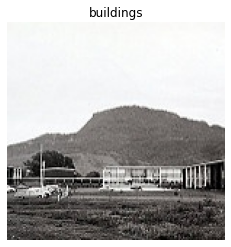

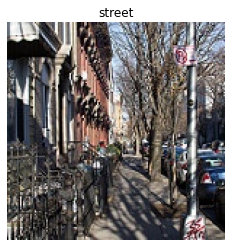

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (400,400,3): a 400x400 RGB image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (RGB=3)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(150,150,3) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1], desired_shape[2] ) , dtype=np.uint8 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i].split( '/' )[4]
        X[i] = cv2.cvtColor( 
                    cv2.resize( 
                        cv2.imread( file_list[i] , cv2.IMREAD_UNCHANGED ), 
                        ( desired_shape[0] , desired_shape[1] ) 
                    ), 
                    cv2.COLOR_BGR2RGB )  # read as rgb instead of bgr
        
    # === Return Results === #
    return X , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

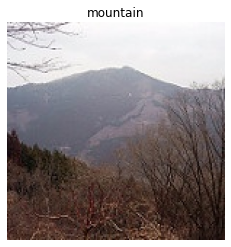

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )


# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having two class categories, we will translate the two possible classes to either a zero or a one to let the numerical output of the model specify the predicted class of the data. 

    buildings --> 0
    forest    --> 1
    glacier   --> 2
    mountain  --> 3
    sea       --> 4
    street    --> 5

This translation is performed against both the training and validation labels. 

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'buildings' : 0,
    'forest'    : 1,
    'glacier'   : 2,
    'mountain'  : 3,
    'sea'       : 4,
    'street'    : 5,
    0           : 'buildings',
    1           : 'forest',
    2           : 'glacier',
    3           : 'mountain',
    4           : 'sea',
    5           : 'street'
}

# === Iteratively Translate Labels === #
for c in data_classes:
    y_train[y_train==c] = label_keys[c]
    y_test[y_test==c]   = label_keys[c]

# === Update Data Types === #
y_train = y_train.astype( X_train.dtype )
y_test  = y_test.astype( X_test.dtype )
y_train = keras.utils.to_categorical( y_train )
y_test  = keras.utils.to_categorical( y_test )

# === Prove Success === #
y_train

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the softmax activation since this is a multi-class classification problem. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges in terms of accuracy. 

In [6]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),

        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),

        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 1024 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 64 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( len(data_classes) , activation='softmax' )
    ]
    model            = keras.Sequential( layers=model_layers )
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.00001, 0.0001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="categorical_crossentropy" , metrics=["accuracy"])
    return model

## Tune the Model

Using the keras-tuner package, we will tune the learning rate for the model in order to achieve the optimal validation accuracy via the hyperband tuning altorithm. This value may overfit, but it shows an example of how light tuning may result in better val accuracy in an automated tuning for this specific model architecture. 

In [7]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='SmallGrayReg' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 55:27 - loss: 1.8107 - accuracy: 0.187 - ETA: 28:21 - loss: 1.7806 - accuracy: 0.187 - ETA: 19:20 - loss: 1.7699 - accuracy: 0.208 - ETA: 14:49 - loss: 1.8365 - accuracy: 0.171 - ETA: 12:06 - loss: 1.8536 - accuracy: 0.150 - ETA: 10:18 - loss: 1.8549 - accuracy: 0.145 - ETA: 9:00 - loss: 1.8425 - accuracy: 0.133 - ETA: 8:02 - loss: 1.8392 - accuracy: 0.14 - ETA: 7:17 - loss: 1.8344 - accuracy: 0.13 - ETA: 6:41 - loss: 1.8331 - accuracy: 0.13 - ETA: 6:11 - loss: 1.8265 - accuracy: 0.14 - ETA: 5:46 - loss: 1.8245 - accuracy: 0.14 - ETA: 5:26 - loss: 1.8244 - accuracy: 0.14 - ETA: 5:08 - loss: 1.8271 - accuracy: 0.14 - ETA: 4:52 - loss: 1.8220 - accuracy: 0.14 - ETA: 4:38 - loss: 1.8175 - accuracy: 0.15 - ETA: 4:26 - loss: 1.8153 - accuracy: 0.15 - ETA: 4:16 - loss: 1.8126 - accuracy: 0.14 - ETA: 4:06 - loss: 1.8097 - accuracy: 0.15 - ETA: 3:57 - loss: 1.8065 - accuracy: 0.16 - ETA: 3:50 - loss: 1.8050 - accuracy: 0.16 - ETA: 3:42 - loss

 5920/14034 [===========>..................] - ETA: 1:17 - loss: 1.5119 - accuracy: 0.35 - ETA: 1:17 - loss: 1.5118 - accuracy: 0.35 - ETA: 1:17 - loss: 1.5090 - accuracy: 0.35 - ETA: 1:17 - loss: 1.5072 - accuracy: 0.35 - ETA: 1:17 - loss: 1.5081 - accuracy: 0.35 - ETA: 1:17 - loss: 1.5077 - accuracy: 0.35 - ETA: 1:16 - loss: 1.5088 - accuracy: 0.35 - ETA: 1:16 - loss: 1.5076 - accuracy: 0.35 - ETA: 1:16 - loss: 1.5082 - accuracy: 0.35 - ETA: 1:16 - loss: 1.5078 - accuracy: 0.35 - ETA: 1:16 - loss: 1.5044 - accuracy: 0.35 - ETA: 1:15 - loss: 1.5040 - accuracy: 0.36 - ETA: 1:15 - loss: 1.5012 - accuracy: 0.36 - ETA: 1:15 - loss: 1.4990 - accuracy: 0.36 - ETA: 1:15 - loss: 1.4988 - accuracy: 0.36 - ETA: 1:15 - loss: 1.4978 - accuracy: 0.36 - ETA: 1:15 - loss: 1.4973 - accuracy: 0.36 - ETA: 1:14 - loss: 1.4959 - accuracy: 0.36 - ETA: 1:14 - loss: 1.4930 - accuracy: 0.36 - ETA: 1:14 - loss: 1.4924 - accuracy: 0.36 - ETA: 1:14 - loss: 1.4930 - accuracy: 0.36 - ETA: 1:14 - loss: 1.4916 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.3720 - accuracy: 0.435 - ETA: 52s - loss: 1.3713 - accuracy: 0.435 - ETA: 51s - loss: 1.3705 - accuracy: 0.435 - ETA: 51s - loss: 1.3703 - accuracy: 0.436 - ETA: 51s - loss: 1.3692 - accuracy: 0.436 - ETA: 51s - loss: 1.3692 - accuracy: 0.437 - ETA: 51s - loss: 1.3686 - accuracy: 0.437 - ETA: 51s - loss: 1.3675 - accuracy: 0.437 - ETA: 51s - loss: 1.3668 - accuracy: 0.438 - ETA: 51s - loss: 1.3679 - accuracy: 0.438 - ETA: 51s - loss: 1.3676 - accuracy: 0.438 - ETA: 50s - loss: 1.3681 - accuracy: 0.438 - ETA: 50s - loss: 1.3681 - accuracy: 0.438 - ETA: 50s - loss: 1.3672 - accuracy: 0.438 - ETA: 50s - loss: 1.3670 - accuracy: 0.438 - ETA: 50s - loss: 1.3669 - accuracy: 0.438 - ETA: 50s - loss: 1.3671 - accuracy: 0.438 - ETA: 50s - loss: 1.3664 - accuracy: 0.439 - ETA: 50s - loss: 1.3665 - accuracy: 0.439 - ETA: 49s - loss: 1.3665 - accuracy: 0.439 - ETA: 49s - loss: 1.3655 - accuracy: 0.439 - ETA: 49s - loss: 1.3647 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.2948 - accuracy: 0.470 - ETA: 31s - loss: 1.2945 - accuracy: 0.470 - ETA: 31s - loss: 1.2937 - accuracy: 0.470 - ETA: 31s - loss: 1.2937 - accuracy: 0.471 - ETA: 31s - loss: 1.2933 - accuracy: 0.471 - ETA: 31s - loss: 1.2926 - accuracy: 0.471 - ETA: 31s - loss: 1.2924 - accuracy: 0.471 - ETA: 31s - loss: 1.2918 - accuracy: 0.471 - ETA: 31s - loss: 1.2914 - accuracy: 0.472 - ETA: 31s - loss: 1.2912 - accuracy: 0.472 - ETA: 31s - loss: 1.2908 - accuracy: 0.471 - ETA: 30s - loss: 1.2910 - accuracy: 0.472 - ETA: 30s - loss: 1.2904 - accuracy: 0.472 - ETA: 30s - loss: 1.2899 - accuracy: 0.472 - ETA: 30s - loss: 1.2896 - accuracy: 0.472 - ETA: 30s - loss: 1.2888 - accuracy: 0.473 - ETA: 30s - loss: 1.2887 - accuracy: 0.472 - ETA: 30s - loss: 1.2884 - accuracy: 0.472 - ETA: 30s - loss: 1.2874 - accuracy: 0.473 - ETA: 30s - loss: 1.2864 - accuracy: 0.473 - ETA: 29s - loss: 1.2858 - accuracy: 0.473 - ETA: 29s - loss: 1.2850 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2417 - accuracy: 0.495 - ETA: 13s - loss: 1.2415 - accuracy: 0.496 - ETA: 13s - loss: 1.2410 - accuracy: 0.496 - ETA: 12s - loss: 1.2408 - accuracy: 0.496 - ETA: 12s - loss: 1.2406 - accuracy: 0.496 - ETA: 12s - loss: 1.2401 - accuracy: 0.497 - ETA: 12s - loss: 1.2397 - accuracy: 0.497 - ETA: 12s - loss: 1.2395 - accuracy: 0.497 - ETA: 12s - loss: 1.2392 - accuracy: 0.497 - ETA: 12s - loss: 1.2387 - accuracy: 0.497 - ETA: 12s - loss: 1.2381 - accuracy: 0.497 - ETA: 12s - loss: 1.2383 - accuracy: 0.497 - ETA: 12s - loss: 1.2380 - accuracy: 0.497 - ETA: 11s - loss: 1.2374 - accuracy: 0.498 - ETA: 11s - loss: 1.2365 - accuracy: 0.498 - ETA: 11s - loss: 1.2363 - accuracy: 0.498 - ETA: 11s - loss: 1.2359 - accuracy: 0.498 - ETA: 11s - loss: 1.2360 - accuracy: 0.498 - ETA: 11s - loss: 1.2358 - accuracy: 0.498 - ETA: 11s - loss: 1.2351 - accuracy: 0.499 - ETA: 11s - loss: 1.2346 - accuracy: 0.499 - ETA: 11s - loss: 1.2347 - acc

 2976/14034 [=====>........................] - ETA: 1:22 - loss: 1.0491 - accuracy: 0.62 - ETA: 1:23 - loss: 1.2295 - accuracy: 0.50 - ETA: 1:23 - loss: 1.2842 - accuracy: 0.50 - ETA: 1:23 - loss: 1.2698 - accuracy: 0.53 - ETA: 1:23 - loss: 1.1079 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0536 - accuracy: 0.61 - ETA: 1:23 - loss: 1.0773 - accuracy: 0.61 - ETA: 1:23 - loss: 1.0386 - accuracy: 0.62 - ETA: 1:23 - loss: 1.0507 - accuracy: 0.61 - ETA: 1:23 - loss: 1.0150 - accuracy: 0.62 - ETA: 1:23 - loss: 1.0194 - accuracy: 0.61 - ETA: 1:23 - loss: 1.0138 - accuracy: 0.61 - ETA: 1:23 - loss: 1.0048 - accuracy: 0.62 - ETA: 1:23 - loss: 1.0087 - accuracy: 0.61 - ETA: 1:23 - loss: 1.0389 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0405 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0300 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0218 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0133 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0134 - accuracy: 0.60 - ETA: 1:23 - loss: 1.0259 - accuracy: 0.59 - ETA: 1:22 - loss: 1.0156 - ac

 5952/14034 [===========>..................] - ETA: 1:06 - loss: 0.9654 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9647 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9636 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9634 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9634 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9626 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9624 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9621 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9608 - accuracy: 0.62 - ETA: 1:06 - loss: 0.9601 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9615 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9640 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9634 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9609 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9602 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9604 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9620 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9607 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9596 - accuracy: 0.62 - ETA: 1:05 - loss: 0.9580 - accuracy: 0.62 - ETA: 1:04 - loss: 0.9582 - accuracy: 0.62 - ETA: 1:04 - loss: 0.9596 - ac

 8928/14034 [==================>...........] - ETA: 49s - loss: 0.9518 - accuracy: 0.629 - ETA: 49s - loss: 0.9518 - accuracy: 0.629 - ETA: 49s - loss: 0.9531 - accuracy: 0.629 - ETA: 49s - loss: 0.9530 - accuracy: 0.629 - ETA: 48s - loss: 0.9517 - accuracy: 0.630 - ETA: 48s - loss: 0.9510 - accuracy: 0.630 - ETA: 48s - loss: 0.9505 - accuracy: 0.630 - ETA: 48s - loss: 0.9507 - accuracy: 0.630 - ETA: 48s - loss: 0.9506 - accuracy: 0.630 - ETA: 48s - loss: 0.9504 - accuracy: 0.631 - ETA: 48s - loss: 0.9507 - accuracy: 0.631 - ETA: 48s - loss: 0.9499 - accuracy: 0.631 - ETA: 48s - loss: 0.9509 - accuracy: 0.630 - ETA: 48s - loss: 0.9509 - accuracy: 0.631 - ETA: 47s - loss: 0.9506 - accuracy: 0.630 - ETA: 47s - loss: 0.9502 - accuracy: 0.631 - ETA: 47s - loss: 0.9507 - accuracy: 0.631 - ETA: 47s - loss: 0.9504 - accuracy: 0.631 - ETA: 47s - loss: 0.9496 - accuracy: 0.632 - ETA: 47s - loss: 0.9496 - accuracy: 0.631 - ETA: 47s - loss: 0.9488 - accuracy: 0.631 - ETA: 47s - loss: 0.9476 - acc

11904/14034 [========================>.....] - ETA: 31s - loss: 0.9378 - accuracy: 0.636 - ETA: 31s - loss: 0.9371 - accuracy: 0.636 - ETA: 31s - loss: 0.9363 - accuracy: 0.637 - ETA: 30s - loss: 0.9359 - accuracy: 0.637 - ETA: 30s - loss: 0.9364 - accuracy: 0.637 - ETA: 30s - loss: 0.9364 - accuracy: 0.637 - ETA: 30s - loss: 0.9363 - accuracy: 0.637 - ETA: 30s - loss: 0.9359 - accuracy: 0.637 - ETA: 30s - loss: 0.9351 - accuracy: 0.637 - ETA: 30s - loss: 0.9347 - accuracy: 0.638 - ETA: 30s - loss: 0.9343 - accuracy: 0.638 - ETA: 30s - loss: 0.9339 - accuracy: 0.638 - ETA: 30s - loss: 0.9340 - accuracy: 0.638 - ETA: 29s - loss: 0.9341 - accuracy: 0.638 - ETA: 29s - loss: 0.9351 - accuracy: 0.637 - ETA: 29s - loss: 0.9359 - accuracy: 0.637 - ETA: 29s - loss: 0.9361 - accuracy: 0.637 - ETA: 29s - loss: 0.9375 - accuracy: 0.637 - ETA: 29s - loss: 0.9372 - accuracy: 0.637 - ETA: 29s - loss: 0.9376 - accuracy: 0.637 - ETA: 29s - loss: 0.9372 - accuracy: 0.637 - ETA: 29s - loss: 0.9369 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.9277 - accuracy: 0.641 - ETA: 12s - loss: 0.9278 - accuracy: 0.641 - ETA: 12s - loss: 0.9280 - accuracy: 0.641 - ETA: 12s - loss: 0.9275 - accuracy: 0.641 - ETA: 12s - loss: 0.9270 - accuracy: 0.641 - ETA: 12s - loss: 0.9272 - accuracy: 0.641 - ETA: 12s - loss: 0.9275 - accuracy: 0.642 - ETA: 12s - loss: 0.9279 - accuracy: 0.641 - ETA: 12s - loss: 0.9280 - accuracy: 0.641 - ETA: 12s - loss: 0.9281 - accuracy: 0.641 - ETA: 12s - loss: 0.9281 - accuracy: 0.641 - ETA: 11s - loss: 0.9281 - accuracy: 0.641 - ETA: 11s - loss: 0.9280 - accuracy: 0.641 - ETA: 11s - loss: 0.9281 - accuracy: 0.641 - ETA: 11s - loss: 0.9277 - accuracy: 0.641 - ETA: 11s - loss: 0.9272 - accuracy: 0.642 - ETA: 11s - loss: 0.9267 - accuracy: 0.642 - ETA: 11s - loss: 0.9269 - accuracy: 0.642 - ETA: 11s - loss: 0.9270 - accuracy: 0.642 - ETA: 11s - loss: 0.9267 - accuracy: 0.642 - ETA: 11s - loss: 0.9261 - accuracy: 0.642 - ETA: 10s - loss: 0.9261 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:08 - loss: 1.8734 - accuracy: 0.062 - ETA: 7:18 - loss: 1.8564 - accuracy: 0.125 - ETA: 5:20 - loss: 1.8755 - accuracy: 0.14 - ETA: 4:21 - loss: 1.8413 - accuracy: 0.17 - ETA: 3:46 - loss: 1.8121 - accuracy: 0.22 - ETA: 3:22 - loss: 1.8070 - accuracy: 0.21 - ETA: 3:05 - loss: 1.8352 - accuracy: 0.20 - ETA: 2:53 - loss: 1.8289 - accuracy: 0.21 - ETA: 2:43 - loss: 1.8259 - accuracy: 0.19 - ETA: 2:35 - loss: 1.8225 - accuracy: 0.18 - ETA: 2:28 - loss: 1.8187 - accuracy: 0.19 - ETA: 2:23 - loss: 1.8093 - accuracy: 0.20 - ETA: 2:18 - loss: 1.8021 - accuracy: 0.21 - ETA: 2:15 - loss: 1.8032 - accuracy: 0.21 - ETA: 2:11 - loss: 1.8102 - accuracy: 0.20 - ETA: 2:08 - loss: 1.8109 - accuracy: 0.21 - ETA: 2:05 - loss: 1.8088 - accuracy: 0.21 - ETA: 2:03 - loss: 1.8101 - accuracy: 0.20 - ETA: 2:01 - loss: 1.8079 - accuracy: 0.20 - ETA: 1:59 - loss: 1.8069 - accuracy: 0.20 - ETA: 1:57 - loss: 1.8055 - accuracy: 0.20 - ETA: 1:56 - loss: 1.8041 -

 5920/14034 [===========>..................] - ETA: 1:11 - loss: 1.5309 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5298 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5269 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5244 - accuracy: 0.36 - ETA: 1:11 - loss: 1.5243 - accuracy: 0.36 - ETA: 1:11 - loss: 1.5231 - accuracy: 0.36 - ETA: 1:11 - loss: 1.5205 - accuracy: 0.36 - ETA: 1:11 - loss: 1.5193 - accuracy: 0.36 - ETA: 1:11 - loss: 1.5186 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5186 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5167 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5155 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5147 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5143 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5148 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5145 - accuracy: 0.36 - ETA: 1:10 - loss: 1.5143 - accuracy: 0.36 - ETA: 1:09 - loss: 1.5159 - accuracy: 0.36 - ETA: 1:09 - loss: 1.5153 - accuracy: 0.36 - ETA: 1:09 - loss: 1.5148 - accuracy: 0.36 - ETA: 1:09 - loss: 1.5141 - accuracy: 0.36 - ETA: 1:09 - loss: 1.5137 - ac

 8896/14034 [==================>...........] - ETA: 51s - loss: 1.4264 - accuracy: 0.417 - ETA: 51s - loss: 1.4269 - accuracy: 0.417 - ETA: 51s - loss: 1.4272 - accuracy: 0.417 - ETA: 51s - loss: 1.4271 - accuracy: 0.417 - ETA: 51s - loss: 1.4272 - accuracy: 0.417 - ETA: 51s - loss: 1.4264 - accuracy: 0.417 - ETA: 51s - loss: 1.4259 - accuracy: 0.417 - ETA: 50s - loss: 1.4258 - accuracy: 0.417 - ETA: 50s - loss: 1.4274 - accuracy: 0.417 - ETA: 50s - loss: 1.4270 - accuracy: 0.417 - ETA: 50s - loss: 1.4267 - accuracy: 0.418 - ETA: 50s - loss: 1.4265 - accuracy: 0.418 - ETA: 50s - loss: 1.4267 - accuracy: 0.418 - ETA: 50s - loss: 1.4265 - accuracy: 0.419 - ETA: 50s - loss: 1.4264 - accuracy: 0.419 - ETA: 50s - loss: 1.4256 - accuracy: 0.420 - ETA: 50s - loss: 1.4257 - accuracy: 0.420 - ETA: 49s - loss: 1.4258 - accuracy: 0.420 - ETA: 49s - loss: 1.4245 - accuracy: 0.421 - ETA: 49s - loss: 1.4236 - accuracy: 0.421 - ETA: 49s - loss: 1.4226 - accuracy: 0.421 - ETA: 49s - loss: 1.4213 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.3284 - accuracy: 0.465 - ETA: 32s - loss: 1.3279 - accuracy: 0.465 - ETA: 32s - loss: 1.3281 - accuracy: 0.465 - ETA: 32s - loss: 1.3279 - accuracy: 0.466 - ETA: 32s - loss: 1.3267 - accuracy: 0.466 - ETA: 32s - loss: 1.3256 - accuracy: 0.466 - ETA: 31s - loss: 1.3257 - accuracy: 0.466 - ETA: 31s - loss: 1.3241 - accuracy: 0.467 - ETA: 31s - loss: 1.3238 - accuracy: 0.467 - ETA: 31s - loss: 1.3240 - accuracy: 0.467 - ETA: 31s - loss: 1.3237 - accuracy: 0.467 - ETA: 31s - loss: 1.3243 - accuracy: 0.467 - ETA: 31s - loss: 1.3231 - accuracy: 0.468 - ETA: 31s - loss: 1.3227 - accuracy: 0.468 - ETA: 31s - loss: 1.3226 - accuracy: 0.468 - ETA: 31s - loss: 1.3230 - accuracy: 0.468 - ETA: 30s - loss: 1.3228 - accuracy: 0.468 - ETA: 30s - loss: 1.3222 - accuracy: 0.468 - ETA: 30s - loss: 1.3219 - accuracy: 0.468 - ETA: 30s - loss: 1.3215 - accuracy: 0.469 - ETA: 30s - loss: 1.3210 - accuracy: 0.469 - ETA: 30s - loss: 1.3203 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2663 - accuracy: 0.493 - ETA: 13s - loss: 1.2659 - accuracy: 0.493 - ETA: 13s - loss: 1.2657 - accuracy: 0.493 - ETA: 13s - loss: 1.2654 - accuracy: 0.493 - ETA: 13s - loss: 1.2653 - accuracy: 0.493 - ETA: 13s - loss: 1.2651 - accuracy: 0.494 - ETA: 13s - loss: 1.2651 - accuracy: 0.493 - ETA: 12s - loss: 1.2648 - accuracy: 0.494 - ETA: 12s - loss: 1.2645 - accuracy: 0.494 - ETA: 12s - loss: 1.2641 - accuracy: 0.494 - ETA: 12s - loss: 1.2637 - accuracy: 0.494 - ETA: 12s - loss: 1.2633 - accuracy: 0.494 - ETA: 12s - loss: 1.2632 - accuracy: 0.494 - ETA: 12s - loss: 1.2630 - accuracy: 0.494 - ETA: 12s - loss: 1.2628 - accuracy: 0.494 - ETA: 12s - loss: 1.2621 - accuracy: 0.495 - ETA: 12s - loss: 1.2613 - accuracy: 0.495 - ETA: 11s - loss: 1.2606 - accuracy: 0.495 - ETA: 11s - loss: 1.2604 - accuracy: 0.495 - ETA: 11s - loss: 1.2598 - accuracy: 0.496 - ETA: 11s - loss: 1.2592 - accuracy: 0.496 - ETA: 11s - loss: 1.2590 - acc

 2976/14034 [=====>........................] - ETA: 1:27 - loss: 1.0305 - accuracy: 0.50 - ETA: 1:27 - loss: 0.9898 - accuracy: 0.62 - ETA: 1:26 - loss: 1.1443 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0835 - accuracy: 0.56 - ETA: 1:27 - loss: 1.0202 - accuracy: 0.60 - ETA: 1:27 - loss: 1.0422 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0134 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0437 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0389 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0367 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0353 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0361 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0221 - accuracy: 0.58 - ETA: 1:26 - loss: 0.9909 - accuracy: 0.60 - ETA: 1:26 - loss: 0.9961 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0167 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0101 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0171 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0421 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0608 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0806 - accuracy: 0.56 - ETA: 1:25 - loss: 1.0851 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 1.0100 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0095 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0106 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0111 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0111 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0122 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0115 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0126 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0123 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0099 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0096 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0086 - accuracy: 0.60 - ETA: 1:08 - loss: 1.0074 - accuracy: 0.60 - ETA: 1:08 - loss: 1.0055 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0049 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0039 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0029 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0022 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0044 - accuracy: 0.60 - ETA: 1:08 - loss: 1.0019 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0047 - accuracy: 0.61 - ETA: 1:07 - loss: 1.0048 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9885 - accuracy: 0.616 - ETA: 51s - loss: 0.9886 - accuracy: 0.616 - ETA: 51s - loss: 0.9870 - accuracy: 0.617 - ETA: 50s - loss: 0.9863 - accuracy: 0.617 - ETA: 50s - loss: 0.9856 - accuracy: 0.618 - ETA: 50s - loss: 0.9855 - accuracy: 0.617 - ETA: 50s - loss: 0.9847 - accuracy: 0.618 - ETA: 50s - loss: 0.9850 - accuracy: 0.618 - ETA: 50s - loss: 0.9846 - accuracy: 0.618 - ETA: 50s - loss: 0.9849 - accuracy: 0.618 - ETA: 50s - loss: 0.9848 - accuracy: 0.618 - ETA: 50s - loss: 0.9852 - accuracy: 0.617 - ETA: 50s - loss: 0.9845 - accuracy: 0.618 - ETA: 49s - loss: 0.9839 - accuracy: 0.618 - ETA: 49s - loss: 0.9834 - accuracy: 0.618 - ETA: 49s - loss: 0.9836 - accuracy: 0.618 - ETA: 49s - loss: 0.9845 - accuracy: 0.618 - ETA: 49s - loss: 0.9837 - accuracy: 0.618 - ETA: 49s - loss: 0.9838 - accuracy: 0.618 - ETA: 49s - loss: 0.9833 - accuracy: 0.618 - ETA: 49s - loss: 0.9842 - accuracy: 0.618 - ETA: 49s - loss: 0.9835 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9707 - accuracy: 0.623 - ETA: 32s - loss: 0.9702 - accuracy: 0.623 - ETA: 32s - loss: 0.9701 - accuracy: 0.623 - ETA: 32s - loss: 0.9704 - accuracy: 0.623 - ETA: 31s - loss: 0.9698 - accuracy: 0.623 - ETA: 31s - loss: 0.9703 - accuracy: 0.623 - ETA: 31s - loss: 0.9692 - accuracy: 0.623 - ETA: 31s - loss: 0.9689 - accuracy: 0.623 - ETA: 31s - loss: 0.9686 - accuracy: 0.623 - ETA: 31s - loss: 0.9685 - accuracy: 0.623 - ETA: 31s - loss: 0.9684 - accuracy: 0.623 - ETA: 31s - loss: 0.9684 - accuracy: 0.623 - ETA: 31s - loss: 0.9687 - accuracy: 0.623 - ETA: 31s - loss: 0.9687 - accuracy: 0.623 - ETA: 30s - loss: 0.9688 - accuracy: 0.623 - ETA: 30s - loss: 0.9683 - accuracy: 0.623 - ETA: 30s - loss: 0.9687 - accuracy: 0.623 - ETA: 30s - loss: 0.9691 - accuracy: 0.622 - ETA: 30s - loss: 0.9694 - accuracy: 0.622 - ETA: 30s - loss: 0.9691 - accuracy: 0.623 - ETA: 30s - loss: 0.9686 - accuracy: 0.623 - ETA: 30s - loss: 0.9680 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.9422 - accuracy: 0.631 - ETA: 13s - loss: 0.9417 - accuracy: 0.631 - ETA: 13s - loss: 0.9414 - accuracy: 0.631 - ETA: 13s - loss: 0.9415 - accuracy: 0.631 - ETA: 13s - loss: 0.9411 - accuracy: 0.632 - ETA: 12s - loss: 0.9409 - accuracy: 0.632 - ETA: 12s - loss: 0.9406 - accuracy: 0.632 - ETA: 12s - loss: 0.9402 - accuracy: 0.632 - ETA: 12s - loss: 0.9402 - accuracy: 0.632 - ETA: 12s - loss: 0.9399 - accuracy: 0.632 - ETA: 12s - loss: 0.9396 - accuracy: 0.632 - ETA: 12s - loss: 0.9393 - accuracy: 0.632 - ETA: 12s - loss: 0.9393 - accuracy: 0.632 - ETA: 12s - loss: 0.9389 - accuracy: 0.632 - ETA: 12s - loss: 0.9383 - accuracy: 0.633 - ETA: 11s - loss: 0.9383 - accuracy: 0.633 - ETA: 11s - loss: 0.9386 - accuracy: 0.632 - ETA: 11s - loss: 0.9382 - accuracy: 0.633 - ETA: 11s - loss: 0.9379 - accuracy: 0.633 - ETA: 11s - loss: 0.9378 - accuracy: 0.633 - ETA: 11s - loss: 0.9378 - accuracy: 0.633 - ETA: 11s - loss: 0.9382 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:51 - loss: 1.7298 - accuracy: 0.187 - ETA: 7:42 - loss: 1.7592 - accuracy: 0.218 - ETA: 5:37 - loss: 1.7818 - accuracy: 0.27 - ETA: 4:34 - loss: 1.7907 - accuracy: 0.23 - ETA: 3:56 - loss: 1.8049 - accuracy: 0.22 - ETA: 3:31 - loss: 1.8133 - accuracy: 0.21 - ETA: 3:13 - loss: 1.8075 - accuracy: 0.19 - ETA: 2:59 - loss: 1.7984 - accuracy: 0.20 - ETA: 2:49 - loss: 1.8057 - accuracy: 0.19 - ETA: 2:41 - loss: 1.8116 - accuracy: 0.18 - ETA: 2:34 - loss: 1.8051 - accuracy: 0.17 - ETA: 2:28 - loss: 1.8031 - accuracy: 0.17 - ETA: 2:23 - loss: 1.8072 - accuracy: 0.17 - ETA: 2:19 - loss: 1.8123 - accuracy: 0.16 - ETA: 2:15 - loss: 1.8115 - accuracy: 0.15 - ETA: 2:12 - loss: 1.8107 - accuracy: 0.15 - ETA: 2:09 - loss: 1.8107 - accuracy: 0.15 - ETA: 2:07 - loss: 1.8093 - accuracy: 0.14 - ETA: 2:04 - loss: 1.8090 - accuracy: 0.15 - ETA: 2:02 - loss: 1.8091 - accuracy: 0.14 - ETA: 2:00 - loss: 1.8090 - accuracy: 0.14 - ETA: 1:59 - loss: 1.8082 -

 5920/14034 [===========>..................] - ETA: 1:13 - loss: 1.5609 - accuracy: 0.32 - ETA: 1:13 - loss: 1.5588 - accuracy: 0.33 - ETA: 1:13 - loss: 1.5570 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5555 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5545 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5532 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5528 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5518 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5496 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5504 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5504 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5488 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5467 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5456 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5449 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5432 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5411 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5419 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5421 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5398 - accuracy: 0.33 - ETA: 1:10 - loss: 1.5388 - accuracy: 0.33 - ETA: 1:10 - loss: 1.5369 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.4132 - accuracy: 0.414 - ETA: 52s - loss: 1.4127 - accuracy: 0.414 - ETA: 52s - loss: 1.4125 - accuracy: 0.414 - ETA: 52s - loss: 1.4117 - accuracy: 0.415 - ETA: 52s - loss: 1.4101 - accuracy: 0.416 - ETA: 52s - loss: 1.4084 - accuracy: 0.416 - ETA: 51s - loss: 1.4083 - accuracy: 0.416 - ETA: 51s - loss: 1.4089 - accuracy: 0.417 - ETA: 51s - loss: 1.4081 - accuracy: 0.417 - ETA: 51s - loss: 1.4075 - accuracy: 0.418 - ETA: 51s - loss: 1.4080 - accuracy: 0.418 - ETA: 51s - loss: 1.4064 - accuracy: 0.419 - ETA: 51s - loss: 1.4047 - accuracy: 0.420 - ETA: 51s - loss: 1.4037 - accuracy: 0.420 - ETA: 51s - loss: 1.4019 - accuracy: 0.421 - ETA: 51s - loss: 1.4011 - accuracy: 0.422 - ETA: 50s - loss: 1.4014 - accuracy: 0.422 - ETA: 50s - loss: 1.4006 - accuracy: 0.422 - ETA: 50s - loss: 1.4001 - accuracy: 0.422 - ETA: 50s - loss: 1.3994 - accuracy: 0.422 - ETA: 50s - loss: 1.3986 - accuracy: 0.423 - ETA: 50s - loss: 1.3979 - acc

11872/14034 [========================>.....] - ETA: 33s - loss: 1.3081 - accuracy: 0.465 - ETA: 32s - loss: 1.3082 - accuracy: 0.464 - ETA: 32s - loss: 1.3085 - accuracy: 0.464 - ETA: 32s - loss: 1.3081 - accuracy: 0.465 - ETA: 32s - loss: 1.3074 - accuracy: 0.465 - ETA: 32s - loss: 1.3071 - accuracy: 0.465 - ETA: 32s - loss: 1.3070 - accuracy: 0.465 - ETA: 32s - loss: 1.3063 - accuracy: 0.465 - ETA: 32s - loss: 1.3055 - accuracy: 0.466 - ETA: 32s - loss: 1.3053 - accuracy: 0.465 - ETA: 32s - loss: 1.3054 - accuracy: 0.465 - ETA: 31s - loss: 1.3050 - accuracy: 0.466 - ETA: 31s - loss: 1.3046 - accuracy: 0.466 - ETA: 31s - loss: 1.3041 - accuracy: 0.466 - ETA: 31s - loss: 1.3035 - accuracy: 0.467 - ETA: 31s - loss: 1.3036 - accuracy: 0.467 - ETA: 31s - loss: 1.3028 - accuracy: 0.467 - ETA: 31s - loss: 1.3024 - accuracy: 0.467 - ETA: 31s - loss: 1.3022 - accuracy: 0.467 - ETA: 31s - loss: 1.3013 - accuracy: 0.468 - ETA: 31s - loss: 1.3006 - accuracy: 0.468 - ETA: 30s - loss: 1.3002 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2353 - accuracy: 0.500 - ETA: 13s - loss: 1.2352 - accuracy: 0.500 - ETA: 13s - loss: 1.2351 - accuracy: 0.500 - ETA: 13s - loss: 1.2347 - accuracy: 0.500 - ETA: 13s - loss: 1.2342 - accuracy: 0.500 - ETA: 13s - loss: 1.2338 - accuracy: 0.500 - ETA: 13s - loss: 1.2335 - accuracy: 0.501 - ETA: 13s - loss: 1.2329 - accuracy: 0.501 - ETA: 12s - loss: 1.2326 - accuracy: 0.501 - ETA: 12s - loss: 1.2327 - accuracy: 0.501 - ETA: 12s - loss: 1.2322 - accuracy: 0.501 - ETA: 12s - loss: 1.2326 - accuracy: 0.501 - ETA: 12s - loss: 1.2323 - accuracy: 0.501 - ETA: 12s - loss: 1.2317 - accuracy: 0.501 - ETA: 12s - loss: 1.2314 - accuracy: 0.502 - ETA: 12s - loss: 1.2308 - accuracy: 0.502 - ETA: 12s - loss: 1.2307 - accuracy: 0.502 - ETA: 12s - loss: 1.2307 - accuracy: 0.502 - ETA: 11s - loss: 1.2304 - accuracy: 0.502 - ETA: 11s - loss: 1.2308 - accuracy: 0.502 - ETA: 11s - loss: 1.2305 - accuracy: 0.502 - ETA: 11s - loss: 1.2300 - acc

 2976/14034 [=====>........................] - ETA: 1:26 - loss: 1.3439 - accuracy: 0.62 - ETA: 1:26 - loss: 1.1675 - accuracy: 0.56 - ETA: 1:27 - loss: 1.0444 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0007 - accuracy: 0.60 - ETA: 1:27 - loss: 1.0925 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0520 - accuracy: 0.59 - ETA: 1:27 - loss: 0.9674 - accuracy: 0.63 - ETA: 1:27 - loss: 0.9855 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9527 - accuracy: 0.63 - ETA: 1:27 - loss: 0.9666 - accuracy: 0.61 - ETA: 1:27 - loss: 0.9669 - accuracy: 0.61 - ETA: 1:28 - loss: 0.9704 - accuracy: 0.61 - ETA: 1:27 - loss: 0.9456 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9512 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9226 - accuracy: 0.65 - ETA: 1:27 - loss: 0.9065 - accuracy: 0.65 - ETA: 1:27 - loss: 0.9173 - accuracy: 0.64 - ETA: 1:27 - loss: 0.9288 - accuracy: 0.63 - ETA: 1:27 - loss: 0.9358 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9343 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9543 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9777 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.9631 - accuracy: 0.62 - ETA: 1:10 - loss: 0.9616 - accuracy: 0.63 - ETA: 1:10 - loss: 0.9607 - accuracy: 0.63 - ETA: 1:10 - loss: 0.9592 - accuracy: 0.63 - ETA: 1:10 - loss: 0.9575 - accuracy: 0.63 - ETA: 1:10 - loss: 0.9560 - accuracy: 0.63 - ETA: 1:10 - loss: 0.9589 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9564 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9573 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9556 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9563 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9565 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9556 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9557 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9549 - accuracy: 0.63 - ETA: 1:09 - loss: 0.9548 - accuracy: 0.63 - ETA: 1:08 - loss: 0.9528 - accuracy: 0.63 - ETA: 1:08 - loss: 0.9525 - accuracy: 0.63 - ETA: 1:08 - loss: 0.9550 - accuracy: 0.63 - ETA: 1:08 - loss: 0.9548 - accuracy: 0.63 - ETA: 1:08 - loss: 0.9561 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9558 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9321 - accuracy: 0.635 - ETA: 51s - loss: 0.9318 - accuracy: 0.635 - ETA: 51s - loss: 0.9326 - accuracy: 0.635 - ETA: 51s - loss: 0.9319 - accuracy: 0.635 - ETA: 51s - loss: 0.9316 - accuracy: 0.635 - ETA: 51s - loss: 0.9318 - accuracy: 0.635 - ETA: 50s - loss: 0.9306 - accuracy: 0.636 - ETA: 50s - loss: 0.9309 - accuracy: 0.636 - ETA: 50s - loss: 0.9297 - accuracy: 0.636 - ETA: 50s - loss: 0.9291 - accuracy: 0.636 - ETA: 50s - loss: 0.9292 - accuracy: 0.636 - ETA: 50s - loss: 0.9305 - accuracy: 0.635 - ETA: 50s - loss: 0.9315 - accuracy: 0.635 - ETA: 50s - loss: 0.9314 - accuracy: 0.635 - ETA: 50s - loss: 0.9303 - accuracy: 0.636 - ETA: 50s - loss: 0.9293 - accuracy: 0.636 - ETA: 49s - loss: 0.9305 - accuracy: 0.636 - ETA: 49s - loss: 0.9302 - accuracy: 0.636 - ETA: 49s - loss: 0.9302 - accuracy: 0.636 - ETA: 49s - loss: 0.9297 - accuracy: 0.636 - ETA: 49s - loss: 0.9302 - accuracy: 0.635 - ETA: 49s - loss: 0.9299 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9236 - accuracy: 0.638 - ETA: 32s - loss: 0.9246 - accuracy: 0.637 - ETA: 32s - loss: 0.9241 - accuracy: 0.638 - ETA: 32s - loss: 0.9245 - accuracy: 0.638 - ETA: 32s - loss: 0.9240 - accuracy: 0.638 - ETA: 32s - loss: 0.9245 - accuracy: 0.638 - ETA: 31s - loss: 0.9237 - accuracy: 0.638 - ETA: 31s - loss: 0.9233 - accuracy: 0.638 - ETA: 31s - loss: 0.9231 - accuracy: 0.639 - ETA: 31s - loss: 0.9231 - accuracy: 0.638 - ETA: 31s - loss: 0.9224 - accuracy: 0.638 - ETA: 31s - loss: 0.9222 - accuracy: 0.638 - ETA: 31s - loss: 0.9215 - accuracy: 0.639 - ETA: 31s - loss: 0.9208 - accuracy: 0.639 - ETA: 31s - loss: 0.9206 - accuracy: 0.639 - ETA: 31s - loss: 0.9198 - accuracy: 0.639 - ETA: 30s - loss: 0.9194 - accuracy: 0.640 - ETA: 30s - loss: 0.9191 - accuracy: 0.640 - ETA: 30s - loss: 0.9185 - accuracy: 0.640 - ETA: 30s - loss: 0.9198 - accuracy: 0.640 - ETA: 30s - loss: 0.9196 - accuracy: 0.640 - ETA: 30s - loss: 0.9195 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.9052 - accuracy: 0.645 - ETA: 13s - loss: 0.9057 - accuracy: 0.645 - ETA: 13s - loss: 0.9060 - accuracy: 0.645 - ETA: 13s - loss: 0.9063 - accuracy: 0.645 - ETA: 13s - loss: 0.9065 - accuracy: 0.645 - ETA: 13s - loss: 0.9067 - accuracy: 0.644 - ETA: 12s - loss: 0.9065 - accuracy: 0.644 - ETA: 12s - loss: 0.9066 - accuracy: 0.644 - ETA: 12s - loss: 0.9064 - accuracy: 0.645 - ETA: 12s - loss: 0.9068 - accuracy: 0.645 - ETA: 12s - loss: 0.9066 - accuracy: 0.645 - ETA: 12s - loss: 0.9065 - accuracy: 0.645 - ETA: 12s - loss: 0.9066 - accuracy: 0.645 - ETA: 12s - loss: 0.9066 - accuracy: 0.645 - ETA: 12s - loss: 0.9066 - accuracy: 0.645 - ETA: 11s - loss: 0.9068 - accuracy: 0.644 - ETA: 11s - loss: 0.9066 - accuracy: 0.644 - ETA: 11s - loss: 0.9063 - accuracy: 0.644 - ETA: 11s - loss: 0.9060 - accuracy: 0.645 - ETA: 11s - loss: 0.9059 - accuracy: 0.645 - ETA: 11s - loss: 0.9060 - accuracy: 0.645 - ETA: 11s - loss: 0.9061 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:12 - loss: 1.7125 - accuracy: 0.375 - ETA: 7:20 - loss: 1.9446 - accuracy: 0.343 - ETA: 5:21 - loss: 2.0007 - accuracy: 0.25 - ETA: 4:22 - loss: 1.9612 - accuracy: 0.21 - ETA: 3:47 - loss: 1.9268 - accuracy: 0.23 - ETA: 3:23 - loss: 1.9071 - accuracy: 0.21 - ETA: 3:07 - loss: 1.8872 - accuracy: 0.23 - ETA: 2:54 - loss: 1.8803 - accuracy: 0.21 - ETA: 2:44 - loss: 1.8704 - accuracy: 0.21 - ETA: 2:36 - loss: 1.8587 - accuracy: 0.21 - ETA: 2:30 - loss: 1.8445 - accuracy: 0.23 - ETA: 2:24 - loss: 1.8395 - accuracy: 0.23 - ETA: 2:19 - loss: 1.8457 - accuracy: 0.22 - ETA: 2:16 - loss: 1.8406 - accuracy: 0.20 - ETA: 2:12 - loss: 1.8371 - accuracy: 0.21 - ETA: 2:09 - loss: 1.8363 - accuracy: 0.19 - ETA: 2:06 - loss: 1.8301 - accuracy: 0.20 - ETA: 2:04 - loss: 1.8306 - accuracy: 0.19 - ETA: 2:02 - loss: 1.8308 - accuracy: 0.19 - ETA: 2:00 - loss: 1.8294 - accuracy: 0.18 - ETA: 1:58 - loss: 1.8279 - accuracy: 0.18 - ETA: 1:57 - loss: 1.8263 -

 5920/14034 [===========>..................] - ETA: 1:13 - loss: 1.7922 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7921 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7919 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7917 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7921 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7926 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7925 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7924 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7924 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7924 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7924 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7924 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7924 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7924 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.7899 - accuracy: 0.188 - ETA: 52s - loss: 1.7898 - accuracy: 0.188 - ETA: 52s - loss: 1.7898 - accuracy: 0.187 - ETA: 52s - loss: 1.7898 - accuracy: 0.187 - ETA: 51s - loss: 1.7897 - accuracy: 0.187 - ETA: 51s - loss: 1.7897 - accuracy: 0.187 - ETA: 51s - loss: 1.7896 - accuracy: 0.187 - ETA: 51s - loss: 1.7894 - accuracy: 0.187 - ETA: 51s - loss: 1.7892 - accuracy: 0.187 - ETA: 51s - loss: 1.7884 - accuracy: 0.187 - ETA: 51s - loss: 1.7907 - accuracy: 0.187 - ETA: 51s - loss: 1.7906 - accuracy: 0.187 - ETA: 51s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7904 - accuracy: 0.187 - ETA: 50s - loss: 1.7905 - accuracy: 0.187 - ETA: 50s - loss: 1.7906 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.7888 - accuracy: 0.188 - ETA: 32s - loss: 1.7884 - accuracy: 0.189 - ETA: 32s - loss: 1.7884 - accuracy: 0.189 - ETA: 32s - loss: 1.7881 - accuracy: 0.189 - ETA: 32s - loss: 1.7879 - accuracy: 0.189 - ETA: 32s - loss: 1.7879 - accuracy: 0.189 - ETA: 32s - loss: 1.7878 - accuracy: 0.189 - ETA: 32s - loss: 1.7878 - accuracy: 0.189 - ETA: 32s - loss: 1.7878 - accuracy: 0.189 - ETA: 31s - loss: 1.7878 - accuracy: 0.189 - ETA: 31s - loss: 1.7879 - accuracy: 0.189 - ETA: 31s - loss: 1.7878 - accuracy: 0.189 - ETA: 31s - loss: 1.7878 - accuracy: 0.189 - ETA: 31s - loss: 1.7878 - accuracy: 0.189 - ETA: 31s - loss: 1.7879 - accuracy: 0.189 - ETA: 31s - loss: 1.7879 - accuracy: 0.189 - ETA: 31s - loss: 1.7879 - accuracy: 0.188 - ETA: 31s - loss: 1.7879 - accuracy: 0.188 - ETA: 31s - loss: 1.7879 - accuracy: 0.188 - ETA: 30s - loss: 1.7879 - accuracy: 0.188 - ETA: 30s - loss: 1.7880 - accuracy: 0.188 - ETA: 30s - loss: 1.7880 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.7537 - accuracy: 0.218 - ETA: 13s - loss: 1.7537 - accuracy: 0.218 - ETA: 13s - loss: 1.7535 - accuracy: 0.218 - ETA: 13s - loss: 1.7530 - accuracy: 0.219 - ETA: 13s - loss: 1.7526 - accuracy: 0.219 - ETA: 13s - loss: 1.7522 - accuracy: 0.219 - ETA: 13s - loss: 1.7521 - accuracy: 0.219 - ETA: 13s - loss: 1.7515 - accuracy: 0.220 - ETA: 12s - loss: 1.7507 - accuracy: 0.220 - ETA: 12s - loss: 1.7502 - accuracy: 0.220 - ETA: 12s - loss: 1.7498 - accuracy: 0.221 - ETA: 12s - loss: 1.7493 - accuracy: 0.221 - ETA: 12s - loss: 1.7487 - accuracy: 0.222 - ETA: 12s - loss: 1.7481 - accuracy: 0.222 - ETA: 12s - loss: 1.7472 - accuracy: 0.222 - ETA: 12s - loss: 1.7469 - accuracy: 0.223 - ETA: 12s - loss: 1.7461 - accuracy: 0.223 - ETA: 11s - loss: 1.7458 - accuracy: 0.223 - ETA: 11s - loss: 1.7451 - accuracy: 0.224 - ETA: 11s - loss: 1.7448 - accuracy: 0.224 - ETA: 11s - loss: 1.7444 - accuracy: 0.224 - ETA: 11s - loss: 1.7439 - acc

 2976/14034 [=====>........................] - ETA: 1:25 - loss: 0.8599 - accuracy: 0.81 - ETA: 1:25 - loss: 0.9916 - accuracy: 0.65 - ETA: 1:25 - loss: 1.1143 - accuracy: 0.56 - ETA: 1:26 - loss: 1.1467 - accuracy: 0.50 - ETA: 1:26 - loss: 1.1289 - accuracy: 0.50 - ETA: 1:26 - loss: 1.1443 - accuracy: 0.50 - ETA: 1:26 - loss: 1.2356 - accuracy: 0.48 - ETA: 1:26 - loss: 1.2359 - accuracy: 0.46 - ETA: 1:26 - loss: 1.2757 - accuracy: 0.47 - ETA: 1:26 - loss: 1.2896 - accuracy: 0.46 - ETA: 1:26 - loss: 1.2695 - accuracy: 0.47 - ETA: 1:26 - loss: 1.2869 - accuracy: 0.45 - ETA: 1:26 - loss: 1.2795 - accuracy: 0.46 - ETA: 1:26 - loss: 1.2407 - accuracy: 0.47 - ETA: 1:26 - loss: 1.2094 - accuracy: 0.49 - ETA: 1:26 - loss: 1.2284 - accuracy: 0.49 - ETA: 1:26 - loss: 1.2137 - accuracy: 0.50 - ETA: 1:26 - loss: 1.2335 - accuracy: 0.50 - ETA: 1:26 - loss: 1.2377 - accuracy: 0.49 - ETA: 1:26 - loss: 1.2382 - accuracy: 0.49 - ETA: 1:26 - loss: 1.2545 - accuracy: 0.48 - ETA: 1:26 - loss: 1.2547 - ac

 5952/14034 [===========>..................] - ETA: 1:09 - loss: 1.1615 - accuracy: 0.53 - ETA: 1:09 - loss: 1.1606 - accuracy: 0.54 - ETA: 1:09 - loss: 1.1595 - accuracy: 0.54 - ETA: 1:09 - loss: 1.1596 - accuracy: 0.54 - ETA: 1:09 - loss: 1.1609 - accuracy: 0.54 - ETA: 1:09 - loss: 1.1593 - accuracy: 0.54 - ETA: 1:09 - loss: 1.1560 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1551 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1541 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1541 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1556 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1558 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1547 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1540 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1534 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1548 - accuracy: 0.54 - ETA: 1:08 - loss: 1.1529 - accuracy: 0.54 - ETA: 1:07 - loss: 1.1529 - accuracy: 0.54 - ETA: 1:07 - loss: 1.1517 - accuracy: 0.54 - ETA: 1:07 - loss: 1.1518 - accuracy: 0.54 - ETA: 1:07 - loss: 1.1507 - accuracy: 0.54 - ETA: 1:07 - loss: 1.1497 - ac

 8928/14034 [==================>...........] - ETA: 50s - loss: 1.1017 - accuracy: 0.567 - ETA: 50s - loss: 1.1010 - accuracy: 0.568 - ETA: 50s - loss: 1.1007 - accuracy: 0.568 - ETA: 50s - loss: 1.1003 - accuracy: 0.568 - ETA: 50s - loss: 1.1008 - accuracy: 0.568 - ETA: 50s - loss: 1.1007 - accuracy: 0.568 - ETA: 50s - loss: 1.0994 - accuracy: 0.568 - ETA: 50s - loss: 1.0996 - accuracy: 0.568 - ETA: 50s - loss: 1.0986 - accuracy: 0.568 - ETA: 50s - loss: 1.0984 - accuracy: 0.568 - ETA: 49s - loss: 1.0984 - accuracy: 0.568 - ETA: 49s - loss: 1.0983 - accuracy: 0.568 - ETA: 49s - loss: 1.0983 - accuracy: 0.568 - ETA: 49s - loss: 1.0978 - accuracy: 0.569 - ETA: 49s - loss: 1.0963 - accuracy: 0.569 - ETA: 49s - loss: 1.0958 - accuracy: 0.569 - ETA: 49s - loss: 1.0948 - accuracy: 0.569 - ETA: 49s - loss: 1.0947 - accuracy: 0.570 - ETA: 49s - loss: 1.0956 - accuracy: 0.569 - ETA: 48s - loss: 1.0954 - accuracy: 0.569 - ETA: 48s - loss: 1.0948 - accuracy: 0.569 - ETA: 48s - loss: 1.0942 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 1.0622 - accuracy: 0.581 - ETA: 32s - loss: 1.0626 - accuracy: 0.580 - ETA: 31s - loss: 1.0621 - accuracy: 0.581 - ETA: 31s - loss: 1.0620 - accuracy: 0.581 - ETA: 31s - loss: 1.0621 - accuracy: 0.581 - ETA: 31s - loss: 1.0611 - accuracy: 0.581 - ETA: 31s - loss: 1.0618 - accuracy: 0.581 - ETA: 31s - loss: 1.0611 - accuracy: 0.582 - ETA: 31s - loss: 1.0605 - accuracy: 0.582 - ETA: 31s - loss: 1.0599 - accuracy: 0.582 - ETA: 31s - loss: 1.0608 - accuracy: 0.582 - ETA: 31s - loss: 1.0608 - accuracy: 0.583 - ETA: 30s - loss: 1.0601 - accuracy: 0.583 - ETA: 30s - loss: 1.0601 - accuracy: 0.583 - ETA: 30s - loss: 1.0600 - accuracy: 0.583 - ETA: 30s - loss: 1.0596 - accuracy: 0.583 - ETA: 30s - loss: 1.0591 - accuracy: 0.583 - ETA: 30s - loss: 1.0586 - accuracy: 0.583 - ETA: 30s - loss: 1.0585 - accuracy: 0.584 - ETA: 30s - loss: 1.0586 - accuracy: 0.584 - ETA: 30s - loss: 1.0585 - accuracy: 0.584 - ETA: 30s - loss: 1.0593 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.0423 - accuracy: 0.588 - ETA: 13s - loss: 1.0425 - accuracy: 0.588 - ETA: 13s - loss: 1.0423 - accuracy: 0.588 - ETA: 13s - loss: 1.0423 - accuracy: 0.588 - ETA: 12s - loss: 1.0417 - accuracy: 0.589 - ETA: 12s - loss: 1.0414 - accuracy: 0.589 - ETA: 12s - loss: 1.0407 - accuracy: 0.589 - ETA: 12s - loss: 1.0409 - accuracy: 0.589 - ETA: 12s - loss: 1.0406 - accuracy: 0.589 - ETA: 12s - loss: 1.0411 - accuracy: 0.589 - ETA: 12s - loss: 1.0412 - accuracy: 0.589 - ETA: 12s - loss: 1.0414 - accuracy: 0.589 - ETA: 12s - loss: 1.0408 - accuracy: 0.589 - ETA: 12s - loss: 1.0406 - accuracy: 0.589 - ETA: 11s - loss: 1.0405 - accuracy: 0.589 - ETA: 11s - loss: 1.0400 - accuracy: 0.589 - ETA: 11s - loss: 1.0402 - accuracy: 0.589 - ETA: 11s - loss: 1.0401 - accuracy: 0.589 - ETA: 11s - loss: 1.0395 - accuracy: 0.589 - ETA: 11s - loss: 1.0388 - accuracy: 0.589 - ETA: 11s - loss: 1.0392 - accuracy: 0.589 - ETA: 11s - loss: 1.0389 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:11 - loss: 1.8719 - accuracy: 0.187 - ETA: 7:21 - loss: 1.8362 - accuracy: 0.218 - ETA: 5:24 - loss: 1.7853 - accuracy: 0.27 - ETA: 4:24 - loss: 1.8396 - accuracy: 0.25 - ETA: 3:48 - loss: 1.8659 - accuracy: 0.23 - ETA: 3:24 - loss: 1.8606 - accuracy: 0.23 - ETA: 3:07 - loss: 1.8655 - accuracy: 0.21 - ETA: 2:54 - loss: 1.8562 - accuracy: 0.21 - ETA: 2:44 - loss: 1.8465 - accuracy: 0.20 - ETA: 2:36 - loss: 1.8401 - accuracy: 0.20 - ETA: 2:30 - loss: 1.8371 - accuracy: 0.20 - ETA: 2:24 - loss: 1.8348 - accuracy: 0.19 - ETA: 2:20 - loss: 1.8280 - accuracy: 0.20 - ETA: 2:16 - loss: 1.8306 - accuracy: 0.20 - ETA: 2:12 - loss: 1.8292 - accuracy: 0.19 - ETA: 2:09 - loss: 1.8290 - accuracy: 0.18 - ETA: 2:07 - loss: 1.8273 - accuracy: 0.19 - ETA: 2:04 - loss: 1.8254 - accuracy: 0.19 - ETA: 2:02 - loss: 1.8237 - accuracy: 0.19 - ETA: 2:00 - loss: 1.8207 - accuracy: 0.20 - ETA: 1:58 - loss: 1.8195 - accuracy: 0.19 - ETA: 1:57 - loss: 1.8178 -

 5920/14034 [===========>..................] - ETA: 1:12 - loss: 1.5869 - accuracy: 0.32 - ETA: 1:12 - loss: 1.5854 - accuracy: 0.32 - ETA: 1:12 - loss: 1.5836 - accuracy: 0.32 - ETA: 1:12 - loss: 1.5808 - accuracy: 0.32 - ETA: 1:12 - loss: 1.5800 - accuracy: 0.32 - ETA: 1:12 - loss: 1.5779 - accuracy: 0.32 - ETA: 1:12 - loss: 1.5768 - accuracy: 0.32 - ETA: 1:11 - loss: 1.5756 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5730 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5718 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5699 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5670 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5632 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5595 - accuracy: 0.33 - ETA: 1:11 - loss: 1.5592 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5586 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5607 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5585 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5572 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5564 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5546 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5528 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.4395 - accuracy: 0.410 - ETA: 52s - loss: 1.4387 - accuracy: 0.410 - ETA: 52s - loss: 1.4380 - accuracy: 0.411 - ETA: 51s - loss: 1.4385 - accuracy: 0.411 - ETA: 51s - loss: 1.4380 - accuracy: 0.412 - ETA: 51s - loss: 1.4360 - accuracy: 0.413 - ETA: 51s - loss: 1.4351 - accuracy: 0.414 - ETA: 51s - loss: 1.4333 - accuracy: 0.414 - ETA: 51s - loss: 1.4321 - accuracy: 0.414 - ETA: 51s - loss: 1.4310 - accuracy: 0.415 - ETA: 51s - loss: 1.4305 - accuracy: 0.415 - ETA: 51s - loss: 1.4307 - accuracy: 0.415 - ETA: 50s - loss: 1.4309 - accuracy: 0.416 - ETA: 50s - loss: 1.4302 - accuracy: 0.416 - ETA: 50s - loss: 1.4297 - accuracy: 0.416 - ETA: 50s - loss: 1.4285 - accuracy: 0.417 - ETA: 50s - loss: 1.4269 - accuracy: 0.417 - ETA: 50s - loss: 1.4257 - accuracy: 0.418 - ETA: 50s - loss: 1.4244 - accuracy: 0.418 - ETA: 50s - loss: 1.4251 - accuracy: 0.419 - ETA: 50s - loss: 1.4241 - accuracy: 0.419 - ETA: 50s - loss: 1.4235 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.3493 - accuracy: 0.455 - ETA: 32s - loss: 1.3500 - accuracy: 0.455 - ETA: 32s - loss: 1.3502 - accuracy: 0.455 - ETA: 32s - loss: 1.3497 - accuracy: 0.455 - ETA: 32s - loss: 1.3493 - accuracy: 0.455 - ETA: 32s - loss: 1.3484 - accuracy: 0.456 - ETA: 32s - loss: 1.3482 - accuracy: 0.456 - ETA: 32s - loss: 1.3473 - accuracy: 0.456 - ETA: 32s - loss: 1.3467 - accuracy: 0.457 - ETA: 31s - loss: 1.3462 - accuracy: 0.457 - ETA: 31s - loss: 1.3461 - accuracy: 0.457 - ETA: 31s - loss: 1.3454 - accuracy: 0.457 - ETA: 31s - loss: 1.3446 - accuracy: 0.457 - ETA: 31s - loss: 1.3438 - accuracy: 0.458 - ETA: 31s - loss: 1.3430 - accuracy: 0.458 - ETA: 31s - loss: 1.3425 - accuracy: 0.458 - ETA: 31s - loss: 1.3416 - accuracy: 0.458 - ETA: 31s - loss: 1.3407 - accuracy: 0.459 - ETA: 30s - loss: 1.3408 - accuracy: 0.459 - ETA: 30s - loss: 1.3403 - accuracy: 0.459 - ETA: 30s - loss: 1.3408 - accuracy: 0.459 - ETA: 30s - loss: 1.3400 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2806 - accuracy: 0.485 - ETA: 13s - loss: 1.2802 - accuracy: 0.485 - ETA: 13s - loss: 1.2795 - accuracy: 0.485 - ETA: 13s - loss: 1.2791 - accuracy: 0.485 - ETA: 13s - loss: 1.2784 - accuracy: 0.485 - ETA: 13s - loss: 1.2778 - accuracy: 0.485 - ETA: 13s - loss: 1.2775 - accuracy: 0.485 - ETA: 13s - loss: 1.2766 - accuracy: 0.486 - ETA: 12s - loss: 1.2761 - accuracy: 0.486 - ETA: 12s - loss: 1.2759 - accuracy: 0.486 - ETA: 12s - loss: 1.2754 - accuracy: 0.486 - ETA: 12s - loss: 1.2757 - accuracy: 0.486 - ETA: 12s - loss: 1.2752 - accuracy: 0.486 - ETA: 12s - loss: 1.2746 - accuracy: 0.486 - ETA: 12s - loss: 1.2741 - accuracy: 0.487 - ETA: 12s - loss: 1.2738 - accuracy: 0.487 - ETA: 12s - loss: 1.2733 - accuracy: 0.487 - ETA: 12s - loss: 1.2727 - accuracy: 0.487 - ETA: 11s - loss: 1.2725 - accuracy: 0.488 - ETA: 11s - loss: 1.2722 - accuracy: 0.488 - ETA: 11s - loss: 1.2718 - accuracy: 0.488 - ETA: 11s - loss: 1.2716 - acc

 2976/14034 [=====>........................] - ETA: 1:28 - loss: 1.0335 - accuracy: 0.56 - ETA: 1:27 - loss: 0.8639 - accuracy: 0.65 - ETA: 1:27 - loss: 0.9839 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0005 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0205 - accuracy: 0.61 - ETA: 1:27 - loss: 1.0405 - accuracy: 0.58 - ETA: 1:27 - loss: 0.9735 - accuracy: 0.62 - ETA: 1:27 - loss: 1.0301 - accuracy: 0.59 - ETA: 1:28 - loss: 1.0128 - accuracy: 0.58 - ETA: 1:28 - loss: 1.0204 - accuracy: 0.58 - ETA: 1:28 - loss: 1.0511 - accuracy: 0.56 - ETA: 1:28 - loss: 1.0434 - accuracy: 0.56 - ETA: 1:28 - loss: 1.0541 - accuracy: 0.54 - ETA: 1:28 - loss: 1.0514 - accuracy: 0.54 - ETA: 1:28 - loss: 1.0457 - accuracy: 0.55 - ETA: 1:28 - loss: 1.0601 - accuracy: 0.55 - ETA: 1:28 - loss: 1.0389 - accuracy: 0.57 - ETA: 1:28 - loss: 1.0305 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0272 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0365 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0447 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0415 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 1.0087 - accuracy: 0.60 - ETA: 1:10 - loss: 1.0082 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0076 - accuracy: 0.60 - ETA: 1:09 - loss: 1.0060 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0084 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0071 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0066 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0078 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0067 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0066 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0071 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0079 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0074 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0091 - accuracy: 0.60 - ETA: 1:08 - loss: 1.0086 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0083 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0078 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0084 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0060 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0054 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0051 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0056 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9947 - accuracy: 0.613 - ETA: 51s - loss: 0.9948 - accuracy: 0.613 - ETA: 50s - loss: 0.9947 - accuracy: 0.613 - ETA: 50s - loss: 0.9940 - accuracy: 0.613 - ETA: 50s - loss: 0.9945 - accuracy: 0.613 - ETA: 50s - loss: 0.9943 - accuracy: 0.613 - ETA: 50s - loss: 0.9933 - accuracy: 0.614 - ETA: 50s - loss: 0.9937 - accuracy: 0.613 - ETA: 50s - loss: 0.9927 - accuracy: 0.614 - ETA: 50s - loss: 0.9931 - accuracy: 0.613 - ETA: 50s - loss: 0.9932 - accuracy: 0.613 - ETA: 50s - loss: 0.9923 - accuracy: 0.614 - ETA: 49s - loss: 0.9936 - accuracy: 0.613 - ETA: 49s - loss: 0.9940 - accuracy: 0.613 - ETA: 49s - loss: 0.9937 - accuracy: 0.613 - ETA: 49s - loss: 0.9940 - accuracy: 0.613 - ETA: 49s - loss: 0.9948 - accuracy: 0.613 - ETA: 49s - loss: 0.9944 - accuracy: 0.613 - ETA: 49s - loss: 0.9937 - accuracy: 0.614 - ETA: 49s - loss: 0.9935 - accuracy: 0.613 - ETA: 49s - loss: 0.9939 - accuracy: 0.613 - ETA: 49s - loss: 0.9947 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9880 - accuracy: 0.615 - ETA: 32s - loss: 0.9881 - accuracy: 0.616 - ETA: 32s - loss: 0.9878 - accuracy: 0.616 - ETA: 31s - loss: 0.9875 - accuracy: 0.616 - ETA: 31s - loss: 0.9869 - accuracy: 0.616 - ETA: 31s - loss: 0.9871 - accuracy: 0.616 - ETA: 31s - loss: 0.9871 - accuracy: 0.616 - ETA: 31s - loss: 0.9864 - accuracy: 0.616 - ETA: 31s - loss: 0.9862 - accuracy: 0.616 - ETA: 31s - loss: 0.9867 - accuracy: 0.616 - ETA: 31s - loss: 0.9872 - accuracy: 0.616 - ETA: 31s - loss: 0.9867 - accuracy: 0.617 - ETA: 31s - loss: 0.9869 - accuracy: 0.617 - ETA: 30s - loss: 0.9877 - accuracy: 0.616 - ETA: 30s - loss: 0.9875 - accuracy: 0.616 - ETA: 30s - loss: 0.9873 - accuracy: 0.616 - ETA: 30s - loss: 0.9866 - accuracy: 0.617 - ETA: 30s - loss: 0.9874 - accuracy: 0.616 - ETA: 30s - loss: 0.9866 - accuracy: 0.617 - ETA: 30s - loss: 0.9868 - accuracy: 0.617 - ETA: 30s - loss: 0.9863 - accuracy: 0.617 - ETA: 30s - loss: 0.9863 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.9650 - accuracy: 0.627 - ETA: 13s - loss: 0.9646 - accuracy: 0.628 - ETA: 13s - loss: 0.9645 - accuracy: 0.628 - ETA: 13s - loss: 0.9642 - accuracy: 0.628 - ETA: 12s - loss: 0.9638 - accuracy: 0.628 - ETA: 12s - loss: 0.9634 - accuracy: 0.628 - ETA: 12s - loss: 0.9636 - accuracy: 0.628 - ETA: 12s - loss: 0.9632 - accuracy: 0.628 - ETA: 12s - loss: 0.9631 - accuracy: 0.628 - ETA: 12s - loss: 0.9631 - accuracy: 0.628 - ETA: 12s - loss: 0.9628 - accuracy: 0.628 - ETA: 12s - loss: 0.9623 - accuracy: 0.629 - ETA: 12s - loss: 0.9622 - accuracy: 0.629 - ETA: 12s - loss: 0.9623 - accuracy: 0.629 - ETA: 11s - loss: 0.9621 - accuracy: 0.629 - ETA: 11s - loss: 0.9615 - accuracy: 0.629 - ETA: 11s - loss: 0.9617 - accuracy: 0.629 - ETA: 11s - loss: 0.9609 - accuracy: 0.629 - ETA: 11s - loss: 0.9607 - accuracy: 0.629 - ETA: 11s - loss: 0.9604 - accuracy: 0.629 - ETA: 11s - loss: 0.9614 - accuracy: 0.629 - ETA: 11s - loss: 0.9621 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:07 - loss: 1.7885 - accuracy: 0.187 - ETA: 7:19 - loss: 1.8785 - accuracy: 0.218 - ETA: 5:21 - loss: 1.8675 - accuracy: 0.18 - ETA: 4:22 - loss: 1.8501 - accuracy: 0.20 - ETA: 3:46 - loss: 1.8288 - accuracy: 0.22 - ETA: 3:23 - loss: 1.8193 - accuracy: 0.20 - ETA: 3:06 - loss: 1.8187 - accuracy: 0.19 - ETA: 2:53 - loss: 1.8256 - accuracy: 0.18 - ETA: 2:43 - loss: 1.8307 - accuracy: 0.18 - ETA: 2:35 - loss: 1.8286 - accuracy: 0.18 - ETA: 2:29 - loss: 1.8223 - accuracy: 0.18 - ETA: 2:24 - loss: 1.8195 - accuracy: 0.17 - ETA: 2:19 - loss: 1.8170 - accuracy: 0.17 - ETA: 2:15 - loss: 1.8140 - accuracy: 0.17 - ETA: 2:12 - loss: 1.8128 - accuracy: 0.18 - ETA: 2:09 - loss: 1.8114 - accuracy: 0.18 - ETA: 2:06 - loss: 1.8136 - accuracy: 0.17 - ETA: 2:04 - loss: 1.8114 - accuracy: 0.17 - ETA: 2:01 - loss: 1.8100 - accuracy: 0.17 - ETA: 2:00 - loss: 1.8085 - accuracy: 0.18 - ETA: 1:58 - loss: 1.8058 - accuracy: 0.18 - ETA: 1:56 - loss: 1.8061 -

 5920/14034 [===========>..................] - ETA: 1:12 - loss: 1.7867 - accuracy: 0.18 - ETA: 1:12 - loss: 1.7847 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7851 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7860 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7855 - accuracy: 0.18 - ETA: 1:12 - loss: 1.7854 - accuracy: 0.18 - ETA: 1:12 - loss: 1.7854 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7849 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7847 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7846 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7845 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7844 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7840 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7838 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7835 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7820 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7804 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7795 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7805 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7791 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7787 - accuracy: 0.19 - ETA: 1:10 - loss: 1.7780 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.6252 - accuracy: 0.291 - ETA: 52s - loss: 1.6258 - accuracy: 0.290 - ETA: 52s - loss: 1.6251 - accuracy: 0.290 - ETA: 51s - loss: 1.6246 - accuracy: 0.291 - ETA: 51s - loss: 1.6231 - accuracy: 0.292 - ETA: 51s - loss: 1.6217 - accuracy: 0.292 - ETA: 51s - loss: 1.6205 - accuracy: 0.293 - ETA: 51s - loss: 1.6198 - accuracy: 0.294 - ETA: 51s - loss: 1.6189 - accuracy: 0.295 - ETA: 51s - loss: 1.6182 - accuracy: 0.295 - ETA: 51s - loss: 1.6188 - accuracy: 0.296 - ETA: 51s - loss: 1.6184 - accuracy: 0.296 - ETA: 50s - loss: 1.6180 - accuracy: 0.296 - ETA: 50s - loss: 1.6165 - accuracy: 0.297 - ETA: 50s - loss: 1.6157 - accuracy: 0.298 - ETA: 50s - loss: 1.6148 - accuracy: 0.298 - ETA: 50s - loss: 1.6145 - accuracy: 0.298 - ETA: 50s - loss: 1.6130 - accuracy: 0.299 - ETA: 50s - loss: 1.6127 - accuracy: 0.300 - ETA: 50s - loss: 1.6126 - accuracy: 0.300 - ETA: 50s - loss: 1.6116 - accuracy: 0.300 - ETA: 50s - loss: 1.6101 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.4996 - accuracy: 0.357 - ETA: 32s - loss: 1.4988 - accuracy: 0.357 - ETA: 32s - loss: 1.4977 - accuracy: 0.358 - ETA: 32s - loss: 1.4967 - accuracy: 0.358 - ETA: 32s - loss: 1.4962 - accuracy: 0.359 - ETA: 32s - loss: 1.4958 - accuracy: 0.359 - ETA: 32s - loss: 1.4951 - accuracy: 0.359 - ETA: 32s - loss: 1.4943 - accuracy: 0.360 - ETA: 32s - loss: 1.4933 - accuracy: 0.360 - ETA: 31s - loss: 1.4924 - accuracy: 0.361 - ETA: 31s - loss: 1.4914 - accuracy: 0.361 - ETA: 31s - loss: 1.4906 - accuracy: 0.361 - ETA: 31s - loss: 1.4896 - accuracy: 0.362 - ETA: 31s - loss: 1.4887 - accuracy: 0.362 - ETA: 31s - loss: 1.4886 - accuracy: 0.363 - ETA: 31s - loss: 1.4884 - accuracy: 0.363 - ETA: 31s - loss: 1.4879 - accuracy: 0.363 - ETA: 31s - loss: 1.4873 - accuracy: 0.363 - ETA: 30s - loss: 1.4863 - accuracy: 0.364 - ETA: 30s - loss: 1.4860 - accuracy: 0.364 - ETA: 30s - loss: 1.4858 - accuracy: 0.364 - ETA: 30s - loss: 1.4851 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.4017 - accuracy: 0.408 - ETA: 13s - loss: 1.4011 - accuracy: 0.409 - ETA: 13s - loss: 1.4003 - accuracy: 0.409 - ETA: 13s - loss: 1.3994 - accuracy: 0.409 - ETA: 13s - loss: 1.3987 - accuracy: 0.409 - ETA: 13s - loss: 1.3986 - accuracy: 0.410 - ETA: 13s - loss: 1.3985 - accuracy: 0.410 - ETA: 13s - loss: 1.3976 - accuracy: 0.410 - ETA: 12s - loss: 1.3972 - accuracy: 0.410 - ETA: 12s - loss: 1.3974 - accuracy: 0.410 - ETA: 12s - loss: 1.3972 - accuracy: 0.410 - ETA: 12s - loss: 1.3965 - accuracy: 0.411 - ETA: 12s - loss: 1.3960 - accuracy: 0.411 - ETA: 12s - loss: 1.3957 - accuracy: 0.411 - ETA: 12s - loss: 1.3954 - accuracy: 0.411 - ETA: 12s - loss: 1.3950 - accuracy: 0.411 - ETA: 12s - loss: 1.3947 - accuracy: 0.412 - ETA: 11s - loss: 1.3947 - accuracy: 0.412 - ETA: 11s - loss: 1.3942 - accuracy: 0.412 - ETA: 11s - loss: 1.3935 - accuracy: 0.412 - ETA: 11s - loss: 1.3928 - accuracy: 0.412 - ETA: 11s - loss: 1.3922 - acc

 2976/14034 [=====>........................] - ETA: 1:26 - loss: 0.8309 - accuracy: 0.68 - ETA: 1:26 - loss: 0.8251 - accuracy: 0.68 - ETA: 1:26 - loss: 1.0197 - accuracy: 0.62 - ETA: 1:27 - loss: 1.2341 - accuracy: 0.56 - ETA: 1:27 - loss: 1.1896 - accuracy: 0.58 - ETA: 1:26 - loss: 1.2624 - accuracy: 0.57 - ETA: 1:27 - loss: 1.2467 - accuracy: 0.56 - ETA: 1:27 - loss: 1.2351 - accuracy: 0.55 - ETA: 1:27 - loss: 1.2280 - accuracy: 0.54 - ETA: 1:27 - loss: 1.2304 - accuracy: 0.54 - ETA: 1:26 - loss: 1.2203 - accuracy: 0.54 - ETA: 1:27 - loss: 1.2393 - accuracy: 0.53 - ETA: 1:27 - loss: 1.2450 - accuracy: 0.52 - ETA: 1:26 - loss: 1.2357 - accuracy: 0.54 - ETA: 1:26 - loss: 1.2260 - accuracy: 0.54 - ETA: 1:26 - loss: 1.2315 - accuracy: 0.53 - ETA: 1:26 - loss: 1.2287 - accuracy: 0.52 - ETA: 1:26 - loss: 1.2328 - accuracy: 0.51 - ETA: 1:26 - loss: 1.2184 - accuracy: 0.52 - ETA: 1:26 - loss: 1.2046 - accuracy: 0.53 - ETA: 1:26 - loss: 1.1947 - accuracy: 0.53 - ETA: 1:26 - loss: 1.1702 - ac

 5952/14034 [===========>..................] - ETA: 1:09 - loss: 1.0593 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0589 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0576 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0581 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0568 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0568 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0554 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0568 - accuracy: 0.58 - ETA: 1:09 - loss: 1.0550 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0538 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0522 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0523 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0514 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0523 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0520 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0516 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0517 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0513 - accuracy: 0.58 - ETA: 1:08 - loss: 1.0509 - accuracy: 0.58 - ETA: 1:07 - loss: 1.0519 - accuracy: 0.58 - ETA: 1:07 - loss: 1.0506 - accuracy: 0.58 - ETA: 1:07 - loss: 1.0510 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 1.0281 - accuracy: 0.587 - ETA: 50s - loss: 1.0271 - accuracy: 0.588 - ETA: 50s - loss: 1.0273 - accuracy: 0.588 - ETA: 50s - loss: 1.0272 - accuracy: 0.588 - ETA: 50s - loss: 1.0264 - accuracy: 0.588 - ETA: 50s - loss: 1.0264 - accuracy: 0.588 - ETA: 50s - loss: 1.0256 - accuracy: 0.588 - ETA: 50s - loss: 1.0254 - accuracy: 0.588 - ETA: 50s - loss: 1.0254 - accuracy: 0.588 - ETA: 50s - loss: 1.0250 - accuracy: 0.588 - ETA: 50s - loss: 1.0248 - accuracy: 0.588 - ETA: 49s - loss: 1.0233 - accuracy: 0.589 - ETA: 49s - loss: 1.0232 - accuracy: 0.589 - ETA: 49s - loss: 1.0245 - accuracy: 0.588 - ETA: 49s - loss: 1.0242 - accuracy: 0.588 - ETA: 49s - loss: 1.0234 - accuracy: 0.588 - ETA: 49s - loss: 1.0231 - accuracy: 0.588 - ETA: 49s - loss: 1.0243 - accuracy: 0.588 - ETA: 49s - loss: 1.0239 - accuracy: 0.588 - ETA: 49s - loss: 1.0238 - accuracy: 0.587 - ETA: 49s - loss: 1.0239 - accuracy: 0.587 - ETA: 48s - loss: 1.0245 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9934 - accuracy: 0.602 - ETA: 32s - loss: 0.9931 - accuracy: 0.602 - ETA: 32s - loss: 0.9929 - accuracy: 0.602 - ETA: 31s - loss: 0.9926 - accuracy: 0.602 - ETA: 31s - loss: 0.9918 - accuracy: 0.602 - ETA: 31s - loss: 0.9918 - accuracy: 0.602 - ETA: 31s - loss: 0.9912 - accuracy: 0.602 - ETA: 31s - loss: 0.9909 - accuracy: 0.602 - ETA: 31s - loss: 0.9910 - accuracy: 0.602 - ETA: 31s - loss: 0.9910 - accuracy: 0.602 - ETA: 31s - loss: 0.9908 - accuracy: 0.602 - ETA: 31s - loss: 0.9901 - accuracy: 0.603 - ETA: 31s - loss: 0.9899 - accuracy: 0.603 - ETA: 30s - loss: 0.9897 - accuracy: 0.603 - ETA: 30s - loss: 0.9898 - accuracy: 0.603 - ETA: 30s - loss: 0.9892 - accuracy: 0.603 - ETA: 30s - loss: 0.9884 - accuracy: 0.603 - ETA: 30s - loss: 0.9875 - accuracy: 0.603 - ETA: 30s - loss: 0.9874 - accuracy: 0.603 - ETA: 30s - loss: 0.9877 - accuracy: 0.604 - ETA: 30s - loss: 0.9872 - accuracy: 0.604 - ETA: 30s - loss: 0.9868 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.9600 - accuracy: 0.615 - ETA: 13s - loss: 0.9598 - accuracy: 0.615 - ETA: 13s - loss: 0.9595 - accuracy: 0.615 - ETA: 13s - loss: 0.9595 - accuracy: 0.615 - ETA: 12s - loss: 0.9590 - accuracy: 0.615 - ETA: 12s - loss: 0.9588 - accuracy: 0.615 - ETA: 12s - loss: 0.9584 - accuracy: 0.615 - ETA: 12s - loss: 0.9584 - accuracy: 0.615 - ETA: 12s - loss: 0.9584 - accuracy: 0.616 - ETA: 12s - loss: 0.9587 - accuracy: 0.616 - ETA: 12s - loss: 0.9585 - accuracy: 0.616 - ETA: 12s - loss: 0.9581 - accuracy: 0.616 - ETA: 12s - loss: 0.9579 - accuracy: 0.616 - ETA: 12s - loss: 0.9578 - accuracy: 0.616 - ETA: 11s - loss: 0.9588 - accuracy: 0.616 - ETA: 11s - loss: 0.9584 - accuracy: 0.616 - ETA: 11s - loss: 0.9580 - accuracy: 0.616 - ETA: 11s - loss: 0.9583 - accuracy: 0.616 - ETA: 11s - loss: 0.9582 - accuracy: 0.616 - ETA: 11s - loss: 0.9581 - accuracy: 0.616 - ETA: 11s - loss: 0.9576 - accuracy: 0.616 - ETA: 11s - loss: 0.9578 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:06 - loss: 1.7852 - accuracy: 0.125 - ETA: 7:19 - loss: 1.7189 - accuracy: 0.218 - ETA: 5:21 - loss: 1.8982 - accuracy: 0.16 - ETA: 4:22 - loss: 1.8896 - accuracy: 0.18 - ETA: 3:47 - loss: 1.8632 - accuracy: 0.18 - ETA: 3:23 - loss: 1.8522 - accuracy: 0.18 - ETA: 3:06 - loss: 1.8520 - accuracy: 0.18 - ETA: 2:54 - loss: 1.8341 - accuracy: 0.20 - ETA: 2:44 - loss: 1.8272 - accuracy: 0.20 - ETA: 2:36 - loss: 1.8216 - accuracy: 0.20 - ETA: 2:29 - loss: 1.8226 - accuracy: 0.20 - ETA: 2:24 - loss: 1.8262 - accuracy: 0.19 - ETA: 2:19 - loss: 1.8251 - accuracy: 0.19 - ETA: 2:15 - loss: 1.8164 - accuracy: 0.20 - ETA: 2:12 - loss: 1.8184 - accuracy: 0.19 - ETA: 2:09 - loss: 1.8243 - accuracy: 0.17 - ETA: 2:06 - loss: 1.8235 - accuracy: 0.18 - ETA: 2:04 - loss: 1.8209 - accuracy: 0.17 - ETA: 2:02 - loss: 1.8190 - accuracy: 0.18 - ETA: 2:00 - loss: 1.8198 - accuracy: 0.17 - ETA: 1:58 - loss: 1.8155 - accuracy: 0.19 - ETA: 1:56 - loss: 1.8121 -

 5920/14034 [===========>..................] - ETA: 1:12 - loss: 1.5130 - accuracy: 0.36 - ETA: 1:12 - loss: 1.5101 - accuracy: 0.36 - ETA: 1:12 - loss: 1.5087 - accuracy: 0.37 - ETA: 1:12 - loss: 1.5061 - accuracy: 0.37 - ETA: 1:12 - loss: 1.5052 - accuracy: 0.37 - ETA: 1:12 - loss: 1.5033 - accuracy: 0.37 - ETA: 1:12 - loss: 1.5020 - accuracy: 0.37 - ETA: 1:12 - loss: 1.5010 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4985 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4950 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4930 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4910 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4925 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4897 - accuracy: 0.37 - ETA: 1:11 - loss: 1.4876 - accuracy: 0.38 - ETA: 1:11 - loss: 1.4880 - accuracy: 0.38 - ETA: 1:11 - loss: 1.4875 - accuracy: 0.38 - ETA: 1:10 - loss: 1.4845 - accuracy: 0.38 - ETA: 1:10 - loss: 1.4825 - accuracy: 0.38 - ETA: 1:10 - loss: 1.4805 - accuracy: 0.38 - ETA: 1:10 - loss: 1.4810 - accuracy: 0.38 - ETA: 1:10 - loss: 1.4802 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.3643 - accuracy: 0.449 - ETA: 52s - loss: 1.3630 - accuracy: 0.449 - ETA: 52s - loss: 1.3613 - accuracy: 0.450 - ETA: 52s - loss: 1.3611 - accuracy: 0.451 - ETA: 51s - loss: 1.3601 - accuracy: 0.451 - ETA: 51s - loss: 1.3587 - accuracy: 0.452 - ETA: 51s - loss: 1.3568 - accuracy: 0.453 - ETA: 51s - loss: 1.3562 - accuracy: 0.453 - ETA: 51s - loss: 1.3560 - accuracy: 0.453 - ETA: 51s - loss: 1.3548 - accuracy: 0.453 - ETA: 51s - loss: 1.3533 - accuracy: 0.454 - ETA: 51s - loss: 1.3525 - accuracy: 0.455 - ETA: 51s - loss: 1.3527 - accuracy: 0.455 - ETA: 50s - loss: 1.3522 - accuracy: 0.455 - ETA: 50s - loss: 1.3518 - accuracy: 0.455 - ETA: 50s - loss: 1.3511 - accuracy: 0.456 - ETA: 50s - loss: 1.3508 - accuracy: 0.455 - ETA: 50s - loss: 1.3496 - accuracy: 0.456 - ETA: 50s - loss: 1.3485 - accuracy: 0.456 - ETA: 50s - loss: 1.3482 - accuracy: 0.455 - ETA: 50s - loss: 1.3483 - accuracy: 0.455 - ETA: 50s - loss: 1.3477 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.2717 - accuracy: 0.491 - ETA: 32s - loss: 1.2719 - accuracy: 0.491 - ETA: 32s - loss: 1.2712 - accuracy: 0.491 - ETA: 32s - loss: 1.2710 - accuracy: 0.492 - ETA: 32s - loss: 1.2705 - accuracy: 0.492 - ETA: 32s - loss: 1.2705 - accuracy: 0.492 - ETA: 32s - loss: 1.2706 - accuracy: 0.491 - ETA: 32s - loss: 1.2699 - accuracy: 0.492 - ETA: 32s - loss: 1.2697 - accuracy: 0.492 - ETA: 31s - loss: 1.2692 - accuracy: 0.492 - ETA: 31s - loss: 1.2690 - accuracy: 0.492 - ETA: 31s - loss: 1.2684 - accuracy: 0.492 - ETA: 31s - loss: 1.2677 - accuracy: 0.493 - ETA: 31s - loss: 1.2677 - accuracy: 0.493 - ETA: 31s - loss: 1.2666 - accuracy: 0.493 - ETA: 31s - loss: 1.2657 - accuracy: 0.494 - ETA: 31s - loss: 1.2652 - accuracy: 0.494 - ETA: 31s - loss: 1.2652 - accuracy: 0.494 - ETA: 31s - loss: 1.2644 - accuracy: 0.494 - ETA: 30s - loss: 1.2639 - accuracy: 0.494 - ETA: 30s - loss: 1.2633 - accuracy: 0.494 - ETA: 30s - loss: 1.2630 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2093 - accuracy: 0.517 - ETA: 13s - loss: 1.2088 - accuracy: 0.517 - ETA: 13s - loss: 1.2094 - accuracy: 0.517 - ETA: 13s - loss: 1.2092 - accuracy: 0.517 - ETA: 13s - loss: 1.2091 - accuracy: 0.518 - ETA: 13s - loss: 1.2086 - accuracy: 0.518 - ETA: 13s - loss: 1.2082 - accuracy: 0.518 - ETA: 13s - loss: 1.2085 - accuracy: 0.518 - ETA: 12s - loss: 1.2076 - accuracy: 0.518 - ETA: 12s - loss: 1.2072 - accuracy: 0.518 - ETA: 12s - loss: 1.2068 - accuracy: 0.519 - ETA: 12s - loss: 1.2065 - accuracy: 0.519 - ETA: 12s - loss: 1.2061 - accuracy: 0.519 - ETA: 12s - loss: 1.2066 - accuracy: 0.519 - ETA: 12s - loss: 1.2063 - accuracy: 0.519 - ETA: 12s - loss: 1.2058 - accuracy: 0.519 - ETA: 12s - loss: 1.2051 - accuracy: 0.520 - ETA: 12s - loss: 1.2054 - accuracy: 0.520 - ETA: 11s - loss: 1.2050 - accuracy: 0.520 - ETA: 11s - loss: 1.2048 - accuracy: 0.520 - ETA: 11s - loss: 1.2045 - accuracy: 0.520 - ETA: 11s - loss: 1.2042 - acc

 2976/14034 [=====>........................] - ETA: 1:27 - loss: 1.3957 - accuracy: 0.43 - ETA: 1:26 - loss: 1.3597 - accuracy: 0.40 - ETA: 1:26 - loss: 1.2540 - accuracy: 0.41 - ETA: 1:27 - loss: 1.1597 - accuracy: 0.45 - ETA: 1:27 - loss: 1.1743 - accuracy: 0.48 - ETA: 1:27 - loss: 1.1098 - accuracy: 0.54 - ETA: 1:27 - loss: 1.0759 - accuracy: 0.55 - ETA: 1:27 - loss: 1.0879 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0922 - accuracy: 0.56 - ETA: 1:27 - loss: 1.0757 - accuracy: 0.55 - ETA: 1:27 - loss: 1.0317 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0055 - accuracy: 0.58 - ETA: 1:27 - loss: 0.9874 - accuracy: 0.58 - ETA: 1:27 - loss: 0.9725 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0077 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0119 - accuracy: 0.58 - ETA: 1:26 - loss: 0.9964 - accuracy: 0.60 - ETA: 1:26 - loss: 1.0094 - accuracy: 0.60 - ETA: 1:26 - loss: 1.0123 - accuracy: 0.60 - ETA: 1:26 - loss: 1.0135 - accuracy: 0.60 - ETA: 1:26 - loss: 1.0125 - accuracy: 0.60 - ETA: 1:26 - loss: 1.0055 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.9156 - accuracy: 0.64 - ETA: 1:10 - loss: 0.9172 - accuracy: 0.64 - ETA: 1:10 - loss: 0.9166 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9161 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9168 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9158 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9191 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9175 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9163 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9176 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9189 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9177 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9175 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9173 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9178 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9164 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9163 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9159 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9162 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9199 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9208 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9215 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9073 - accuracy: 0.647 - ETA: 51s - loss: 0.9081 - accuracy: 0.646 - ETA: 51s - loss: 0.9081 - accuracy: 0.646 - ETA: 51s - loss: 0.9073 - accuracy: 0.646 - ETA: 50s - loss: 0.9070 - accuracy: 0.647 - ETA: 50s - loss: 0.9075 - accuracy: 0.647 - ETA: 50s - loss: 0.9068 - accuracy: 0.647 - ETA: 50s - loss: 0.9065 - accuracy: 0.648 - ETA: 50s - loss: 0.9067 - accuracy: 0.648 - ETA: 50s - loss: 0.9072 - accuracy: 0.648 - ETA: 50s - loss: 0.9071 - accuracy: 0.648 - ETA: 50s - loss: 0.9081 - accuracy: 0.648 - ETA: 50s - loss: 0.9081 - accuracy: 0.648 - ETA: 49s - loss: 0.9087 - accuracy: 0.648 - ETA: 49s - loss: 0.9078 - accuracy: 0.648 - ETA: 49s - loss: 0.9083 - accuracy: 0.648 - ETA: 49s - loss: 0.9081 - accuracy: 0.648 - ETA: 49s - loss: 0.9088 - accuracy: 0.648 - ETA: 49s - loss: 0.9099 - accuracy: 0.648 - ETA: 49s - loss: 0.9099 - accuracy: 0.648 - ETA: 49s - loss: 0.9097 - accuracy: 0.647 - ETA: 49s - loss: 0.9086 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9012 - accuracy: 0.654 - ETA: 32s - loss: 0.9013 - accuracy: 0.654 - ETA: 32s - loss: 0.9012 - accuracy: 0.653 - ETA: 32s - loss: 0.9013 - accuracy: 0.653 - ETA: 31s - loss: 0.9011 - accuracy: 0.653 - ETA: 31s - loss: 0.9015 - accuracy: 0.653 - ETA: 31s - loss: 0.9008 - accuracy: 0.653 - ETA: 31s - loss: 0.9011 - accuracy: 0.653 - ETA: 31s - loss: 0.9005 - accuracy: 0.654 - ETA: 31s - loss: 0.9004 - accuracy: 0.654 - ETA: 31s - loss: 0.8999 - accuracy: 0.654 - ETA: 31s - loss: 0.8993 - accuracy: 0.654 - ETA: 31s - loss: 0.8991 - accuracy: 0.654 - ETA: 31s - loss: 0.9001 - accuracy: 0.654 - ETA: 30s - loss: 0.8996 - accuracy: 0.654 - ETA: 30s - loss: 0.8999 - accuracy: 0.654 - ETA: 30s - loss: 0.9003 - accuracy: 0.654 - ETA: 30s - loss: 0.8997 - accuracy: 0.654 - ETA: 30s - loss: 0.8997 - accuracy: 0.654 - ETA: 30s - loss: 0.8999 - accuracy: 0.654 - ETA: 30s - loss: 0.9000 - accuracy: 0.654 - ETA: 30s - loss: 0.9001 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.8853 - accuracy: 0.660 - ETA: 13s - loss: 0.8848 - accuracy: 0.660 - ETA: 13s - loss: 0.8847 - accuracy: 0.660 - ETA: 13s - loss: 0.8846 - accuracy: 0.660 - ETA: 13s - loss: 0.8843 - accuracy: 0.660 - ETA: 12s - loss: 0.8843 - accuracy: 0.660 - ETA: 12s - loss: 0.8839 - accuracy: 0.660 - ETA: 12s - loss: 0.8836 - accuracy: 0.660 - ETA: 12s - loss: 0.8836 - accuracy: 0.660 - ETA: 12s - loss: 0.8835 - accuracy: 0.660 - ETA: 12s - loss: 0.8833 - accuracy: 0.660 - ETA: 12s - loss: 0.8829 - accuracy: 0.661 - ETA: 12s - loss: 0.8824 - accuracy: 0.661 - ETA: 12s - loss: 0.8822 - accuracy: 0.661 - ETA: 12s - loss: 0.8824 - accuracy: 0.661 - ETA: 11s - loss: 0.8826 - accuracy: 0.661 - ETA: 11s - loss: 0.8828 - accuracy: 0.661 - ETA: 11s - loss: 0.8825 - accuracy: 0.661 - ETA: 11s - loss: 0.8820 - accuracy: 0.661 - ETA: 11s - loss: 0.8816 - accuracy: 0.661 - ETA: 11s - loss: 0.8815 - accuracy: 0.661 - ETA: 11s - loss: 0.8811 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:10 - loss: 1.9240 - accuracy: 0.187 - ETA: 7:21 - loss: 1.8762 - accuracy: 0.125 - ETA: 5:24 - loss: 1.8483 - accuracy: 0.16 - ETA: 4:24 - loss: 1.8296 - accuracy: 0.20 - ETA: 3:48 - loss: 1.8171 - accuracy: 0.21 - ETA: 3:24 - loss: 1.8205 - accuracy: 0.18 - ETA: 3:07 - loss: 1.8154 - accuracy: 0.20 - ETA: 2:55 - loss: 1.8203 - accuracy: 0.17 - ETA: 2:45 - loss: 1.8214 - accuracy: 0.16 - ETA: 2:37 - loss: 1.8195 - accuracy: 0.15 - ETA: 2:30 - loss: 1.8176 - accuracy: 0.15 - ETA: 2:24 - loss: 1.8128 - accuracy: 0.16 - ETA: 2:20 - loss: 1.8117 - accuracy: 0.17 - ETA: 2:16 - loss: 1.8119 - accuracy: 0.16 - ETA: 2:12 - loss: 1.8120 - accuracy: 0.17 - ETA: 2:09 - loss: 1.8096 - accuracy: 0.18 - ETA: 2:07 - loss: 1.8079 - accuracy: 0.18 - ETA: 2:04 - loss: 1.8070 - accuracy: 0.18 - ETA: 2:02 - loss: 1.8058 - accuracy: 0.18 - ETA: 2:00 - loss: 1.8057 - accuracy: 0.18 - ETA: 1:58 - loss: 1.8026 - accuracy: 0.19 - ETA: 1:57 - loss: 1.8033 -

 5920/14034 [===========>..................] - ETA: 1:13 - loss: 1.5085 - accuracy: 0.38 - ETA: 1:12 - loss: 1.5063 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5053 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5029 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5015 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5044 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5017 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5005 - accuracy: 0.39 - ETA: 1:12 - loss: 1.5005 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4996 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4995 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4991 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4984 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4978 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4983 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4966 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4967 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4957 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4944 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4933 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4919 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4904 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.3541 - accuracy: 0.454 - ETA: 52s - loss: 1.3528 - accuracy: 0.455 - ETA: 52s - loss: 1.3520 - accuracy: 0.455 - ETA: 52s - loss: 1.3522 - accuracy: 0.455 - ETA: 52s - loss: 1.3518 - accuracy: 0.455 - ETA: 51s - loss: 1.3515 - accuracy: 0.455 - ETA: 51s - loss: 1.3523 - accuracy: 0.455 - ETA: 51s - loss: 1.3518 - accuracy: 0.455 - ETA: 51s - loss: 1.3515 - accuracy: 0.455 - ETA: 51s - loss: 1.3514 - accuracy: 0.455 - ETA: 51s - loss: 1.3504 - accuracy: 0.456 - ETA: 51s - loss: 1.3498 - accuracy: 0.456 - ETA: 51s - loss: 1.3507 - accuracy: 0.456 - ETA: 51s - loss: 1.3507 - accuracy: 0.456 - ETA: 50s - loss: 1.3496 - accuracy: 0.456 - ETA: 50s - loss: 1.3486 - accuracy: 0.457 - ETA: 50s - loss: 1.3483 - accuracy: 0.457 - ETA: 50s - loss: 1.3483 - accuracy: 0.457 - ETA: 50s - loss: 1.3479 - accuracy: 0.457 - ETA: 50s - loss: 1.3468 - accuracy: 0.458 - ETA: 50s - loss: 1.3453 - accuracy: 0.459 - ETA: 50s - loss: 1.3448 - acc

11872/14034 [========================>.....] - ETA: 33s - loss: 1.2777 - accuracy: 0.491 - ETA: 32s - loss: 1.2768 - accuracy: 0.492 - ETA: 32s - loss: 1.2769 - accuracy: 0.492 - ETA: 32s - loss: 1.2765 - accuracy: 0.492 - ETA: 32s - loss: 1.2764 - accuracy: 0.492 - ETA: 32s - loss: 1.2762 - accuracy: 0.492 - ETA: 32s - loss: 1.2750 - accuracy: 0.492 - ETA: 32s - loss: 1.2744 - accuracy: 0.493 - ETA: 32s - loss: 1.2745 - accuracy: 0.492 - ETA: 32s - loss: 1.2746 - accuracy: 0.493 - ETA: 31s - loss: 1.2746 - accuracy: 0.492 - ETA: 31s - loss: 1.2744 - accuracy: 0.493 - ETA: 31s - loss: 1.2735 - accuracy: 0.493 - ETA: 31s - loss: 1.2732 - accuracy: 0.494 - ETA: 31s - loss: 1.2725 - accuracy: 0.494 - ETA: 31s - loss: 1.2722 - accuracy: 0.494 - ETA: 31s - loss: 1.2725 - accuracy: 0.494 - ETA: 31s - loss: 1.2722 - accuracy: 0.494 - ETA: 31s - loss: 1.2721 - accuracy: 0.494 - ETA: 31s - loss: 1.2714 - accuracy: 0.495 - ETA: 30s - loss: 1.2712 - accuracy: 0.495 - ETA: 30s - loss: 1.2716 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2291 - accuracy: 0.514 - ETA: 13s - loss: 1.2287 - accuracy: 0.514 - ETA: 13s - loss: 1.2288 - accuracy: 0.514 - ETA: 13s - loss: 1.2283 - accuracy: 0.514 - ETA: 13s - loss: 1.2279 - accuracy: 0.515 - ETA: 13s - loss: 1.2282 - accuracy: 0.514 - ETA: 13s - loss: 1.2278 - accuracy: 0.515 - ETA: 13s - loss: 1.2274 - accuracy: 0.515 - ETA: 12s - loss: 1.2268 - accuracy: 0.515 - ETA: 12s - loss: 1.2269 - accuracy: 0.515 - ETA: 12s - loss: 1.2268 - accuracy: 0.515 - ETA: 12s - loss: 1.2266 - accuracy: 0.515 - ETA: 12s - loss: 1.2264 - accuracy: 0.515 - ETA: 12s - loss: 1.2261 - accuracy: 0.516 - ETA: 12s - loss: 1.2263 - accuracy: 0.515 - ETA: 12s - loss: 1.2260 - accuracy: 0.515 - ETA: 12s - loss: 1.2258 - accuracy: 0.516 - ETA: 12s - loss: 1.2256 - accuracy: 0.515 - ETA: 11s - loss: 1.2248 - accuracy: 0.516 - ETA: 11s - loss: 1.2243 - accuracy: 0.516 - ETA: 11s - loss: 1.2246 - accuracy: 0.516 - ETA: 11s - loss: 1.2243 - acc

 2976/14034 [=====>........................] - ETA: 1:26 - loss: 0.8375 - accuracy: 0.68 - ETA: 1:26 - loss: 0.9931 - accuracy: 0.59 - ETA: 1:26 - loss: 0.9133 - accuracy: 0.62 - ETA: 1:26 - loss: 0.9002 - accuracy: 0.59 - ETA: 1:26 - loss: 0.9204 - accuracy: 0.58 - ETA: 1:26 - loss: 0.9613 - accuracy: 0.58 - ETA: 1:26 - loss: 0.9686 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0129 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0069 - accuracy: 0.58 - ETA: 1:27 - loss: 0.9839 - accuracy: 0.59 - ETA: 1:26 - loss: 0.9932 - accuracy: 0.59 - ETA: 1:26 - loss: 0.9599 - accuracy: 0.60 - ETA: 1:26 - loss: 0.9608 - accuracy: 0.61 - ETA: 1:26 - loss: 0.9664 - accuracy: 0.61 - ETA: 1:26 - loss: 0.9754 - accuracy: 0.61 - ETA: 1:26 - loss: 0.9879 - accuracy: 0.61 - ETA: 1:26 - loss: 1.0032 - accuracy: 0.61 - ETA: 1:26 - loss: 0.9968 - accuracy: 0.61 - ETA: 1:26 - loss: 0.9877 - accuracy: 0.61 - ETA: 1:26 - loss: 0.9705 - accuracy: 0.62 - ETA: 1:26 - loss: 0.9568 - accuracy: 0.63 - ETA: 1:26 - loss: 0.9517 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.9581 - accuracy: 0.64 - ETA: 1:10 - loss: 0.9596 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9604 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9614 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9653 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9647 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9640 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9653 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9645 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9658 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9667 - accuracy: 0.64 - ETA: 1:09 - loss: 0.9674 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9689 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9676 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9657 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9665 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9667 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9674 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9678 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9676 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9673 - accuracy: 0.64 - ETA: 1:08 - loss: 0.9661 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9233 - accuracy: 0.662 - ETA: 51s - loss: 0.9237 - accuracy: 0.661 - ETA: 51s - loss: 0.9234 - accuracy: 0.662 - ETA: 51s - loss: 0.9236 - accuracy: 0.662 - ETA: 50s - loss: 0.9241 - accuracy: 0.662 - ETA: 50s - loss: 0.9233 - accuracy: 0.662 - ETA: 50s - loss: 0.9224 - accuracy: 0.662 - ETA: 50s - loss: 0.9222 - accuracy: 0.662 - ETA: 50s - loss: 0.9224 - accuracy: 0.662 - ETA: 50s - loss: 0.9216 - accuracy: 0.663 - ETA: 50s - loss: 0.9219 - accuracy: 0.663 - ETA: 50s - loss: 0.9212 - accuracy: 0.663 - ETA: 50s - loss: 0.9207 - accuracy: 0.663 - ETA: 50s - loss: 0.9201 - accuracy: 0.663 - ETA: 49s - loss: 0.9189 - accuracy: 0.664 - ETA: 49s - loss: 0.9192 - accuracy: 0.664 - ETA: 49s - loss: 0.9192 - accuracy: 0.664 - ETA: 49s - loss: 0.9182 - accuracy: 0.664 - ETA: 49s - loss: 0.9195 - accuracy: 0.664 - ETA: 49s - loss: 0.9189 - accuracy: 0.665 - ETA: 49s - loss: 0.9189 - accuracy: 0.664 - ETA: 49s - loss: 0.9204 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9111 - accuracy: 0.667 - ETA: 32s - loss: 0.9113 - accuracy: 0.667 - ETA: 32s - loss: 0.9112 - accuracy: 0.667 - ETA: 32s - loss: 0.9111 - accuracy: 0.667 - ETA: 32s - loss: 0.9110 - accuracy: 0.667 - ETA: 31s - loss: 0.9105 - accuracy: 0.667 - ETA: 31s - loss: 0.9100 - accuracy: 0.667 - ETA: 31s - loss: 0.9095 - accuracy: 0.668 - ETA: 31s - loss: 0.9090 - accuracy: 0.668 - ETA: 31s - loss: 0.9094 - accuracy: 0.668 - ETA: 31s - loss: 0.9088 - accuracy: 0.668 - ETA: 31s - loss: 0.9084 - accuracy: 0.668 - ETA: 31s - loss: 0.9081 - accuracy: 0.668 - ETA: 31s - loss: 0.9078 - accuracy: 0.668 - ETA: 31s - loss: 0.9082 - accuracy: 0.668 - ETA: 30s - loss: 0.9086 - accuracy: 0.668 - ETA: 30s - loss: 0.9086 - accuracy: 0.667 - ETA: 30s - loss: 0.9088 - accuracy: 0.667 - ETA: 30s - loss: 0.9090 - accuracy: 0.667 - ETA: 30s - loss: 0.9095 - accuracy: 0.667 - ETA: 30s - loss: 0.9097 - accuracy: 0.667 - ETA: 30s - loss: 0.9101 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.8994 - accuracy: 0.672 - ETA: 13s - loss: 0.8993 - accuracy: 0.672 - ETA: 13s - loss: 0.8994 - accuracy: 0.672 - ETA: 13s - loss: 0.8996 - accuracy: 0.672 - ETA: 13s - loss: 0.9000 - accuracy: 0.672 - ETA: 12s - loss: 0.8997 - accuracy: 0.672 - ETA: 12s - loss: 0.8991 - accuracy: 0.673 - ETA: 12s - loss: 0.8988 - accuracy: 0.673 - ETA: 12s - loss: 0.8984 - accuracy: 0.673 - ETA: 12s - loss: 0.8980 - accuracy: 0.673 - ETA: 12s - loss: 0.8983 - accuracy: 0.673 - ETA: 12s - loss: 0.8984 - accuracy: 0.673 - ETA: 12s - loss: 0.8980 - accuracy: 0.673 - ETA: 12s - loss: 0.8978 - accuracy: 0.673 - ETA: 12s - loss: 0.8980 - accuracy: 0.673 - ETA: 11s - loss: 0.8977 - accuracy: 0.673 - ETA: 11s - loss: 0.8974 - accuracy: 0.673 - ETA: 11s - loss: 0.8970 - accuracy: 0.673 - ETA: 11s - loss: 0.8970 - accuracy: 0.673 - ETA: 11s - loss: 0.8967 - accuracy: 0.673 - ETA: 11s - loss: 0.8967 - accuracy: 0.673 - ETA: 11s - loss: 0.8967 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 14:22 - loss: 1.8106 - accuracy: 0.187 - ETA: 7:55 - loss: 1.8202 - accuracy: 0.125 - ETA: 5:45 - loss: 1.8389 - accuracy: 0.12 - ETA: 4:40 - loss: 1.8462 - accuracy: 0.10 - ETA: 4:01 - loss: 1.8462 - accuracy: 0.10 - ETA: 3:35 - loss: 1.8383 - accuracy: 0.10 - ETA: 3:16 - loss: 1.8386 - accuracy: 0.10 - ETA: 3:02 - loss: 1.8285 - accuracy: 0.14 - ETA: 2:51 - loss: 1.8255 - accuracy: 0.15 - ETA: 2:43 - loss: 1.8239 - accuracy: 0.14 - ETA: 2:36 - loss: 1.8215 - accuracy: 0.14 - ETA: 2:30 - loss: 1.8184 - accuracy: 0.14 - ETA: 2:25 - loss: 1.8169 - accuracy: 0.15 - ETA: 2:20 - loss: 1.8187 - accuracy: 0.14 - ETA: 2:17 - loss: 1.8217 - accuracy: 0.13 - ETA: 2:14 - loss: 1.8211 - accuracy: 0.13 - ETA: 2:11 - loss: 1.8177 - accuracy: 0.13 - ETA: 2:08 - loss: 1.8148 - accuracy: 0.14 - ETA: 2:06 - loss: 1.8153 - accuracy: 0.14 - ETA: 2:03 - loss: 1.8137 - accuracy: 0.15 - ETA: 2:01 - loss: 1.8127 - accuracy: 0.15 - ETA: 2:00 - loss: 1.8133 -

 5920/14034 [===========>..................] - ETA: 1:13 - loss: 1.5592 - accuracy: 0.33 - ETA: 1:13 - loss: 1.5580 - accuracy: 0.33 - ETA: 1:13 - loss: 1.5568 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5554 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5514 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5499 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5482 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5471 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5444 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5441 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5437 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5436 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5401 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5402 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5385 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5372 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5373 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5384 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5378 - accuracy: 0.35 - ETA: 1:10 - loss: 1.5389 - accuracy: 0.35 - ETA: 1:10 - loss: 1.5390 - accuracy: 0.35 - ETA: 1:10 - loss: 1.5367 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.3945 - accuracy: 0.426 - ETA: 52s - loss: 1.3929 - accuracy: 0.427 - ETA: 52s - loss: 1.3923 - accuracy: 0.427 - ETA: 52s - loss: 1.3916 - accuracy: 0.428 - ETA: 52s - loss: 1.3908 - accuracy: 0.428 - ETA: 51s - loss: 1.3895 - accuracy: 0.429 - ETA: 51s - loss: 1.3903 - accuracy: 0.429 - ETA: 51s - loss: 1.3901 - accuracy: 0.429 - ETA: 51s - loss: 1.3909 - accuracy: 0.429 - ETA: 51s - loss: 1.3907 - accuracy: 0.429 - ETA: 51s - loss: 1.3900 - accuracy: 0.429 - ETA: 51s - loss: 1.3878 - accuracy: 0.430 - ETA: 51s - loss: 1.3870 - accuracy: 0.431 - ETA: 51s - loss: 1.3870 - accuracy: 0.430 - ETA: 51s - loss: 1.3866 - accuracy: 0.430 - ETA: 50s - loss: 1.3859 - accuracy: 0.431 - ETA: 50s - loss: 1.3852 - accuracy: 0.431 - ETA: 50s - loss: 1.3849 - accuracy: 0.431 - ETA: 50s - loss: 1.3837 - accuracy: 0.432 - ETA: 50s - loss: 1.3830 - accuracy: 0.432 - ETA: 50s - loss: 1.3817 - accuracy: 0.433 - ETA: 50s - loss: 1.3815 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.2840 - accuracy: 0.480 - ETA: 32s - loss: 1.2837 - accuracy: 0.480 - ETA: 32s - loss: 1.2828 - accuracy: 0.480 - ETA: 32s - loss: 1.2818 - accuracy: 0.481 - ETA: 32s - loss: 1.2805 - accuracy: 0.481 - ETA: 32s - loss: 1.2804 - accuracy: 0.481 - ETA: 32s - loss: 1.2794 - accuracy: 0.482 - ETA: 32s - loss: 1.2792 - accuracy: 0.482 - ETA: 32s - loss: 1.2799 - accuracy: 0.482 - ETA: 32s - loss: 1.2800 - accuracy: 0.482 - ETA: 31s - loss: 1.2790 - accuracy: 0.482 - ETA: 31s - loss: 1.2783 - accuracy: 0.482 - ETA: 31s - loss: 1.2789 - accuracy: 0.482 - ETA: 31s - loss: 1.2775 - accuracy: 0.483 - ETA: 31s - loss: 1.2773 - accuracy: 0.483 - ETA: 31s - loss: 1.2770 - accuracy: 0.483 - ETA: 31s - loss: 1.2766 - accuracy: 0.483 - ETA: 31s - loss: 1.2762 - accuracy: 0.483 - ETA: 31s - loss: 1.2756 - accuracy: 0.483 - ETA: 31s - loss: 1.2759 - accuracy: 0.484 - ETA: 30s - loss: 1.2760 - accuracy: 0.484 - ETA: 30s - loss: 1.2758 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2139 - accuracy: 0.512 - ETA: 13s - loss: 1.2137 - accuracy: 0.512 - ETA: 13s - loss: 1.2135 - accuracy: 0.512 - ETA: 13s - loss: 1.2136 - accuracy: 0.512 - ETA: 13s - loss: 1.2135 - accuracy: 0.512 - ETA: 13s - loss: 1.2131 - accuracy: 0.512 - ETA: 13s - loss: 1.2130 - accuracy: 0.512 - ETA: 13s - loss: 1.2127 - accuracy: 0.513 - ETA: 12s - loss: 1.2122 - accuracy: 0.513 - ETA: 12s - loss: 1.2130 - accuracy: 0.513 - ETA: 12s - loss: 1.2127 - accuracy: 0.513 - ETA: 12s - loss: 1.2122 - accuracy: 0.513 - ETA: 12s - loss: 1.2118 - accuracy: 0.513 - ETA: 12s - loss: 1.2115 - accuracy: 0.513 - ETA: 12s - loss: 1.2114 - accuracy: 0.513 - ETA: 12s - loss: 1.2116 - accuracy: 0.513 - ETA: 12s - loss: 1.2117 - accuracy: 0.513 - ETA: 12s - loss: 1.2112 - accuracy: 0.513 - ETA: 11s - loss: 1.2106 - accuracy: 0.514 - ETA: 11s - loss: 1.2102 - accuracy: 0.514 - ETA: 11s - loss: 1.2098 - accuracy: 0.514 - ETA: 11s - loss: 1.2094 - acc

 2976/14034 [=====>........................] - ETA: 1:26 - loss: 0.9542 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0237 - accuracy: 0.59 - ETA: 1:26 - loss: 1.0634 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0732 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0772 - accuracy: 0.60 - ETA: 1:27 - loss: 1.0798 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0719 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0360 - accuracy: 0.60 - ETA: 1:27 - loss: 1.0344 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0098 - accuracy: 0.60 - ETA: 1:27 - loss: 0.9917 - accuracy: 0.60 - ETA: 1:27 - loss: 0.9569 - accuracy: 0.63 - ETA: 1:27 - loss: 0.9634 - accuracy: 0.63 - ETA: 1:27 - loss: 0.9750 - accuracy: 0.63 - ETA: 1:27 - loss: 0.9701 - accuracy: 0.63 - ETA: 1:27 - loss: 1.0016 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9905 - accuracy: 0.62 - ETA: 1:27 - loss: 0.9740 - accuracy: 0.62 - ETA: 1:26 - loss: 0.9407 - accuracy: 0.64 - ETA: 1:26 - loss: 0.9356 - accuracy: 0.64 - ETA: 1:26 - loss: 0.9272 - accuracy: 0.64 - ETA: 1:26 - loss: 0.9610 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.9852 - accuracy: 0.61 - ETA: 1:10 - loss: 0.9838 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9828 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9856 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9855 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9833 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9840 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9838 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9829 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9833 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9830 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9816 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9806 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9813 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9804 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9799 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9814 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9800 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9812 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9794 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9785 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9780 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9475 - accuracy: 0.636 - ETA: 51s - loss: 0.9474 - accuracy: 0.636 - ETA: 51s - loss: 0.9474 - accuracy: 0.636 - ETA: 51s - loss: 0.9471 - accuracy: 0.636 - ETA: 50s - loss: 0.9473 - accuracy: 0.636 - ETA: 50s - loss: 0.9456 - accuracy: 0.637 - ETA: 50s - loss: 0.9457 - accuracy: 0.636 - ETA: 50s - loss: 0.9459 - accuracy: 0.636 - ETA: 50s - loss: 0.9456 - accuracy: 0.636 - ETA: 50s - loss: 0.9449 - accuracy: 0.636 - ETA: 50s - loss: 0.9458 - accuracy: 0.636 - ETA: 50s - loss: 0.9464 - accuracy: 0.636 - ETA: 50s - loss: 0.9455 - accuracy: 0.636 - ETA: 50s - loss: 0.9451 - accuracy: 0.637 - ETA: 49s - loss: 0.9441 - accuracy: 0.637 - ETA: 49s - loss: 0.9437 - accuracy: 0.637 - ETA: 49s - loss: 0.9430 - accuracy: 0.638 - ETA: 49s - loss: 0.9423 - accuracy: 0.638 - ETA: 49s - loss: 0.9428 - accuracy: 0.638 - ETA: 49s - loss: 0.9427 - accuracy: 0.638 - ETA: 49s - loss: 0.9431 - accuracy: 0.637 - ETA: 49s - loss: 0.9423 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9142 - accuracy: 0.651 - ETA: 32s - loss: 0.9149 - accuracy: 0.651 - ETA: 32s - loss: 0.9150 - accuracy: 0.651 - ETA: 32s - loss: 0.9146 - accuracy: 0.651 - ETA: 31s - loss: 0.9142 - accuracy: 0.651 - ETA: 31s - loss: 0.9147 - accuracy: 0.651 - ETA: 31s - loss: 0.9142 - accuracy: 0.651 - ETA: 31s - loss: 0.9140 - accuracy: 0.651 - ETA: 31s - loss: 0.9139 - accuracy: 0.651 - ETA: 31s - loss: 0.9137 - accuracy: 0.651 - ETA: 31s - loss: 0.9135 - accuracy: 0.651 - ETA: 31s - loss: 0.9132 - accuracy: 0.651 - ETA: 31s - loss: 0.9142 - accuracy: 0.651 - ETA: 31s - loss: 0.9137 - accuracy: 0.651 - ETA: 30s - loss: 0.9138 - accuracy: 0.651 - ETA: 30s - loss: 0.9137 - accuracy: 0.651 - ETA: 30s - loss: 0.9130 - accuracy: 0.651 - ETA: 30s - loss: 0.9132 - accuracy: 0.651 - ETA: 30s - loss: 0.9122 - accuracy: 0.652 - ETA: 30s - loss: 0.9122 - accuracy: 0.652 - ETA: 30s - loss: 0.9122 - accuracy: 0.652 - ETA: 30s - loss: 0.9119 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.8985 - accuracy: 0.658 - ETA: 13s - loss: 0.8982 - accuracy: 0.659 - ETA: 13s - loss: 0.8982 - accuracy: 0.659 - ETA: 13s - loss: 0.8979 - accuracy: 0.659 - ETA: 13s - loss: 0.8976 - accuracy: 0.659 - ETA: 12s - loss: 0.8974 - accuracy: 0.658 - ETA: 12s - loss: 0.8977 - accuracy: 0.658 - ETA: 12s - loss: 0.8973 - accuracy: 0.659 - ETA: 12s - loss: 0.8970 - accuracy: 0.659 - ETA: 12s - loss: 0.8974 - accuracy: 0.658 - ETA: 12s - loss: 0.8971 - accuracy: 0.659 - ETA: 12s - loss: 0.8978 - accuracy: 0.658 - ETA: 12s - loss: 0.8975 - accuracy: 0.658 - ETA: 12s - loss: 0.8973 - accuracy: 0.658 - ETA: 12s - loss: 0.8972 - accuracy: 0.658 - ETA: 11s - loss: 0.8974 - accuracy: 0.658 - ETA: 11s - loss: 0.8978 - accuracy: 0.658 - ETA: 11s - loss: 0.8979 - accuracy: 0.658 - ETA: 11s - loss: 0.8979 - accuracy: 0.658 - ETA: 11s - loss: 0.8986 - accuracy: 0.658 - ETA: 11s - loss: 0.8984 - accuracy: 0.658 - ETA: 11s - loss: 0.8987 - acc

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 2944/14034 [=====>........................] - ETA: 13:10 - loss: 1.7964 - accuracy: 0.125 - ETA: 7:21 - loss: 1.8398 - accuracy: 0.187 - ETA: 5:24 - loss: 1.8716 - accuracy: 0.16 - ETA: 4:24 - loss: 1.8609 - accuracy: 0.17 - ETA: 3:48 - loss: 1.8643 - accuracy: 0.17 - ETA: 3:24 - loss: 1.8597 - accuracy: 0.16 - ETA: 3:07 - loss: 1.8675 - accuracy: 0.14 - ETA: 2:54 - loss: 1.8629 - accuracy: 0.13 - ETA: 2:44 - loss: 1.8518 - accuracy: 0.13 - ETA: 2:36 - loss: 1.8485 - accuracy: 0.13 - ETA: 2:30 - loss: 1.8415 - accuracy: 0.13 - ETA: 2:24 - loss: 1.8373 - accuracy: 0.14 - ETA: 2:20 - loss: 1.8314 - accuracy: 0.14 - ETA: 2:16 - loss: 1.8317 - accuracy: 0.15 - ETA: 2:12 - loss: 1.8278 - accuracy: 0.15 - ETA: 2:09 - loss: 1.8270 - accuracy: 0.15 - ETA: 2:07 - loss: 1.8195 - accuracy: 0.17 - ETA: 2:04 - loss: 1.8196 - accuracy: 0.17 - ETA: 2:02 - loss: 1.8183 - accuracy: 0.16 - ETA: 2:00 - loss: 1.8182 - accuracy: 0.16 - ETA: 1:58 - loss: 1.8194 - accuracy: 0.16 - ETA: 1:57 - loss: 1.8185 -

 5920/14034 [===========>..................] - ETA: 1:13 - loss: 1.5367 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5382 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5374 - accuracy: 0.33 - ETA: 1:12 - loss: 1.5351 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5327 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5308 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5284 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5269 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5257 - accuracy: 0.34 - ETA: 1:12 - loss: 1.5239 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5211 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5191 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5213 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5225 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5202 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5188 - accuracy: 0.35 - ETA: 1:11 - loss: 1.5179 - accuracy: 0.34 - ETA: 1:11 - loss: 1.5176 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5179 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5170 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5151 - accuracy: 0.34 - ETA: 1:10 - loss: 1.5141 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.3787 - accuracy: 0.423 - ETA: 52s - loss: 1.3776 - accuracy: 0.423 - ETA: 52s - loss: 1.3766 - accuracy: 0.423 - ETA: 52s - loss: 1.3755 - accuracy: 0.424 - ETA: 52s - loss: 1.3737 - accuracy: 0.425 - ETA: 51s - loss: 1.3730 - accuracy: 0.425 - ETA: 51s - loss: 1.3726 - accuracy: 0.425 - ETA: 51s - loss: 1.3725 - accuracy: 0.425 - ETA: 51s - loss: 1.3707 - accuracy: 0.426 - ETA: 51s - loss: 1.3705 - accuracy: 0.426 - ETA: 51s - loss: 1.3697 - accuracy: 0.426 - ETA: 51s - loss: 1.3698 - accuracy: 0.427 - ETA: 51s - loss: 1.3693 - accuracy: 0.427 - ETA: 51s - loss: 1.3694 - accuracy: 0.427 - ETA: 50s - loss: 1.3689 - accuracy: 0.427 - ETA: 50s - loss: 1.3690 - accuracy: 0.427 - ETA: 50s - loss: 1.3692 - accuracy: 0.427 - ETA: 50s - loss: 1.3693 - accuracy: 0.427 - ETA: 50s - loss: 1.3689 - accuracy: 0.428 - ETA: 50s - loss: 1.3687 - accuracy: 0.428 - ETA: 50s - loss: 1.3684 - accuracy: 0.428 - ETA: 50s - loss: 1.3685 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.3010 - accuracy: 0.464 - ETA: 32s - loss: 1.3007 - accuracy: 0.464 - ETA: 32s - loss: 1.3000 - accuracy: 0.464 - ETA: 32s - loss: 1.2993 - accuracy: 0.464 - ETA: 32s - loss: 1.2994 - accuracy: 0.465 - ETA: 32s - loss: 1.2989 - accuracy: 0.465 - ETA: 32s - loss: 1.2980 - accuracy: 0.465 - ETA: 32s - loss: 1.2972 - accuracy: 0.466 - ETA: 32s - loss: 1.2963 - accuracy: 0.466 - ETA: 32s - loss: 1.2958 - accuracy: 0.466 - ETA: 31s - loss: 1.2955 - accuracy: 0.467 - ETA: 31s - loss: 1.2957 - accuracy: 0.466 - ETA: 31s - loss: 1.2945 - accuracy: 0.467 - ETA: 31s - loss: 1.2934 - accuracy: 0.467 - ETA: 31s - loss: 1.2926 - accuracy: 0.468 - ETA: 31s - loss: 1.2919 - accuracy: 0.468 - ETA: 31s - loss: 1.2906 - accuracy: 0.469 - ETA: 31s - loss: 1.2908 - accuracy: 0.469 - ETA: 31s - loss: 1.2912 - accuracy: 0.469 - ETA: 31s - loss: 1.2910 - accuracy: 0.469 - ETA: 30s - loss: 1.2908 - accuracy: 0.469 - ETA: 30s - loss: 1.2905 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2252 - accuracy: 0.499 - ETA: 13s - loss: 1.2251 - accuracy: 0.499 - ETA: 13s - loss: 1.2247 - accuracy: 0.499 - ETA: 13s - loss: 1.2245 - accuracy: 0.499 - ETA: 13s - loss: 1.2240 - accuracy: 0.499 - ETA: 13s - loss: 1.2238 - accuracy: 0.499 - ETA: 13s - loss: 1.2236 - accuracy: 0.499 - ETA: 13s - loss: 1.2233 - accuracy: 0.499 - ETA: 12s - loss: 1.2227 - accuracy: 0.499 - ETA: 12s - loss: 1.2226 - accuracy: 0.500 - ETA: 12s - loss: 1.2220 - accuracy: 0.500 - ETA: 12s - loss: 1.2217 - accuracy: 0.500 - ETA: 12s - loss: 1.2214 - accuracy: 0.500 - ETA: 12s - loss: 1.2210 - accuracy: 0.500 - ETA: 12s - loss: 1.2203 - accuracy: 0.500 - ETA: 12s - loss: 1.2206 - accuracy: 0.500 - ETA: 12s - loss: 1.2207 - accuracy: 0.500 - ETA: 12s - loss: 1.2204 - accuracy: 0.500 - ETA: 11s - loss: 1.2200 - accuracy: 0.500 - ETA: 11s - loss: 1.2195 - accuracy: 0.500 - ETA: 11s - loss: 1.2196 - accuracy: 0.500 - ETA: 11s - loss: 1.2194 - acc

 2976/14034 [=====>........................] - ETA: 1:26 - loss: 0.6276 - accuracy: 0.75 - ETA: 1:26 - loss: 0.8380 - accuracy: 0.65 - ETA: 1:26 - loss: 0.8719 - accuracy: 0.62 - ETA: 1:26 - loss: 0.8712 - accuracy: 0.60 - ETA: 1:27 - loss: 0.9085 - accuracy: 0.60 - ETA: 1:27 - loss: 1.0688 - accuracy: 0.54 - ETA: 1:27 - loss: 1.1214 - accuracy: 0.54 - ETA: 1:27 - loss: 1.0840 - accuracy: 0.56 - ETA: 1:27 - loss: 1.0457 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0472 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0507 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0441 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0426 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0224 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0329 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0259 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0178 - accuracy: 0.58 - ETA: 1:26 - loss: 1.0303 - accuracy: 0.57 - ETA: 1:26 - loss: 1.0487 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0338 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0387 - accuracy: 0.56 - ETA: 1:26 - loss: 1.0305 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.9426 - accuracy: 0.62 - ETA: 1:10 - loss: 0.9419 - accuracy: 0.62 - ETA: 1:10 - loss: 0.9421 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9418 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9412 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9427 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9427 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9430 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9417 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9400 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9398 - accuracy: 0.62 - ETA: 1:09 - loss: 0.9391 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9383 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9386 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9415 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9430 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9441 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9432 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9426 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9421 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9418 - accuracy: 0.62 - ETA: 1:08 - loss: 0.9423 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9321 - accuracy: 0.631 - ETA: 51s - loss: 0.9321 - accuracy: 0.631 - ETA: 51s - loss: 0.9314 - accuracy: 0.631 - ETA: 51s - loss: 0.9311 - accuracy: 0.632 - ETA: 50s - loss: 0.9317 - accuracy: 0.632 - ETA: 50s - loss: 0.9315 - accuracy: 0.631 - ETA: 50s - loss: 0.9318 - accuracy: 0.631 - ETA: 50s - loss: 0.9317 - accuracy: 0.631 - ETA: 50s - loss: 0.9322 - accuracy: 0.631 - ETA: 50s - loss: 0.9321 - accuracy: 0.631 - ETA: 50s - loss: 0.9306 - accuracy: 0.632 - ETA: 50s - loss: 0.9306 - accuracy: 0.632 - ETA: 50s - loss: 0.9305 - accuracy: 0.632 - ETA: 50s - loss: 0.9314 - accuracy: 0.632 - ETA: 49s - loss: 0.9306 - accuracy: 0.632 - ETA: 49s - loss: 0.9301 - accuracy: 0.632 - ETA: 49s - loss: 0.9295 - accuracy: 0.632 - ETA: 49s - loss: 0.9300 - accuracy: 0.633 - ETA: 49s - loss: 0.9296 - accuracy: 0.633 - ETA: 49s - loss: 0.9295 - accuracy: 0.633 - ETA: 49s - loss: 0.9285 - accuracy: 0.633 - ETA: 49s - loss: 0.9283 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9100 - accuracy: 0.642 - ETA: 32s - loss: 0.9100 - accuracy: 0.643 - ETA: 32s - loss: 0.9103 - accuracy: 0.643 - ETA: 32s - loss: 0.9105 - accuracy: 0.643 - ETA: 32s - loss: 0.9108 - accuracy: 0.642 - ETA: 31s - loss: 0.9107 - accuracy: 0.643 - ETA: 31s - loss: 0.9111 - accuracy: 0.642 - ETA: 31s - loss: 0.9108 - accuracy: 0.642 - ETA: 31s - loss: 0.9110 - accuracy: 0.642 - ETA: 31s - loss: 0.9111 - accuracy: 0.642 - ETA: 31s - loss: 0.9107 - accuracy: 0.643 - ETA: 31s - loss: 0.9100 - accuracy: 0.643 - ETA: 31s - loss: 0.9096 - accuracy: 0.643 - ETA: 31s - loss: 0.9095 - accuracy: 0.643 - ETA: 30s - loss: 0.9089 - accuracy: 0.643 - ETA: 30s - loss: 0.9086 - accuracy: 0.643 - ETA: 30s - loss: 0.9082 - accuracy: 0.644 - ETA: 30s - loss: 0.9077 - accuracy: 0.644 - ETA: 30s - loss: 0.9078 - accuracy: 0.644 - ETA: 30s - loss: 0.9073 - accuracy: 0.644 - ETA: 30s - loss: 0.9073 - accuracy: 0.644 - ETA: 30s - loss: 0.9078 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.8835 - accuracy: 0.654 - ETA: 13s - loss: 0.8830 - accuracy: 0.654 - ETA: 13s - loss: 0.8830 - accuracy: 0.655 - ETA: 13s - loss: 0.8831 - accuracy: 0.654 - ETA: 13s - loss: 0.8834 - accuracy: 0.654 - ETA: 12s - loss: 0.8830 - accuracy: 0.654 - ETA: 12s - loss: 0.8831 - accuracy: 0.654 - ETA: 12s - loss: 0.8823 - accuracy: 0.654 - ETA: 12s - loss: 0.8821 - accuracy: 0.655 - ETA: 12s - loss: 0.8823 - accuracy: 0.655 - ETA: 12s - loss: 0.8824 - accuracy: 0.655 - ETA: 12s - loss: 0.8821 - accuracy: 0.655 - ETA: 12s - loss: 0.8817 - accuracy: 0.655 - ETA: 12s - loss: 0.8813 - accuracy: 0.655 - ETA: 12s - loss: 0.8819 - accuracy: 0.655 - ETA: 11s - loss: 0.8815 - accuracy: 0.655 - ETA: 11s - loss: 0.8816 - accuracy: 0.655 - ETA: 11s - loss: 0.8811 - accuracy: 0.655 - ETA: 11s - loss: 0.8808 - accuracy: 0.655 - ETA: 11s - loss: 0.8809 - accuracy: 0.655 - ETA: 11s - loss: 0.8808 - accuracy: 0.655 - ETA: 11s - loss: 0.8807 - acc

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 4e-05


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [8]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 75, 75, 64)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 37, 37, 128)       0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 37, 37, 256)       2

## Train the Model

Now that our model is compiled and our dataset is in memory, it's time to train the model. The process is relatively straightforward. We train for 25 epochs (the results of several prior tests determined that the model would coverge most commonly by the 25th epoch). We also opted to use a batch size of 16 in order to balance the training time with model performance. 

In [9]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 14034 samples, validate on 3000 samples
Epoch 1/25


 2944/14034 [=====>........................] - ETA: 13:05 - loss: 1.8891 - accuracy: 0.125 - ETA: 7:17 - loss: 1.8583 - accuracy: 0.125 - ETA: 5:20 - loss: 1.8488 - accuracy: 0.12 - ETA: 4:21 - loss: 1.8433 - accuracy: 0.14 - ETA: 3:46 - loss: 1.8470 - accuracy: 0.18 - ETA: 3:22 - loss: 1.8339 - accuracy: 0.17 - ETA: 3:06 - loss: 1.8298 - accuracy: 0.18 - ETA: 2:53 - loss: 1.8221 - accuracy: 0.17 - ETA: 2:43 - loss: 1.8227 - accuracy: 0.17 - ETA: 2:35 - loss: 1.8252 - accuracy: 0.16 - ETA: 2:29 - loss: 1.8234 - accuracy: 0.15 - ETA: 2:24 - loss: 1.8183 - accuracy: 0.16 - ETA: 2:19 - loss: 1.8142 - accuracy: 0.16 - ETA: 2:15 - loss: 1.8102 - accuracy: 0.16 - ETA: 2:12 - loss: 1.8117 - accuracy: 0.15 - ETA: 2:09 - loss: 1.8118 - accuracy: 0.16 - ETA: 2:06 - loss: 1.8069 - accuracy: 0.17 - ETA: 2:04 - loss: 1.8062 - accuracy: 0.17 - ETA: 2:01 - loss: 1.8011 - accuracy: 0.17 - ETA: 2:00 - loss: 1.7976 - accuracy: 0.17 - ETA: 1:58 - loss: 1.7916 - accuracy: 0.18 - ETA: 1:56 - loss: 1.7827 -

 5920/14034 [===========>..................] - ETA: 1:12 - loss: 1.4599 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4578 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4577 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4569 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4557 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4552 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4560 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4558 - accuracy: 0.39 - ETA: 1:12 - loss: 1.4555 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4548 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4561 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4546 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4540 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4533 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4531 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4526 - accuracy: 0.39 - ETA: 1:11 - loss: 1.4516 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4508 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4501 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4489 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4481 - accuracy: 0.39 - ETA: 1:10 - loss: 1.4483 - ac

 8896/14034 [==================>...........] - ETA: 52s - loss: 1.3316 - accuracy: 0.452 - ETA: 52s - loss: 1.3310 - accuracy: 0.452 - ETA: 52s - loss: 1.3300 - accuracy: 0.452 - ETA: 52s - loss: 1.3293 - accuracy: 0.453 - ETA: 52s - loss: 1.3289 - accuracy: 0.453 - ETA: 51s - loss: 1.3277 - accuracy: 0.453 - ETA: 51s - loss: 1.3267 - accuracy: 0.453 - ETA: 51s - loss: 1.3264 - accuracy: 0.454 - ETA: 51s - loss: 1.3264 - accuracy: 0.454 - ETA: 51s - loss: 1.3262 - accuracy: 0.454 - ETA: 51s - loss: 1.3265 - accuracy: 0.454 - ETA: 51s - loss: 1.3263 - accuracy: 0.454 - ETA: 51s - loss: 1.3258 - accuracy: 0.455 - ETA: 51s - loss: 1.3255 - accuracy: 0.454 - ETA: 50s - loss: 1.3259 - accuracy: 0.455 - ETA: 50s - loss: 1.3253 - accuracy: 0.455 - ETA: 50s - loss: 1.3251 - accuracy: 0.455 - ETA: 50s - loss: 1.3243 - accuracy: 0.455 - ETA: 50s - loss: 1.3242 - accuracy: 0.455 - ETA: 50s - loss: 1.3247 - accuracy: 0.455 - ETA: 50s - loss: 1.3246 - accuracy: 0.455 - ETA: 50s - loss: 1.3238 - acc

11872/14034 [========================>.....] - ETA: 32s - loss: 1.2597 - accuracy: 0.489 - ETA: 32s - loss: 1.2591 - accuracy: 0.489 - ETA: 32s - loss: 1.2590 - accuracy: 0.489 - ETA: 32s - loss: 1.2588 - accuracy: 0.489 - ETA: 32s - loss: 1.2591 - accuracy: 0.489 - ETA: 32s - loss: 1.2592 - accuracy: 0.489 - ETA: 32s - loss: 1.2587 - accuracy: 0.489 - ETA: 32s - loss: 1.2590 - accuracy: 0.489 - ETA: 32s - loss: 1.2587 - accuracy: 0.489 - ETA: 32s - loss: 1.2580 - accuracy: 0.490 - ETA: 31s - loss: 1.2574 - accuracy: 0.490 - ETA: 31s - loss: 1.2565 - accuracy: 0.491 - ETA: 31s - loss: 1.2565 - accuracy: 0.491 - ETA: 31s - loss: 1.2552 - accuracy: 0.491 - ETA: 31s - loss: 1.2547 - accuracy: 0.492 - ETA: 31s - loss: 1.2549 - accuracy: 0.492 - ETA: 31s - loss: 1.2552 - accuracy: 0.492 - ETA: 31s - loss: 1.2553 - accuracy: 0.492 - ETA: 31s - loss: 1.2550 - accuracy: 0.492 - ETA: 30s - loss: 1.2543 - accuracy: 0.492 - ETA: 30s - loss: 1.2541 - accuracy: 0.492 - ETA: 30s - loss: 1.2534 - acc

14034/14034 [==============================] - ETA: 13s - loss: 1.2029 - accuracy: 0.518 - ETA: 13s - loss: 1.2025 - accuracy: 0.518 - ETA: 13s - loss: 1.2021 - accuracy: 0.518 - ETA: 13s - loss: 1.2015 - accuracy: 0.519 - ETA: 13s - loss: 1.2013 - accuracy: 0.518 - ETA: 13s - loss: 1.2009 - accuracy: 0.519 - ETA: 13s - loss: 1.2003 - accuracy: 0.519 - ETA: 13s - loss: 1.2001 - accuracy: 0.519 - ETA: 12s - loss: 1.2001 - accuracy: 0.519 - ETA: 12s - loss: 1.2000 - accuracy: 0.519 - ETA: 12s - loss: 1.1998 - accuracy: 0.519 - ETA: 12s - loss: 1.1998 - accuracy: 0.519 - ETA: 12s - loss: 1.1998 - accuracy: 0.519 - ETA: 12s - loss: 1.1999 - accuracy: 0.519 - ETA: 12s - loss: 1.1994 - accuracy: 0.519 - ETA: 12s - loss: 1.1993 - accuracy: 0.520 - ETA: 12s - loss: 1.1991 - accuracy: 0.520 - ETA: 12s - loss: 1.1987 - accuracy: 0.520 - ETA: 11s - loss: 1.1986 - accuracy: 0.520 - ETA: 11s - loss: 1.1983 - accuracy: 0.520 - ETA: 11s - loss: 1.1981 - accuracy: 0.521 - ETA: 11s - loss: 1.1978 - acc

 2976/14034 [=====>........................] - ETA: 1:30 - loss: 1.0746 - accuracy: 0.43 - ETA: 1:28 - loss: 0.9324 - accuracy: 0.56 - ETA: 1:28 - loss: 1.0043 - accuracy: 0.56 - ETA: 1:28 - loss: 0.9982 - accuracy: 0.57 - ETA: 1:28 - loss: 1.0489 - accuracy: 0.57 - ETA: 1:28 - loss: 1.0301 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0452 - accuracy: 0.57 - ETA: 1:27 - loss: 1.0112 - accuracy: 0.59 - ETA: 1:28 - loss: 1.0056 - accuracy: 0.59 - ETA: 1:28 - loss: 1.0033 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0005 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0000 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0160 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0250 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0291 - accuracy: 0.58 - ETA: 1:27 - loss: 1.0146 - accuracy: 0.58 - ETA: 1:27 - loss: 0.9990 - accuracy: 0.59 - ETA: 1:27 - loss: 1.0056 - accuracy: 0.59 - ETA: 1:27 - loss: 0.9976 - accuracy: 0.59 - ETA: 1:27 - loss: 0.9775 - accuracy: 0.60 - ETA: 1:26 - loss: 0.9683 - accuracy: 0.60 - ETA: 1:26 - loss: 0.9833 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 1.0001 - accuracy: 0.61 - ETA: 1:10 - loss: 1.0000 - accuracy: 0.61 - ETA: 1:10 - loss: 1.0016 - accuracy: 0.61 - ETA: 1:10 - loss: 1.0012 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0001 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0006 - accuracy: 0.61 - ETA: 1:09 - loss: 1.0000 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9983 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9958 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9964 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9955 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9944 - accuracy: 0.61 - ETA: 1:09 - loss: 0.9954 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9954 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9971 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9976 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9968 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9971 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9991 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9994 - accuracy: 0.61 - ETA: 1:08 - loss: 0.9997 - accuracy: 0.61 - ETA: 1:08 - loss: 1.0000 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.9683 - accuracy: 0.625 - ETA: 51s - loss: 0.9691 - accuracy: 0.625 - ETA: 51s - loss: 0.9683 - accuracy: 0.625 - ETA: 51s - loss: 0.9686 - accuracy: 0.625 - ETA: 50s - loss: 0.9682 - accuracy: 0.625 - ETA: 50s - loss: 0.9679 - accuracy: 0.625 - ETA: 50s - loss: 0.9679 - accuracy: 0.625 - ETA: 50s - loss: 0.9683 - accuracy: 0.625 - ETA: 50s - loss: 0.9674 - accuracy: 0.626 - ETA: 50s - loss: 0.9684 - accuracy: 0.625 - ETA: 50s - loss: 0.9687 - accuracy: 0.625 - ETA: 50s - loss: 0.9690 - accuracy: 0.625 - ETA: 50s - loss: 0.9691 - accuracy: 0.625 - ETA: 49s - loss: 0.9684 - accuracy: 0.625 - ETA: 49s - loss: 0.9688 - accuracy: 0.625 - ETA: 49s - loss: 0.9695 - accuracy: 0.625 - ETA: 49s - loss: 0.9695 - accuracy: 0.625 - ETA: 49s - loss: 0.9690 - accuracy: 0.625 - ETA: 49s - loss: 0.9689 - accuracy: 0.625 - ETA: 49s - loss: 0.9679 - accuracy: 0.626 - ETA: 49s - loss: 0.9684 - accuracy: 0.626 - ETA: 49s - loss: 0.9675 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.9363 - accuracy: 0.638 - ETA: 32s - loss: 0.9363 - accuracy: 0.638 - ETA: 32s - loss: 0.9365 - accuracy: 0.637 - ETA: 32s - loss: 0.9367 - accuracy: 0.637 - ETA: 31s - loss: 0.9365 - accuracy: 0.637 - ETA: 31s - loss: 0.9367 - accuracy: 0.637 - ETA: 31s - loss: 0.9364 - accuracy: 0.637 - ETA: 31s - loss: 0.9364 - accuracy: 0.637 - ETA: 31s - loss: 0.9364 - accuracy: 0.637 - ETA: 31s - loss: 0.9371 - accuracy: 0.637 - ETA: 31s - loss: 0.9371 - accuracy: 0.637 - ETA: 31s - loss: 0.9373 - accuracy: 0.637 - ETA: 31s - loss: 0.9377 - accuracy: 0.637 - ETA: 31s - loss: 0.9375 - accuracy: 0.637 - ETA: 30s - loss: 0.9374 - accuracy: 0.637 - ETA: 30s - loss: 0.9369 - accuracy: 0.637 - ETA: 30s - loss: 0.9369 - accuracy: 0.637 - ETA: 30s - loss: 0.9371 - accuracy: 0.637 - ETA: 30s - loss: 0.9378 - accuracy: 0.637 - ETA: 30s - loss: 0.9374 - accuracy: 0.637 - ETA: 30s - loss: 0.9366 - accuracy: 0.637 - ETA: 30s - loss: 0.9361 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.9237 - accuracy: 0.643 - ETA: 13s - loss: 0.9238 - accuracy: 0.643 - ETA: 13s - loss: 0.9234 - accuracy: 0.643 - ETA: 13s - loss: 0.9227 - accuracy: 0.643 - ETA: 13s - loss: 0.9228 - accuracy: 0.644 - ETA: 12s - loss: 0.9223 - accuracy: 0.644 - ETA: 12s - loss: 0.9232 - accuracy: 0.644 - ETA: 12s - loss: 0.9235 - accuracy: 0.644 - ETA: 12s - loss: 0.9233 - accuracy: 0.644 - ETA: 12s - loss: 0.9231 - accuracy: 0.644 - ETA: 12s - loss: 0.9230 - accuracy: 0.644 - ETA: 12s - loss: 0.9228 - accuracy: 0.644 - ETA: 12s - loss: 0.9233 - accuracy: 0.644 - ETA: 12s - loss: 0.9231 - accuracy: 0.644 - ETA: 12s - loss: 0.9231 - accuracy: 0.644 - ETA: 11s - loss: 0.9233 - accuracy: 0.644 - ETA: 11s - loss: 0.9229 - accuracy: 0.644 - ETA: 11s - loss: 0.9228 - accuracy: 0.644 - ETA: 11s - loss: 0.9225 - accuracy: 0.644 - ETA: 11s - loss: 0.9224 - accuracy: 0.644 - ETA: 11s - loss: 0.9219 - accuracy: 0.644 - ETA: 11s - loss: 0.9216 - acc

 2976/14034 [=====>........................] - ETA: 1:27 - loss: 1.4090 - accuracy: 0.62 - ETA: 1:28 - loss: 0.9454 - accuracy: 0.75 - ETA: 1:28 - loss: 0.9284 - accuracy: 0.66 - ETA: 1:28 - loss: 0.9309 - accuracy: 0.67 - ETA: 1:28 - loss: 0.9193 - accuracy: 0.66 - ETA: 1:28 - loss: 0.9073 - accuracy: 0.65 - ETA: 1:28 - loss: 0.8982 - accuracy: 0.63 - ETA: 1:28 - loss: 0.8859 - accuracy: 0.62 - ETA: 1:28 - loss: 0.8609 - accuracy: 0.62 - ETA: 1:28 - loss: 0.8432 - accuracy: 0.63 - ETA: 1:28 - loss: 0.8556 - accuracy: 0.61 - ETA: 1:27 - loss: 0.8314 - accuracy: 0.64 - ETA: 1:27 - loss: 0.8258 - accuracy: 0.65 - ETA: 1:27 - loss: 0.8429 - accuracy: 0.66 - ETA: 1:27 - loss: 0.8652 - accuracy: 0.65 - ETA: 1:27 - loss: 0.8686 - accuracy: 0.65 - ETA: 1:27 - loss: 0.8595 - accuracy: 0.66 - ETA: 1:27 - loss: 0.8500 - accuracy: 0.66 - ETA: 1:27 - loss: 0.8275 - accuracy: 0.67 - ETA: 1:27 - loss: 0.8149 - accuracy: 0.67 - ETA: 1:27 - loss: 0.8091 - accuracy: 0.67 - ETA: 1:26 - loss: 0.8094 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.8117 - accuracy: 0.68 - ETA: 1:10 - loss: 0.8116 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8104 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8089 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8087 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8101 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8093 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8081 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8084 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8081 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8075 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8077 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8073 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8055 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8041 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8024 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8039 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8034 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8018 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8008 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8008 - accuracy: 0.68 - ETA: 1:08 - loss: 0.8014 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.8032 - accuracy: 0.690 - ETA: 51s - loss: 0.8030 - accuracy: 0.691 - ETA: 51s - loss: 0.8021 - accuracy: 0.691 - ETA: 50s - loss: 0.8024 - accuracy: 0.691 - ETA: 50s - loss: 0.8022 - accuracy: 0.691 - ETA: 50s - loss: 0.8031 - accuracy: 0.691 - ETA: 50s - loss: 0.8025 - accuracy: 0.691 - ETA: 50s - loss: 0.8019 - accuracy: 0.691 - ETA: 50s - loss: 0.8016 - accuracy: 0.691 - ETA: 50s - loss: 0.8018 - accuracy: 0.691 - ETA: 50s - loss: 0.8018 - accuracy: 0.691 - ETA: 50s - loss: 0.8010 - accuracy: 0.692 - ETA: 50s - loss: 0.8018 - accuracy: 0.691 - ETA: 49s - loss: 0.8010 - accuracy: 0.691 - ETA: 49s - loss: 0.8000 - accuracy: 0.692 - ETA: 49s - loss: 0.8004 - accuracy: 0.692 - ETA: 49s - loss: 0.8005 - accuracy: 0.692 - ETA: 49s - loss: 0.7996 - accuracy: 0.692 - ETA: 49s - loss: 0.7993 - accuracy: 0.692 - ETA: 49s - loss: 0.7986 - accuracy: 0.692 - ETA: 49s - loss: 0.7981 - accuracy: 0.692 - ETA: 49s - loss: 0.7992 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.7790 - accuracy: 0.705 - ETA: 32s - loss: 0.7790 - accuracy: 0.705 - ETA: 32s - loss: 0.7796 - accuracy: 0.705 - ETA: 32s - loss: 0.7795 - accuracy: 0.705 - ETA: 31s - loss: 0.7794 - accuracy: 0.704 - ETA: 31s - loss: 0.7793 - accuracy: 0.704 - ETA: 31s - loss: 0.7791 - accuracy: 0.704 - ETA: 31s - loss: 0.7792 - accuracy: 0.704 - ETA: 31s - loss: 0.7789 - accuracy: 0.704 - ETA: 31s - loss: 0.7785 - accuracy: 0.704 - ETA: 31s - loss: 0.7788 - accuracy: 0.704 - ETA: 31s - loss: 0.7789 - accuracy: 0.704 - ETA: 31s - loss: 0.7782 - accuracy: 0.705 - ETA: 31s - loss: 0.7779 - accuracy: 0.705 - ETA: 30s - loss: 0.7774 - accuracy: 0.705 - ETA: 30s - loss: 0.7771 - accuracy: 0.705 - ETA: 30s - loss: 0.7763 - accuracy: 0.705 - ETA: 30s - loss: 0.7762 - accuracy: 0.705 - ETA: 30s - loss: 0.7760 - accuracy: 0.705 - ETA: 30s - loss: 0.7763 - accuracy: 0.705 - ETA: 30s - loss: 0.7764 - accuracy: 0.705 - ETA: 30s - loss: 0.7759 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.7728 - accuracy: 0.710 - ETA: 13s - loss: 0.7730 - accuracy: 0.710 - ETA: 13s - loss: 0.7729 - accuracy: 0.710 - ETA: 13s - loss: 0.7728 - accuracy: 0.710 - ETA: 13s - loss: 0.7725 - accuracy: 0.710 - ETA: 12s - loss: 0.7722 - accuracy: 0.710 - ETA: 12s - loss: 0.7721 - accuracy: 0.710 - ETA: 12s - loss: 0.7718 - accuracy: 0.710 - ETA: 12s - loss: 0.7719 - accuracy: 0.710 - ETA: 12s - loss: 0.7718 - accuracy: 0.710 - ETA: 12s - loss: 0.7722 - accuracy: 0.710 - ETA: 12s - loss: 0.7722 - accuracy: 0.710 - ETA: 12s - loss: 0.7719 - accuracy: 0.710 - ETA: 12s - loss: 0.7723 - accuracy: 0.710 - ETA: 12s - loss: 0.7718 - accuracy: 0.710 - ETA: 11s - loss: 0.7722 - accuracy: 0.710 - ETA: 11s - loss: 0.7723 - accuracy: 0.710 - ETA: 11s - loss: 0.7722 - accuracy: 0.710 - ETA: 11s - loss: 0.7723 - accuracy: 0.710 - ETA: 11s - loss: 0.7723 - accuracy: 0.710 - ETA: 11s - loss: 0.7718 - accuracy: 0.711 - ETA: 11s - loss: 0.7716 - acc

 2976/14034 [=====>........................] - ETA: 1:26 - loss: 0.6676 - accuracy: 0.62 - ETA: 1:27 - loss: 0.6860 - accuracy: 0.71 - ETA: 1:27 - loss: 0.6501 - accuracy: 0.70 - ETA: 1:27 - loss: 0.7244 - accuracy: 0.68 - ETA: 1:27 - loss: 0.7210 - accuracy: 0.68 - ETA: 1:27 - loss: 0.7311 - accuracy: 0.69 - ETA: 1:27 - loss: 0.7370 - accuracy: 0.70 - ETA: 1:27 - loss: 0.7871 - accuracy: 0.68 - ETA: 1:27 - loss: 0.7973 - accuracy: 0.68 - ETA: 1:27 - loss: 0.7818 - accuracy: 0.70 - ETA: 1:27 - loss: 0.7963 - accuracy: 0.70 - ETA: 1:27 - loss: 0.7789 - accuracy: 0.70 - ETA: 1:27 - loss: 0.7632 - accuracy: 0.72 - ETA: 1:27 - loss: 0.7707 - accuracy: 0.71 - ETA: 1:27 - loss: 0.7583 - accuracy: 0.72 - ETA: 1:27 - loss: 0.7781 - accuracy: 0.71 - ETA: 1:27 - loss: 0.7908 - accuracy: 0.69 - ETA: 1:27 - loss: 0.7796 - accuracy: 0.69 - ETA: 1:27 - loss: 0.7639 - accuracy: 0.70 - ETA: 1:26 - loss: 0.7760 - accuracy: 0.69 - ETA: 1:26 - loss: 0.7754 - accuracy: 0.69 - ETA: 1:26 - loss: 0.7814 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.7132 - accuracy: 0.73 - ETA: 1:10 - loss: 0.7136 - accuracy: 0.73 - ETA: 1:10 - loss: 0.7124 - accuracy: 0.73 - ETA: 1:10 - loss: 0.7129 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7137 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7173 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7186 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7173 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7159 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7157 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7153 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7142 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7152 - accuracy: 0.73 - ETA: 1:09 - loss: 0.7149 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7127 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7133 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7137 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7140 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7120 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7126 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7123 - accuracy: 0.74 - ETA: 1:08 - loss: 0.7104 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.6933 - accuracy: 0.746 - ETA: 51s - loss: 0.6950 - accuracy: 0.746 - ETA: 51s - loss: 0.6960 - accuracy: 0.745 - ETA: 50s - loss: 0.6955 - accuracy: 0.745 - ETA: 50s - loss: 0.6956 - accuracy: 0.746 - ETA: 50s - loss: 0.6970 - accuracy: 0.745 - ETA: 50s - loss: 0.6971 - accuracy: 0.745 - ETA: 50s - loss: 0.6975 - accuracy: 0.745 - ETA: 50s - loss: 0.6982 - accuracy: 0.745 - ETA: 50s - loss: 0.6982 - accuracy: 0.745 - ETA: 50s - loss: 0.6980 - accuracy: 0.745 - ETA: 50s - loss: 0.6978 - accuracy: 0.745 - ETA: 50s - loss: 0.6973 - accuracy: 0.745 - ETA: 49s - loss: 0.6969 - accuracy: 0.746 - ETA: 49s - loss: 0.6966 - accuracy: 0.746 - ETA: 49s - loss: 0.6968 - accuracy: 0.746 - ETA: 49s - loss: 0.6967 - accuracy: 0.746 - ETA: 49s - loss: 0.6976 - accuracy: 0.745 - ETA: 49s - loss: 0.6973 - accuracy: 0.745 - ETA: 49s - loss: 0.6968 - accuracy: 0.745 - ETA: 49s - loss: 0.6972 - accuracy: 0.745 - ETA: 49s - loss: 0.6977 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.6754 - accuracy: 0.756 - ETA: 32s - loss: 0.6755 - accuracy: 0.756 - ETA: 32s - loss: 0.6753 - accuracy: 0.756 - ETA: 32s - loss: 0.6753 - accuracy: 0.756 - ETA: 31s - loss: 0.6748 - accuracy: 0.756 - ETA: 31s - loss: 0.6748 - accuracy: 0.756 - ETA: 31s - loss: 0.6760 - accuracy: 0.756 - ETA: 31s - loss: 0.6755 - accuracy: 0.757 - ETA: 31s - loss: 0.6747 - accuracy: 0.757 - ETA: 31s - loss: 0.6745 - accuracy: 0.757 - ETA: 31s - loss: 0.6739 - accuracy: 0.757 - ETA: 31s - loss: 0.6740 - accuracy: 0.757 - ETA: 31s - loss: 0.6741 - accuracy: 0.757 - ETA: 31s - loss: 0.6746 - accuracy: 0.757 - ETA: 30s - loss: 0.6740 - accuracy: 0.757 - ETA: 30s - loss: 0.6742 - accuracy: 0.757 - ETA: 30s - loss: 0.6747 - accuracy: 0.757 - ETA: 30s - loss: 0.6753 - accuracy: 0.757 - ETA: 30s - loss: 0.6748 - accuracy: 0.757 - ETA: 30s - loss: 0.6747 - accuracy: 0.757 - ETA: 30s - loss: 0.6742 - accuracy: 0.757 - ETA: 30s - loss: 0.6739 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.6622 - accuracy: 0.764 - ETA: 13s - loss: 0.6631 - accuracy: 0.764 - ETA: 13s - loss: 0.6629 - accuracy: 0.764 - ETA: 13s - loss: 0.6630 - accuracy: 0.765 - ETA: 13s - loss: 0.6627 - accuracy: 0.765 - ETA: 12s - loss: 0.6626 - accuracy: 0.764 - ETA: 12s - loss: 0.6624 - accuracy: 0.765 - ETA: 12s - loss: 0.6625 - accuracy: 0.764 - ETA: 12s - loss: 0.6624 - accuracy: 0.764 - ETA: 12s - loss: 0.6625 - accuracy: 0.764 - ETA: 12s - loss: 0.6619 - accuracy: 0.764 - ETA: 12s - loss: 0.6613 - accuracy: 0.765 - ETA: 12s - loss: 0.6608 - accuracy: 0.765 - ETA: 12s - loss: 0.6607 - accuracy: 0.765 - ETA: 12s - loss: 0.6602 - accuracy: 0.765 - ETA: 11s - loss: 0.6598 - accuracy: 0.765 - ETA: 11s - loss: 0.6601 - accuracy: 0.765 - ETA: 11s - loss: 0.6605 - accuracy: 0.765 - ETA: 11s - loss: 0.6605 - accuracy: 0.765 - ETA: 11s - loss: 0.6604 - accuracy: 0.765 - ETA: 11s - loss: 0.6607 - accuracy: 0.765 - ETA: 11s - loss: 0.6606 - acc

 2976/14034 [=====>........................] - ETA: 1:30 - loss: 0.7269 - accuracy: 0.62 - ETA: 1:29 - loss: 0.6605 - accuracy: 0.68 - ETA: 1:28 - loss: 0.6086 - accuracy: 0.72 - ETA: 1:29 - loss: 0.6186 - accuracy: 0.71 - ETA: 1:28 - loss: 0.5956 - accuracy: 0.72 - ETA: 1:28 - loss: 0.5951 - accuracy: 0.73 - ETA: 1:28 - loss: 0.5696 - accuracy: 0.75 - ETA: 1:28 - loss: 0.5956 - accuracy: 0.77 - ETA: 1:28 - loss: 0.6097 - accuracy: 0.75 - ETA: 1:28 - loss: 0.6117 - accuracy: 0.75 - ETA: 1:28 - loss: 0.6298 - accuracy: 0.74 - ETA: 1:28 - loss: 0.6269 - accuracy: 0.74 - ETA: 1:27 - loss: 0.6341 - accuracy: 0.75 - ETA: 1:27 - loss: 0.6413 - accuracy: 0.75 - ETA: 1:27 - loss: 0.6357 - accuracy: 0.75 - ETA: 1:27 - loss: 0.6372 - accuracy: 0.75 - ETA: 1:27 - loss: 0.6261 - accuracy: 0.76 - ETA: 1:27 - loss: 0.6259 - accuracy: 0.76 - ETA: 1:27 - loss: 0.6313 - accuracy: 0.75 - ETA: 1:27 - loss: 0.6319 - accuracy: 0.75 - ETA: 1:27 - loss: 0.6264 - accuracy: 0.76 - ETA: 1:27 - loss: 0.6367 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.6123 - accuracy: 0.78 - ETA: 1:10 - loss: 0.6133 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6143 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6148 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6155 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6145 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6134 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6150 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6150 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6145 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6151 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6138 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6153 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6144 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6129 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6137 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6125 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6113 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6109 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6098 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6094 - accuracy: 0.78 - ETA: 1:08 - loss: 0.6099 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.5811 - accuracy: 0.793 - ETA: 51s - loss: 0.5805 - accuracy: 0.793 - ETA: 51s - loss: 0.5803 - accuracy: 0.793 - ETA: 50s - loss: 0.5809 - accuracy: 0.793 - ETA: 50s - loss: 0.5812 - accuracy: 0.793 - ETA: 50s - loss: 0.5815 - accuracy: 0.793 - ETA: 50s - loss: 0.5804 - accuracy: 0.794 - ETA: 50s - loss: 0.5801 - accuracy: 0.794 - ETA: 50s - loss: 0.5794 - accuracy: 0.794 - ETA: 50s - loss: 0.5790 - accuracy: 0.794 - ETA: 50s - loss: 0.5778 - accuracy: 0.795 - ETA: 50s - loss: 0.5770 - accuracy: 0.795 - ETA: 50s - loss: 0.5768 - accuracy: 0.795 - ETA: 49s - loss: 0.5763 - accuracy: 0.795 - ETA: 49s - loss: 0.5755 - accuracy: 0.796 - ETA: 49s - loss: 0.5750 - accuracy: 0.796 - ETA: 49s - loss: 0.5748 - accuracy: 0.796 - ETA: 49s - loss: 0.5748 - accuracy: 0.795 - ETA: 49s - loss: 0.5743 - accuracy: 0.795 - ETA: 49s - loss: 0.5739 - accuracy: 0.796 - ETA: 49s - loss: 0.5738 - accuracy: 0.796 - ETA: 49s - loss: 0.5748 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.5694 - accuracy: 0.797 - ETA: 32s - loss: 0.5698 - accuracy: 0.797 - ETA: 32s - loss: 0.5697 - accuracy: 0.797 - ETA: 32s - loss: 0.5701 - accuracy: 0.797 - ETA: 31s - loss: 0.5701 - accuracy: 0.797 - ETA: 31s - loss: 0.5704 - accuracy: 0.797 - ETA: 31s - loss: 0.5715 - accuracy: 0.797 - ETA: 31s - loss: 0.5709 - accuracy: 0.797 - ETA: 31s - loss: 0.5704 - accuracy: 0.797 - ETA: 31s - loss: 0.5702 - accuracy: 0.797 - ETA: 31s - loss: 0.5697 - accuracy: 0.798 - ETA: 31s - loss: 0.5692 - accuracy: 0.798 - ETA: 31s - loss: 0.5688 - accuracy: 0.798 - ETA: 31s - loss: 0.5685 - accuracy: 0.798 - ETA: 30s - loss: 0.5686 - accuracy: 0.798 - ETA: 30s - loss: 0.5695 - accuracy: 0.798 - ETA: 30s - loss: 0.5699 - accuracy: 0.797 - ETA: 30s - loss: 0.5701 - accuracy: 0.797 - ETA: 30s - loss: 0.5704 - accuracy: 0.797 - ETA: 30s - loss: 0.5700 - accuracy: 0.797 - ETA: 30s - loss: 0.5709 - accuracy: 0.797 - ETA: 30s - loss: 0.5708 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.5702 - accuracy: 0.800 - ETA: 13s - loss: 0.5698 - accuracy: 0.800 - ETA: 13s - loss: 0.5709 - accuracy: 0.800 - ETA: 13s - loss: 0.5705 - accuracy: 0.800 - ETA: 13s - loss: 0.5703 - accuracy: 0.800 - ETA: 12s - loss: 0.5699 - accuracy: 0.801 - ETA: 12s - loss: 0.5698 - accuracy: 0.800 - ETA: 12s - loss: 0.5700 - accuracy: 0.800 - ETA: 12s - loss: 0.5703 - accuracy: 0.800 - ETA: 12s - loss: 0.5698 - accuracy: 0.800 - ETA: 12s - loss: 0.5701 - accuracy: 0.800 - ETA: 12s - loss: 0.5706 - accuracy: 0.800 - ETA: 12s - loss: 0.5705 - accuracy: 0.800 - ETA: 12s - loss: 0.5703 - accuracy: 0.800 - ETA: 12s - loss: 0.5700 - accuracy: 0.800 - ETA: 11s - loss: 0.5704 - accuracy: 0.800 - ETA: 11s - loss: 0.5702 - accuracy: 0.801 - ETA: 11s - loss: 0.5699 - accuracy: 0.801 - ETA: 11s - loss: 0.5696 - accuracy: 0.801 - ETA: 11s - loss: 0.5696 - accuracy: 0.801 - ETA: 11s - loss: 0.5697 - accuracy: 0.801 - ETA: 11s - loss: 0.5692 - acc

 2976/14034 [=====>........................] - ETA: 1:28 - loss: 0.4464 - accuracy: 0.87 - ETA: 1:29 - loss: 0.4034 - accuracy: 0.84 - ETA: 1:29 - loss: 0.3396 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3343 - accuracy: 0.92 - ETA: 1:28 - loss: 0.4669 - accuracy: 0.87 - ETA: 1:28 - loss: 0.4890 - accuracy: 0.85 - ETA: 1:28 - loss: 0.4695 - accuracy: 0.85 - ETA: 1:28 - loss: 0.4676 - accuracy: 0.84 - ETA: 1:28 - loss: 0.4686 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4994 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4798 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4698 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4929 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4783 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4643 - accuracy: 0.84 - ETA: 1:27 - loss: 0.4521 - accuracy: 0.84 - ETA: 1:27 - loss: 0.4406 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4443 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4577 - accuracy: 0.84 - ETA: 1:27 - loss: 0.5056 - accuracy: 0.83 - ETA: 1:27 - loss: 0.5097 - accuracy: 0.83 - ETA: 1:27 - loss: 0.5114 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.5302 - accuracy: 0.82 - ETA: 1:10 - loss: 0.5282 - accuracy: 0.82 - ETA: 1:10 - loss: 0.5274 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5260 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5265 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5264 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5274 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5263 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5258 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5239 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5244 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5240 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5253 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5240 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5238 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5246 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5237 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5237 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5219 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5239 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5241 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5239 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.5080 - accuracy: 0.820 - ETA: 51s - loss: 0.5083 - accuracy: 0.820 - ETA: 51s - loss: 0.5083 - accuracy: 0.820 - ETA: 50s - loss: 0.5081 - accuracy: 0.820 - ETA: 50s - loss: 0.5078 - accuracy: 0.820 - ETA: 50s - loss: 0.5077 - accuracy: 0.820 - ETA: 50s - loss: 0.5078 - accuracy: 0.820 - ETA: 50s - loss: 0.5084 - accuracy: 0.820 - ETA: 50s - loss: 0.5075 - accuracy: 0.820 - ETA: 50s - loss: 0.5077 - accuracy: 0.820 - ETA: 50s - loss: 0.5078 - accuracy: 0.820 - ETA: 50s - loss: 0.5079 - accuracy: 0.820 - ETA: 50s - loss: 0.5078 - accuracy: 0.820 - ETA: 49s - loss: 0.5074 - accuracy: 0.820 - ETA: 49s - loss: 0.5067 - accuracy: 0.820 - ETA: 49s - loss: 0.5065 - accuracy: 0.821 - ETA: 49s - loss: 0.5069 - accuracy: 0.820 - ETA: 49s - loss: 0.5062 - accuracy: 0.821 - ETA: 49s - loss: 0.5062 - accuracy: 0.821 - ETA: 49s - loss: 0.5065 - accuracy: 0.821 - ETA: 49s - loss: 0.5060 - accuracy: 0.821 - ETA: 49s - loss: 0.5061 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.5037 - accuracy: 0.824 - ETA: 32s - loss: 0.5036 - accuracy: 0.824 - ETA: 32s - loss: 0.5037 - accuracy: 0.824 - ETA: 32s - loss: 0.5038 - accuracy: 0.824 - ETA: 31s - loss: 0.5037 - accuracy: 0.824 - ETA: 31s - loss: 0.5042 - accuracy: 0.824 - ETA: 31s - loss: 0.5038 - accuracy: 0.824 - ETA: 31s - loss: 0.5040 - accuracy: 0.824 - ETA: 31s - loss: 0.5047 - accuracy: 0.824 - ETA: 31s - loss: 0.5041 - accuracy: 0.824 - ETA: 31s - loss: 0.5044 - accuracy: 0.824 - ETA: 31s - loss: 0.5040 - accuracy: 0.824 - ETA: 31s - loss: 0.5044 - accuracy: 0.824 - ETA: 31s - loss: 0.5038 - accuracy: 0.824 - ETA: 30s - loss: 0.5036 - accuracy: 0.824 - ETA: 30s - loss: 0.5045 - accuracy: 0.824 - ETA: 30s - loss: 0.5042 - accuracy: 0.825 - ETA: 30s - loss: 0.5036 - accuracy: 0.825 - ETA: 30s - loss: 0.5036 - accuracy: 0.825 - ETA: 30s - loss: 0.5030 - accuracy: 0.825 - ETA: 30s - loss: 0.5042 - accuracy: 0.825 - ETA: 30s - loss: 0.5037 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.4931 - accuracy: 0.830 - ETA: 13s - loss: 0.4930 - accuracy: 0.830 - ETA: 13s - loss: 0.4930 - accuracy: 0.830 - ETA: 13s - loss: 0.4932 - accuracy: 0.830 - ETA: 13s - loss: 0.4933 - accuracy: 0.829 - ETA: 12s - loss: 0.4945 - accuracy: 0.829 - ETA: 12s - loss: 0.4947 - accuracy: 0.829 - ETA: 12s - loss: 0.4944 - accuracy: 0.829 - ETA: 12s - loss: 0.4941 - accuracy: 0.829 - ETA: 12s - loss: 0.4941 - accuracy: 0.829 - ETA: 12s - loss: 0.4942 - accuracy: 0.829 - ETA: 12s - loss: 0.4942 - accuracy: 0.829 - ETA: 12s - loss: 0.4948 - accuracy: 0.829 - ETA: 12s - loss: 0.4947 - accuracy: 0.829 - ETA: 12s - loss: 0.4950 - accuracy: 0.829 - ETA: 11s - loss: 0.4951 - accuracy: 0.829 - ETA: 11s - loss: 0.4948 - accuracy: 0.829 - ETA: 11s - loss: 0.4947 - accuracy: 0.829 - ETA: 11s - loss: 0.4947 - accuracy: 0.829 - ETA: 11s - loss: 0.4948 - accuracy: 0.829 - ETA: 11s - loss: 0.4948 - accuracy: 0.829 - ETA: 11s - loss: 0.4948 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.8750 - accuracy: 0.75 - ETA: 1:28 - loss: 0.6588 - accuracy: 0.81 - ETA: 1:28 - loss: 0.5205 - accuracy: 0.85 - ETA: 1:28 - loss: 0.5007 - accuracy: 0.85 - ETA: 1:28 - loss: 0.5200 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4775 - accuracy: 0.84 - ETA: 1:28 - loss: 0.4817 - accuracy: 0.83 - ETA: 1:28 - loss: 0.5494 - accuracy: 0.80 - ETA: 1:28 - loss: 0.5393 - accuracy: 0.79 - ETA: 1:28 - loss: 0.5371 - accuracy: 0.80 - ETA: 1:27 - loss: 0.5291 - accuracy: 0.80 - ETA: 1:27 - loss: 0.5484 - accuracy: 0.78 - ETA: 1:27 - loss: 0.5638 - accuracy: 0.77 - ETA: 1:27 - loss: 0.5591 - accuracy: 0.77 - ETA: 1:27 - loss: 0.5458 - accuracy: 0.77 - ETA: 1:27 - loss: 0.5198 - accuracy: 0.79 - ETA: 1:27 - loss: 0.5134 - accuracy: 0.79 - ETA: 1:27 - loss: 0.5044 - accuracy: 0.79 - ETA: 1:27 - loss: 0.5217 - accuracy: 0.79 - ETA: 1:27 - loss: 0.5211 - accuracy: 0.79 - ETA: 1:27 - loss: 0.5138 - accuracy: 0.79 - ETA: 1:27 - loss: 0.5153 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.4837 - accuracy: 0.82 - ETA: 1:10 - loss: 0.4824 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4840 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4841 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4847 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4836 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4839 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4847 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4849 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4859 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4842 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4865 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4861 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4849 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4845 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4845 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4846 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4857 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4861 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4858 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4846 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4849 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.4690 - accuracy: 0.839 - ETA: 51s - loss: 0.4686 - accuracy: 0.839 - ETA: 51s - loss: 0.4685 - accuracy: 0.839 - ETA: 50s - loss: 0.4676 - accuracy: 0.840 - ETA: 50s - loss: 0.4672 - accuracy: 0.840 - ETA: 50s - loss: 0.4667 - accuracy: 0.840 - ETA: 50s - loss: 0.4666 - accuracy: 0.840 - ETA: 50s - loss: 0.4664 - accuracy: 0.840 - ETA: 50s - loss: 0.4658 - accuracy: 0.840 - ETA: 50s - loss: 0.4651 - accuracy: 0.841 - ETA: 50s - loss: 0.4647 - accuracy: 0.841 - ETA: 50s - loss: 0.4639 - accuracy: 0.841 - ETA: 50s - loss: 0.4637 - accuracy: 0.841 - ETA: 49s - loss: 0.4645 - accuracy: 0.841 - ETA: 49s - loss: 0.4645 - accuracy: 0.841 - ETA: 49s - loss: 0.4665 - accuracy: 0.840 - ETA: 49s - loss: 0.4665 - accuracy: 0.840 - ETA: 49s - loss: 0.4663 - accuracy: 0.840 - ETA: 49s - loss: 0.4661 - accuracy: 0.841 - ETA: 49s - loss: 0.4672 - accuracy: 0.840 - ETA: 49s - loss: 0.4681 - accuracy: 0.840 - ETA: 49s - loss: 0.4686 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.4585 - accuracy: 0.845 - ETA: 32s - loss: 0.4583 - accuracy: 0.845 - ETA: 32s - loss: 0.4581 - accuracy: 0.845 - ETA: 32s - loss: 0.4593 - accuracy: 0.845 - ETA: 31s - loss: 0.4595 - accuracy: 0.845 - ETA: 31s - loss: 0.4597 - accuracy: 0.845 - ETA: 31s - loss: 0.4595 - accuracy: 0.845 - ETA: 31s - loss: 0.4593 - accuracy: 0.845 - ETA: 31s - loss: 0.4592 - accuracy: 0.845 - ETA: 31s - loss: 0.4586 - accuracy: 0.845 - ETA: 31s - loss: 0.4585 - accuracy: 0.845 - ETA: 31s - loss: 0.4581 - accuracy: 0.845 - ETA: 31s - loss: 0.4577 - accuracy: 0.845 - ETA: 31s - loss: 0.4578 - accuracy: 0.845 - ETA: 30s - loss: 0.4577 - accuracy: 0.845 - ETA: 30s - loss: 0.4579 - accuracy: 0.845 - ETA: 30s - loss: 0.4585 - accuracy: 0.845 - ETA: 30s - loss: 0.4588 - accuracy: 0.845 - ETA: 30s - loss: 0.4595 - accuracy: 0.845 - ETA: 30s - loss: 0.4596 - accuracy: 0.845 - ETA: 30s - loss: 0.4593 - accuracy: 0.845 - ETA: 30s - loss: 0.4603 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.4545 - accuracy: 0.846 - ETA: 13s - loss: 0.4542 - accuracy: 0.846 - ETA: 13s - loss: 0.4539 - accuracy: 0.847 - ETA: 13s - loss: 0.4533 - accuracy: 0.847 - ETA: 13s - loss: 0.4531 - accuracy: 0.847 - ETA: 12s - loss: 0.4527 - accuracy: 0.847 - ETA: 12s - loss: 0.4530 - accuracy: 0.847 - ETA: 12s - loss: 0.4532 - accuracy: 0.847 - ETA: 12s - loss: 0.4527 - accuracy: 0.847 - ETA: 12s - loss: 0.4527 - accuracy: 0.847 - ETA: 12s - loss: 0.4524 - accuracy: 0.847 - ETA: 12s - loss: 0.4530 - accuracy: 0.847 - ETA: 12s - loss: 0.4526 - accuracy: 0.847 - ETA: 12s - loss: 0.4524 - accuracy: 0.847 - ETA: 12s - loss: 0.4527 - accuracy: 0.847 - ETA: 11s - loss: 0.4523 - accuracy: 0.847 - ETA: 11s - loss: 0.4522 - accuracy: 0.847 - ETA: 11s - loss: 0.4519 - accuracy: 0.847 - ETA: 11s - loss: 0.4519 - accuracy: 0.847 - ETA: 11s - loss: 0.4518 - accuracy: 0.847 - ETA: 11s - loss: 0.4520 - accuracy: 0.847 - ETA: 11s - loss: 0.4517 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.1417 - accuracy: 1.00 - ETA: 1:28 - loss: 0.3354 - accuracy: 0.84 - ETA: 1:28 - loss: 0.4325 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4664 - accuracy: 0.78 - ETA: 1:28 - loss: 0.4415 - accuracy: 0.80 - ETA: 1:28 - loss: 0.4664 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4771 - accuracy: 0.80 - ETA: 1:28 - loss: 0.4709 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4779 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4602 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4487 - accuracy: 0.82 - ETA: 1:27 - loss: 0.4456 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4277 - accuracy: 0.84 - ETA: 1:27 - loss: 0.4172 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4397 - accuracy: 0.84 - ETA: 1:27 - loss: 0.4213 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4192 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4419 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4296 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4323 - accuracy: 0.85 - ETA: 1:26 - loss: 0.4174 - accuracy: 0.85 - ETA: 1:26 - loss: 0.4296 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.4359 - accuracy: 0.85 - ETA: 1:10 - loss: 0.4354 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4363 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4346 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4351 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4352 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4365 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4361 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4380 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4372 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4398 - accuracy: 0.84 - ETA: 1:09 - loss: 0.4393 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4414 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4419 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4411 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4402 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4399 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4401 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4399 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4395 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4404 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4406 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.4255 - accuracy: 0.854 - ETA: 51s - loss: 0.4253 - accuracy: 0.854 - ETA: 51s - loss: 0.4250 - accuracy: 0.855 - ETA: 50s - loss: 0.4243 - accuracy: 0.855 - ETA: 50s - loss: 0.4248 - accuracy: 0.855 - ETA: 50s - loss: 0.4242 - accuracy: 0.855 - ETA: 50s - loss: 0.4234 - accuracy: 0.855 - ETA: 50s - loss: 0.4244 - accuracy: 0.855 - ETA: 50s - loss: 0.4247 - accuracy: 0.855 - ETA: 50s - loss: 0.4240 - accuracy: 0.855 - ETA: 50s - loss: 0.4238 - accuracy: 0.855 - ETA: 50s - loss: 0.4237 - accuracy: 0.855 - ETA: 50s - loss: 0.4230 - accuracy: 0.855 - ETA: 49s - loss: 0.4228 - accuracy: 0.855 - ETA: 49s - loss: 0.4237 - accuracy: 0.855 - ETA: 49s - loss: 0.4231 - accuracy: 0.855 - ETA: 49s - loss: 0.4229 - accuracy: 0.855 - ETA: 49s - loss: 0.4223 - accuracy: 0.855 - ETA: 49s - loss: 0.4229 - accuracy: 0.855 - ETA: 49s - loss: 0.4224 - accuracy: 0.856 - ETA: 49s - loss: 0.4226 - accuracy: 0.856 - ETA: 49s - loss: 0.4235 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.4151 - accuracy: 0.860 - ETA: 32s - loss: 0.4160 - accuracy: 0.859 - ETA: 32s - loss: 0.4161 - accuracy: 0.859 - ETA: 32s - loss: 0.4159 - accuracy: 0.859 - ETA: 31s - loss: 0.4155 - accuracy: 0.859 - ETA: 31s - loss: 0.4157 - accuracy: 0.859 - ETA: 31s - loss: 0.4154 - accuracy: 0.859 - ETA: 31s - loss: 0.4152 - accuracy: 0.859 - ETA: 31s - loss: 0.4151 - accuracy: 0.859 - ETA: 31s - loss: 0.4159 - accuracy: 0.859 - ETA: 31s - loss: 0.4162 - accuracy: 0.859 - ETA: 31s - loss: 0.4158 - accuracy: 0.859 - ETA: 31s - loss: 0.4162 - accuracy: 0.859 - ETA: 31s - loss: 0.4160 - accuracy: 0.859 - ETA: 30s - loss: 0.4155 - accuracy: 0.859 - ETA: 30s - loss: 0.4151 - accuracy: 0.859 - ETA: 30s - loss: 0.4156 - accuracy: 0.859 - ETA: 30s - loss: 0.4153 - accuracy: 0.859 - ETA: 30s - loss: 0.4152 - accuracy: 0.859 - ETA: 30s - loss: 0.4148 - accuracy: 0.859 - ETA: 30s - loss: 0.4147 - accuracy: 0.859 - ETA: 30s - loss: 0.4154 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.4132 - accuracy: 0.860 - ETA: 13s - loss: 0.4134 - accuracy: 0.860 - ETA: 13s - loss: 0.4132 - accuracy: 0.860 - ETA: 13s - loss: 0.4130 - accuracy: 0.860 - ETA: 13s - loss: 0.4128 - accuracy: 0.860 - ETA: 12s - loss: 0.4128 - accuracy: 0.860 - ETA: 12s - loss: 0.4123 - accuracy: 0.860 - ETA: 12s - loss: 0.4126 - accuracy: 0.860 - ETA: 12s - loss: 0.4129 - accuracy: 0.860 - ETA: 12s - loss: 0.4127 - accuracy: 0.860 - ETA: 12s - loss: 0.4127 - accuracy: 0.860 - ETA: 12s - loss: 0.4128 - accuracy: 0.860 - ETA: 12s - loss: 0.4133 - accuracy: 0.860 - ETA: 12s - loss: 0.4130 - accuracy: 0.860 - ETA: 11s - loss: 0.4127 - accuracy: 0.860 - ETA: 11s - loss: 0.4124 - accuracy: 0.860 - ETA: 11s - loss: 0.4124 - accuracy: 0.860 - ETA: 11s - loss: 0.4123 - accuracy: 0.860 - ETA: 11s - loss: 0.4126 - accuracy: 0.860 - ETA: 11s - loss: 0.4126 - accuracy: 0.860 - ETA: 11s - loss: 0.4123 - accuracy: 0.860 - ETA: 11s - loss: 0.4120 - acc

 2976/14034 [=====>........................] - ETA: 1:31 - loss: 0.3241 - accuracy: 0.87 - ETA: 1:31 - loss: 0.3085 - accuracy: 0.87 - ETA: 1:30 - loss: 0.2805 - accuracy: 0.89 - ETA: 1:29 - loss: 0.3300 - accuracy: 0.87 - ETA: 1:28 - loss: 0.3411 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3192 - accuracy: 0.87 - ETA: 1:29 - loss: 0.3208 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3247 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3496 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3893 - accuracy: 0.86 - ETA: 1:28 - loss: 0.4036 - accuracy: 0.86 - ETA: 1:28 - loss: 0.4131 - accuracy: 0.86 - ETA: 1:28 - loss: 0.4112 - accuracy: 0.86 - ETA: 1:27 - loss: 0.4120 - accuracy: 0.86 - ETA: 1:27 - loss: 0.4025 - accuracy: 0.86 - ETA: 1:27 - loss: 0.4042 - accuracy: 0.86 - ETA: 1:27 - loss: 0.4177 - accuracy: 0.84 - ETA: 1:27 - loss: 0.4143 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4091 - accuracy: 0.85 - ETA: 1:27 - loss: 0.4011 - accuracy: 0.85 - ETA: 1:27 - loss: 0.3989 - accuracy: 0.85 - ETA: 1:27 - loss: 0.3996 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.3978 - accuracy: 0.86 - ETA: 1:10 - loss: 0.3988 - accuracy: 0.86 - ETA: 1:10 - loss: 0.4004 - accuracy: 0.86 - ETA: 1:09 - loss: 0.3996 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4005 - accuracy: 0.86 - ETA: 1:09 - loss: 0.3991 - accuracy: 0.86 - ETA: 1:09 - loss: 0.3992 - accuracy: 0.86 - ETA: 1:09 - loss: 0.3996 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4004 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4021 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4020 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4015 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4016 - accuracy: 0.86 - ETA: 1:08 - loss: 0.4009 - accuracy: 0.86 - ETA: 1:08 - loss: 0.3998 - accuracy: 0.86 - ETA: 1:08 - loss: 0.3991 - accuracy: 0.86 - ETA: 1:08 - loss: 0.3980 - accuracy: 0.86 - ETA: 1:08 - loss: 0.3980 - accuracy: 0.86 - ETA: 1:08 - loss: 0.3967 - accuracy: 0.86 - ETA: 1:08 - loss: 0.3988 - accuracy: 0.86 - ETA: 1:08 - loss: 0.4002 - accuracy: 0.86 - ETA: 1:08 - loss: 0.4003 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.3691 - accuracy: 0.875 - ETA: 51s - loss: 0.3695 - accuracy: 0.875 - ETA: 51s - loss: 0.3687 - accuracy: 0.875 - ETA: 50s - loss: 0.3679 - accuracy: 0.875 - ETA: 50s - loss: 0.3683 - accuracy: 0.875 - ETA: 50s - loss: 0.3679 - accuracy: 0.875 - ETA: 50s - loss: 0.3674 - accuracy: 0.875 - ETA: 50s - loss: 0.3681 - accuracy: 0.875 - ETA: 50s - loss: 0.3679 - accuracy: 0.875 - ETA: 50s - loss: 0.3694 - accuracy: 0.875 - ETA: 50s - loss: 0.3692 - accuracy: 0.875 - ETA: 50s - loss: 0.3696 - accuracy: 0.875 - ETA: 50s - loss: 0.3700 - accuracy: 0.875 - ETA: 49s - loss: 0.3694 - accuracy: 0.875 - ETA: 49s - loss: 0.3692 - accuracy: 0.875 - ETA: 49s - loss: 0.3686 - accuracy: 0.875 - ETA: 49s - loss: 0.3679 - accuracy: 0.876 - ETA: 49s - loss: 0.3672 - accuracy: 0.876 - ETA: 49s - loss: 0.3677 - accuracy: 0.876 - ETA: 49s - loss: 0.3671 - accuracy: 0.876 - ETA: 49s - loss: 0.3672 - accuracy: 0.876 - ETA: 49s - loss: 0.3675 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.3733 - accuracy: 0.873 - ETA: 32s - loss: 0.3727 - accuracy: 0.873 - ETA: 32s - loss: 0.3726 - accuracy: 0.873 - ETA: 32s - loss: 0.3732 - accuracy: 0.873 - ETA: 31s - loss: 0.3738 - accuracy: 0.873 - ETA: 31s - loss: 0.3743 - accuracy: 0.873 - ETA: 31s - loss: 0.3745 - accuracy: 0.873 - ETA: 31s - loss: 0.3749 - accuracy: 0.873 - ETA: 31s - loss: 0.3748 - accuracy: 0.873 - ETA: 31s - loss: 0.3754 - accuracy: 0.873 - ETA: 31s - loss: 0.3753 - accuracy: 0.873 - ETA: 31s - loss: 0.3751 - accuracy: 0.873 - ETA: 31s - loss: 0.3753 - accuracy: 0.872 - ETA: 31s - loss: 0.3752 - accuracy: 0.872 - ETA: 30s - loss: 0.3752 - accuracy: 0.872 - ETA: 30s - loss: 0.3749 - accuracy: 0.873 - ETA: 30s - loss: 0.3747 - accuracy: 0.873 - ETA: 30s - loss: 0.3747 - accuracy: 0.873 - ETA: 30s - loss: 0.3744 - accuracy: 0.873 - ETA: 30s - loss: 0.3747 - accuracy: 0.873 - ETA: 30s - loss: 0.3748 - accuracy: 0.873 - ETA: 30s - loss: 0.3748 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.3705 - accuracy: 0.875 - ETA: 13s - loss: 0.3710 - accuracy: 0.875 - ETA: 13s - loss: 0.3710 - accuracy: 0.875 - ETA: 13s - loss: 0.3710 - accuracy: 0.875 - ETA: 13s - loss: 0.3707 - accuracy: 0.875 - ETA: 12s - loss: 0.3708 - accuracy: 0.875 - ETA: 12s - loss: 0.3709 - accuracy: 0.875 - ETA: 12s - loss: 0.3707 - accuracy: 0.875 - ETA: 12s - loss: 0.3707 - accuracy: 0.875 - ETA: 12s - loss: 0.3707 - accuracy: 0.875 - ETA: 12s - loss: 0.3714 - accuracy: 0.875 - ETA: 12s - loss: 0.3713 - accuracy: 0.875 - ETA: 12s - loss: 0.3709 - accuracy: 0.875 - ETA: 12s - loss: 0.3710 - accuracy: 0.875 - ETA: 12s - loss: 0.3709 - accuracy: 0.875 - ETA: 11s - loss: 0.3711 - accuracy: 0.875 - ETA: 11s - loss: 0.3713 - accuracy: 0.875 - ETA: 11s - loss: 0.3712 - accuracy: 0.875 - ETA: 11s - loss: 0.3714 - accuracy: 0.875 - ETA: 11s - loss: 0.3713 - accuracy: 0.875 - ETA: 11s - loss: 0.3714 - accuracy: 0.875 - ETA: 11s - loss: 0.3717 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.4033 - accuracy: 0.81 - ETA: 1:28 - loss: 0.3357 - accuracy: 0.87 - ETA: 1:28 - loss: 0.2803 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2452 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2173 - accuracy: 0.93 - ETA: 1:28 - loss: 0.2231 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2230 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2204 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2286 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2167 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2165 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2305 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2552 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2586 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2563 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2700 - accuracy: 0.90 - ETA: 1:27 - loss: 0.2619 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2582 - accuracy: 0.91 - ETA: 1:26 - loss: 0.2639 - accuracy: 0.91 - ETA: 1:26 - loss: 0.2619 - accuracy: 0.90 - ETA: 1:26 - loss: 0.2640 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3008 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.3469 - accuracy: 0.88 - ETA: 1:10 - loss: 0.3478 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3474 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3462 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3464 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3451 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3445 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3449 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3444 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3454 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3459 - accuracy: 0.88 - ETA: 1:09 - loss: 0.3469 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3459 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3449 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3458 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3457 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3456 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3452 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3464 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3469 - accuracy: 0.88 - ETA: 1:08 - loss: 0.3477 - accuracy: 0.88 - ETA: 1:07 - loss: 0.3479 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.3501 - accuracy: 0.881 - ETA: 51s - loss: 0.3499 - accuracy: 0.881 - ETA: 51s - loss: 0.3503 - accuracy: 0.881 - ETA: 50s - loss: 0.3504 - accuracy: 0.881 - ETA: 50s - loss: 0.3507 - accuracy: 0.881 - ETA: 50s - loss: 0.3515 - accuracy: 0.881 - ETA: 50s - loss: 0.3514 - accuracy: 0.881 - ETA: 50s - loss: 0.3511 - accuracy: 0.881 - ETA: 50s - loss: 0.3504 - accuracy: 0.882 - ETA: 50s - loss: 0.3500 - accuracy: 0.882 - ETA: 50s - loss: 0.3501 - accuracy: 0.882 - ETA: 50s - loss: 0.3506 - accuracy: 0.881 - ETA: 50s - loss: 0.3504 - accuracy: 0.881 - ETA: 49s - loss: 0.3503 - accuracy: 0.881 - ETA: 49s - loss: 0.3505 - accuracy: 0.881 - ETA: 49s - loss: 0.3499 - accuracy: 0.882 - ETA: 49s - loss: 0.3503 - accuracy: 0.882 - ETA: 49s - loss: 0.3501 - accuracy: 0.882 - ETA: 49s - loss: 0.3500 - accuracy: 0.881 - ETA: 49s - loss: 0.3496 - accuracy: 0.882 - ETA: 49s - loss: 0.3492 - accuracy: 0.882 - ETA: 49s - loss: 0.3485 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.3553 - accuracy: 0.879 - ETA: 32s - loss: 0.3554 - accuracy: 0.879 - ETA: 32s - loss: 0.3553 - accuracy: 0.879 - ETA: 32s - loss: 0.3553 - accuracy: 0.878 - ETA: 31s - loss: 0.3548 - accuracy: 0.879 - ETA: 31s - loss: 0.3545 - accuracy: 0.879 - ETA: 31s - loss: 0.3545 - accuracy: 0.879 - ETA: 31s - loss: 0.3541 - accuracy: 0.879 - ETA: 31s - loss: 0.3541 - accuracy: 0.878 - ETA: 31s - loss: 0.3541 - accuracy: 0.878 - ETA: 31s - loss: 0.3539 - accuracy: 0.878 - ETA: 31s - loss: 0.3536 - accuracy: 0.878 - ETA: 31s - loss: 0.3534 - accuracy: 0.878 - ETA: 31s - loss: 0.3533 - accuracy: 0.878 - ETA: 30s - loss: 0.3539 - accuracy: 0.878 - ETA: 30s - loss: 0.3539 - accuracy: 0.878 - ETA: 30s - loss: 0.3538 - accuracy: 0.878 - ETA: 30s - loss: 0.3540 - accuracy: 0.878 - ETA: 30s - loss: 0.3542 - accuracy: 0.878 - ETA: 30s - loss: 0.3540 - accuracy: 0.878 - ETA: 30s - loss: 0.3537 - accuracy: 0.878 - ETA: 30s - loss: 0.3545 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.3515 - accuracy: 0.878 - ETA: 13s - loss: 0.3515 - accuracy: 0.878 - ETA: 13s - loss: 0.3516 - accuracy: 0.878 - ETA: 13s - loss: 0.3518 - accuracy: 0.878 - ETA: 13s - loss: 0.3520 - accuracy: 0.878 - ETA: 12s - loss: 0.3521 - accuracy: 0.878 - ETA: 12s - loss: 0.3519 - accuracy: 0.879 - ETA: 12s - loss: 0.3522 - accuracy: 0.879 - ETA: 12s - loss: 0.3523 - accuracy: 0.879 - ETA: 12s - loss: 0.3522 - accuracy: 0.878 - ETA: 12s - loss: 0.3518 - accuracy: 0.879 - ETA: 12s - loss: 0.3515 - accuracy: 0.879 - ETA: 12s - loss: 0.3514 - accuracy: 0.879 - ETA: 12s - loss: 0.3512 - accuracy: 0.879 - ETA: 12s - loss: 0.3512 - accuracy: 0.879 - ETA: 11s - loss: 0.3513 - accuracy: 0.879 - ETA: 11s - loss: 0.3512 - accuracy: 0.879 - ETA: 11s - loss: 0.3510 - accuracy: 0.879 - ETA: 11s - loss: 0.3511 - accuracy: 0.879 - ETA: 11s - loss: 0.3514 - accuracy: 0.879 - ETA: 11s - loss: 0.3512 - accuracy: 0.879 - ETA: 11s - loss: 0.3511 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.5121 - accuracy: 0.93 - ETA: 1:28 - loss: 0.3443 - accuracy: 0.93 - ETA: 1:28 - loss: 0.5712 - accuracy: 0.85 - ETA: 1:28 - loss: 0.4975 - accuracy: 0.85 - ETA: 1:28 - loss: 0.4932 - accuracy: 0.86 - ETA: 1:28 - loss: 0.4369 - accuracy: 0.87 - ETA: 1:28 - loss: 0.3945 - accuracy: 0.88 - ETA: 1:28 - loss: 0.3605 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3848 - accuracy: 0.87 - ETA: 1:28 - loss: 0.3747 - accuracy: 0.88 - ETA: 1:28 - loss: 0.3608 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3404 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3943 - accuracy: 0.87 - ETA: 1:27 - loss: 0.3744 - accuracy: 0.87 - ETA: 1:27 - loss: 0.3561 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3407 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3361 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3298 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3457 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3631 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3784 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3686 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.3118 - accuracy: 0.89 - ETA: 1:10 - loss: 0.3107 - accuracy: 0.89 - ETA: 1:10 - loss: 0.3111 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3117 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3117 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3107 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3114 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3128 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3134 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3132 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3129 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3121 - accuracy: 0.89 - ETA: 1:09 - loss: 0.3111 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3118 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3114 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3102 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3099 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3096 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3094 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3082 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3101 - accuracy: 0.89 - ETA: 1:08 - loss: 0.3103 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.3013 - accuracy: 0.899 - ETA: 51s - loss: 0.3014 - accuracy: 0.899 - ETA: 51s - loss: 0.3008 - accuracy: 0.899 - ETA: 50s - loss: 0.3024 - accuracy: 0.899 - ETA: 50s - loss: 0.3020 - accuracy: 0.899 - ETA: 50s - loss: 0.3016 - accuracy: 0.900 - ETA: 50s - loss: 0.3024 - accuracy: 0.899 - ETA: 50s - loss: 0.3024 - accuracy: 0.900 - ETA: 50s - loss: 0.3019 - accuracy: 0.900 - ETA: 50s - loss: 0.3019 - accuracy: 0.900 - ETA: 50s - loss: 0.3017 - accuracy: 0.900 - ETA: 50s - loss: 0.3015 - accuracy: 0.900 - ETA: 50s - loss: 0.3016 - accuracy: 0.900 - ETA: 49s - loss: 0.3010 - accuracy: 0.900 - ETA: 49s - loss: 0.3007 - accuracy: 0.900 - ETA: 49s - loss: 0.3007 - accuracy: 0.900 - ETA: 49s - loss: 0.3009 - accuracy: 0.900 - ETA: 49s - loss: 0.3008 - accuracy: 0.900 - ETA: 49s - loss: 0.3009 - accuracy: 0.900 - ETA: 49s - loss: 0.3017 - accuracy: 0.899 - ETA: 49s - loss: 0.3023 - accuracy: 0.899 - ETA: 49s - loss: 0.3032 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.2975 - accuracy: 0.902 - ETA: 32s - loss: 0.2977 - accuracy: 0.902 - ETA: 32s - loss: 0.2974 - accuracy: 0.902 - ETA: 32s - loss: 0.2971 - accuracy: 0.902 - ETA: 31s - loss: 0.2973 - accuracy: 0.902 - ETA: 31s - loss: 0.2977 - accuracy: 0.901 - ETA: 31s - loss: 0.2974 - accuracy: 0.901 - ETA: 31s - loss: 0.2973 - accuracy: 0.901 - ETA: 31s - loss: 0.2977 - accuracy: 0.901 - ETA: 31s - loss: 0.2984 - accuracy: 0.901 - ETA: 31s - loss: 0.2981 - accuracy: 0.901 - ETA: 31s - loss: 0.2982 - accuracy: 0.901 - ETA: 31s - loss: 0.2982 - accuracy: 0.901 - ETA: 31s - loss: 0.2982 - accuracy: 0.901 - ETA: 30s - loss: 0.2988 - accuracy: 0.901 - ETA: 30s - loss: 0.2987 - accuracy: 0.901 - ETA: 30s - loss: 0.2990 - accuracy: 0.900 - ETA: 30s - loss: 0.2989 - accuracy: 0.900 - ETA: 30s - loss: 0.2987 - accuracy: 0.900 - ETA: 30s - loss: 0.2987 - accuracy: 0.900 - ETA: 30s - loss: 0.2985 - accuracy: 0.901 - ETA: 30s - loss: 0.2982 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.3088 - accuracy: 0.897 - ETA: 13s - loss: 0.3088 - accuracy: 0.897 - ETA: 13s - loss: 0.3086 - accuracy: 0.897 - ETA: 13s - loss: 0.3088 - accuracy: 0.897 - ETA: 13s - loss: 0.3086 - accuracy: 0.897 - ETA: 12s - loss: 0.3087 - accuracy: 0.897 - ETA: 12s - loss: 0.3089 - accuracy: 0.897 - ETA: 12s - loss: 0.3086 - accuracy: 0.897 - ETA: 12s - loss: 0.3085 - accuracy: 0.897 - ETA: 12s - loss: 0.3084 - accuracy: 0.897 - ETA: 12s - loss: 0.3082 - accuracy: 0.897 - ETA: 12s - loss: 0.3082 - accuracy: 0.897 - ETA: 12s - loss: 0.3082 - accuracy: 0.897 - ETA: 12s - loss: 0.3083 - accuracy: 0.897 - ETA: 12s - loss: 0.3082 - accuracy: 0.897 - ETA: 11s - loss: 0.3080 - accuracy: 0.898 - ETA: 11s - loss: 0.3086 - accuracy: 0.897 - ETA: 11s - loss: 0.3083 - accuracy: 0.898 - ETA: 11s - loss: 0.3081 - accuracy: 0.898 - ETA: 11s - loss: 0.3085 - accuracy: 0.898 - ETA: 11s - loss: 0.3091 - accuracy: 0.897 - ETA: 11s - loss: 0.3088 - acc

 2976/14034 [=====>........................] - ETA: 1:32 - loss: 0.7206 - accuracy: 0.75 - ETA: 1:29 - loss: 0.4265 - accuracy: 0.84 - ETA: 1:28 - loss: 0.4929 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4729 - accuracy: 0.84 - ETA: 1:29 - loss: 0.5377 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4669 - accuracy: 0.86 - ETA: 1:28 - loss: 0.4225 - accuracy: 0.88 - ETA: 1:28 - loss: 0.4172 - accuracy: 0.87 - ETA: 1:28 - loss: 0.4046 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3737 - accuracy: 0.88 - ETA: 1:28 - loss: 0.3433 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3323 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3374 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3257 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3400 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3682 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3736 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3760 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3644 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3510 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3695 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3557 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.2953 - accuracy: 0.90 - ETA: 1:10 - loss: 0.2948 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2936 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2934 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2935 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2945 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2952 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2950 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2940 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2928 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2922 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2926 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2953 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2944 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2935 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2926 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2940 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2933 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2929 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2920 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2914 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2910 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.2857 - accuracy: 0.906 - ETA: 51s - loss: 0.2857 - accuracy: 0.906 - ETA: 51s - loss: 0.2856 - accuracy: 0.906 - ETA: 50s - loss: 0.2849 - accuracy: 0.906 - ETA: 50s - loss: 0.2848 - accuracy: 0.906 - ETA: 50s - loss: 0.2845 - accuracy: 0.906 - ETA: 50s - loss: 0.2850 - accuracy: 0.906 - ETA: 50s - loss: 0.2857 - accuracy: 0.906 - ETA: 50s - loss: 0.2854 - accuracy: 0.906 - ETA: 50s - loss: 0.2852 - accuracy: 0.906 - ETA: 50s - loss: 0.2854 - accuracy: 0.906 - ETA: 50s - loss: 0.2850 - accuracy: 0.906 - ETA: 50s - loss: 0.2844 - accuracy: 0.907 - ETA: 49s - loss: 0.2839 - accuracy: 0.907 - ETA: 49s - loss: 0.2838 - accuracy: 0.907 - ETA: 49s - loss: 0.2840 - accuracy: 0.907 - ETA: 49s - loss: 0.2839 - accuracy: 0.907 - ETA: 49s - loss: 0.2844 - accuracy: 0.907 - ETA: 49s - loss: 0.2842 - accuracy: 0.907 - ETA: 49s - loss: 0.2841 - accuracy: 0.907 - ETA: 49s - loss: 0.2849 - accuracy: 0.907 - ETA: 49s - loss: 0.2843 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.2843 - accuracy: 0.906 - ETA: 32s - loss: 0.2848 - accuracy: 0.906 - ETA: 32s - loss: 0.2844 - accuracy: 0.906 - ETA: 32s - loss: 0.2840 - accuracy: 0.906 - ETA: 31s - loss: 0.2837 - accuracy: 0.907 - ETA: 31s - loss: 0.2842 - accuracy: 0.906 - ETA: 31s - loss: 0.2846 - accuracy: 0.906 - ETA: 31s - loss: 0.2843 - accuracy: 0.906 - ETA: 31s - loss: 0.2842 - accuracy: 0.906 - ETA: 31s - loss: 0.2847 - accuracy: 0.906 - ETA: 31s - loss: 0.2849 - accuracy: 0.906 - ETA: 31s - loss: 0.2850 - accuracy: 0.906 - ETA: 31s - loss: 0.2846 - accuracy: 0.906 - ETA: 31s - loss: 0.2843 - accuracy: 0.906 - ETA: 30s - loss: 0.2849 - accuracy: 0.906 - ETA: 30s - loss: 0.2847 - accuracy: 0.906 - ETA: 30s - loss: 0.2844 - accuracy: 0.906 - ETA: 30s - loss: 0.2852 - accuracy: 0.906 - ETA: 30s - loss: 0.2852 - accuracy: 0.906 - ETA: 30s - loss: 0.2853 - accuracy: 0.906 - ETA: 30s - loss: 0.2849 - accuracy: 0.906 - ETA: 30s - loss: 0.2847 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.2864 - accuracy: 0.905 - ETA: 13s - loss: 0.2862 - accuracy: 0.905 - ETA: 13s - loss: 0.2865 - accuracy: 0.905 - ETA: 13s - loss: 0.2869 - accuracy: 0.904 - ETA: 13s - loss: 0.2869 - accuracy: 0.904 - ETA: 12s - loss: 0.2868 - accuracy: 0.904 - ETA: 12s - loss: 0.2873 - accuracy: 0.904 - ETA: 12s - loss: 0.2876 - accuracy: 0.904 - ETA: 12s - loss: 0.2884 - accuracy: 0.904 - ETA: 12s - loss: 0.2889 - accuracy: 0.904 - ETA: 12s - loss: 0.2891 - accuracy: 0.904 - ETA: 12s - loss: 0.2888 - accuracy: 0.904 - ETA: 12s - loss: 0.2889 - accuracy: 0.903 - ETA: 12s - loss: 0.2889 - accuracy: 0.903 - ETA: 12s - loss: 0.2887 - accuracy: 0.904 - ETA: 11s - loss: 0.2891 - accuracy: 0.903 - ETA: 11s - loss: 0.2891 - accuracy: 0.904 - ETA: 11s - loss: 0.2892 - accuracy: 0.903 - ETA: 11s - loss: 0.2891 - accuracy: 0.903 - ETA: 11s - loss: 0.2892 - accuracy: 0.903 - ETA: 11s - loss: 0.2891 - accuracy: 0.903 - ETA: 11s - loss: 0.2890 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.2049 - accuracy: 0.93 - ETA: 1:28 - loss: 0.3274 - accuracy: 0.84 - ETA: 1:28 - loss: 0.2620 - accuracy: 0.87 - ETA: 1:29 - loss: 0.2241 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2170 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2133 - accuracy: 0.88 - ETA: 1:28 - loss: 0.3059 - accuracy: 0.85 - ETA: 1:27 - loss: 0.3352 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3222 - accuracy: 0.85 - ETA: 1:27 - loss: 0.3186 - accuracy: 0.85 - ETA: 1:27 - loss: 0.3006 - accuracy: 0.86 - ETA: 1:27 - loss: 0.2806 - accuracy: 0.87 - ETA: 1:27 - loss: 0.2626 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2674 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2645 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2604 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2619 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2597 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2528 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2433 - accuracy: 0.89 - ETA: 1:26 - loss: 0.2439 - accuracy: 0.89 - ETA: 1:26 - loss: 0.2399 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.2548 - accuracy: 0.91 - ETA: 1:10 - loss: 0.2540 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2559 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2550 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2569 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2556 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2553 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2548 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2540 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2529 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2528 - accuracy: 0.91 - ETA: 1:09 - loss: 0.2523 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2517 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2527 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2526 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2515 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2508 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2507 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2498 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2495 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2493 - accuracy: 0.91 - ETA: 1:08 - loss: 0.2489 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.2541 - accuracy: 0.913 - ETA: 51s - loss: 0.2543 - accuracy: 0.912 - ETA: 51s - loss: 0.2545 - accuracy: 0.912 - ETA: 50s - loss: 0.2543 - accuracy: 0.912 - ETA: 50s - loss: 0.2543 - accuracy: 0.912 - ETA: 50s - loss: 0.2541 - accuracy: 0.912 - ETA: 50s - loss: 0.2560 - accuracy: 0.912 - ETA: 50s - loss: 0.2557 - accuracy: 0.912 - ETA: 50s - loss: 0.2552 - accuracy: 0.912 - ETA: 50s - loss: 0.2558 - accuracy: 0.911 - ETA: 50s - loss: 0.2561 - accuracy: 0.911 - ETA: 50s - loss: 0.2557 - accuracy: 0.912 - ETA: 50s - loss: 0.2552 - accuracy: 0.912 - ETA: 49s - loss: 0.2548 - accuracy: 0.912 - ETA: 49s - loss: 0.2553 - accuracy: 0.912 - ETA: 49s - loss: 0.2552 - accuracy: 0.912 - ETA: 49s - loss: 0.2554 - accuracy: 0.912 - ETA: 49s - loss: 0.2555 - accuracy: 0.912 - ETA: 49s - loss: 0.2568 - accuracy: 0.911 - ETA: 49s - loss: 0.2572 - accuracy: 0.911 - ETA: 49s - loss: 0.2574 - accuracy: 0.911 - ETA: 49s - loss: 0.2570 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.2512 - accuracy: 0.912 - ETA: 32s - loss: 0.2511 - accuracy: 0.912 - ETA: 32s - loss: 0.2513 - accuracy: 0.912 - ETA: 32s - loss: 0.2510 - accuracy: 0.912 - ETA: 31s - loss: 0.2512 - accuracy: 0.912 - ETA: 31s - loss: 0.2512 - accuracy: 0.912 - ETA: 31s - loss: 0.2509 - accuracy: 0.912 - ETA: 31s - loss: 0.2514 - accuracy: 0.912 - ETA: 31s - loss: 0.2513 - accuracy: 0.912 - ETA: 31s - loss: 0.2514 - accuracy: 0.912 - ETA: 31s - loss: 0.2515 - accuracy: 0.912 - ETA: 31s - loss: 0.2517 - accuracy: 0.912 - ETA: 31s - loss: 0.2513 - accuracy: 0.912 - ETA: 31s - loss: 0.2510 - accuracy: 0.912 - ETA: 30s - loss: 0.2507 - accuracy: 0.912 - ETA: 30s - loss: 0.2504 - accuracy: 0.912 - ETA: 30s - loss: 0.2503 - accuracy: 0.912 - ETA: 30s - loss: 0.2506 - accuracy: 0.912 - ETA: 30s - loss: 0.2503 - accuracy: 0.912 - ETA: 30s - loss: 0.2502 - accuracy: 0.912 - ETA: 30s - loss: 0.2501 - accuracy: 0.912 - ETA: 30s - loss: 0.2500 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.2563 - accuracy: 0.911 - ETA: 13s - loss: 0.2563 - accuracy: 0.911 - ETA: 13s - loss: 0.2562 - accuracy: 0.911 - ETA: 13s - loss: 0.2566 - accuracy: 0.911 - ETA: 13s - loss: 0.2564 - accuracy: 0.911 - ETA: 12s - loss: 0.2564 - accuracy: 0.911 - ETA: 12s - loss: 0.2563 - accuracy: 0.911 - ETA: 12s - loss: 0.2563 - accuracy: 0.911 - ETA: 12s - loss: 0.2560 - accuracy: 0.911 - ETA: 12s - loss: 0.2562 - accuracy: 0.911 - ETA: 12s - loss: 0.2561 - accuracy: 0.911 - ETA: 12s - loss: 0.2562 - accuracy: 0.911 - ETA: 12s - loss: 0.2562 - accuracy: 0.911 - ETA: 12s - loss: 0.2562 - accuracy: 0.911 - ETA: 12s - loss: 0.2560 - accuracy: 0.911 - ETA: 11s - loss: 0.2559 - accuracy: 0.911 - ETA: 11s - loss: 0.2559 - accuracy: 0.911 - ETA: 11s - loss: 0.2558 - accuracy: 0.911 - ETA: 11s - loss: 0.2557 - accuracy: 0.911 - ETA: 11s - loss: 0.2554 - accuracy: 0.911 - ETA: 11s - loss: 0.2552 - accuracy: 0.911 - ETA: 11s - loss: 0.2554 - acc

 2976/14034 [=====>........................] - ETA: 1:28 - loss: 0.1402 - accuracy: 1.00 - ETA: 1:29 - loss: 0.1326 - accuracy: 1.00 - ETA: 1:29 - loss: 0.1595 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1556 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2449 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2482 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2236 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2083 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2660 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2566 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2492 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2494 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2338 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2215 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2146 - accuracy: 0.93 - ETA: 1:27 - loss: 0.2138 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2106 - accuracy: 0.93 - ETA: 1:27 - loss: 0.2195 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2236 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2281 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2231 - accuracy: 0.92 - ETA: 1:26 - loss: 0.2198 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.2185 - accuracy: 0.92 - ETA: 1:10 - loss: 0.2192 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2185 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2191 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2184 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2188 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2187 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2178 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2172 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2167 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2158 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2160 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2158 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2161 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2160 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2161 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2166 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2164 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2154 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2146 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2215 - accuracy: 0.92 - ETA: 1:07 - loss: 0.2219 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.2407 - accuracy: 0.920 - ETA: 51s - loss: 0.2405 - accuracy: 0.920 - ETA: 51s - loss: 0.2407 - accuracy: 0.920 - ETA: 50s - loss: 0.2406 - accuracy: 0.920 - ETA: 50s - loss: 0.2405 - accuracy: 0.920 - ETA: 50s - loss: 0.2407 - accuracy: 0.920 - ETA: 50s - loss: 0.2403 - accuracy: 0.920 - ETA: 50s - loss: 0.2400 - accuracy: 0.920 - ETA: 50s - loss: 0.2403 - accuracy: 0.920 - ETA: 50s - loss: 0.2402 - accuracy: 0.920 - ETA: 50s - loss: 0.2409 - accuracy: 0.920 - ETA: 50s - loss: 0.2409 - accuracy: 0.920 - ETA: 49s - loss: 0.2406 - accuracy: 0.920 - ETA: 49s - loss: 0.2402 - accuracy: 0.920 - ETA: 49s - loss: 0.2398 - accuracy: 0.920 - ETA: 49s - loss: 0.2394 - accuracy: 0.920 - ETA: 49s - loss: 0.2389 - accuracy: 0.921 - ETA: 49s - loss: 0.2384 - accuracy: 0.921 - ETA: 49s - loss: 0.2393 - accuracy: 0.921 - ETA: 49s - loss: 0.2393 - accuracy: 0.921 - ETA: 49s - loss: 0.2393 - accuracy: 0.921 - ETA: 49s - loss: 0.2397 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.2372 - accuracy: 0.921 - ETA: 32s - loss: 0.2371 - accuracy: 0.921 - ETA: 32s - loss: 0.2367 - accuracy: 0.921 - ETA: 32s - loss: 0.2368 - accuracy: 0.921 - ETA: 31s - loss: 0.2369 - accuracy: 0.921 - ETA: 31s - loss: 0.2378 - accuracy: 0.921 - ETA: 31s - loss: 0.2374 - accuracy: 0.921 - ETA: 31s - loss: 0.2377 - accuracy: 0.921 - ETA: 31s - loss: 0.2375 - accuracy: 0.921 - ETA: 31s - loss: 0.2373 - accuracy: 0.921 - ETA: 31s - loss: 0.2372 - accuracy: 0.921 - ETA: 31s - loss: 0.2371 - accuracy: 0.921 - ETA: 31s - loss: 0.2367 - accuracy: 0.921 - ETA: 30s - loss: 0.2374 - accuracy: 0.921 - ETA: 30s - loss: 0.2372 - accuracy: 0.921 - ETA: 30s - loss: 0.2374 - accuracy: 0.921 - ETA: 30s - loss: 0.2379 - accuracy: 0.920 - ETA: 30s - loss: 0.2380 - accuracy: 0.920 - ETA: 30s - loss: 0.2379 - accuracy: 0.920 - ETA: 30s - loss: 0.2376 - accuracy: 0.920 - ETA: 30s - loss: 0.2378 - accuracy: 0.920 - ETA: 30s - loss: 0.2375 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.2360 - accuracy: 0.921 - ETA: 13s - loss: 0.2359 - accuracy: 0.921 - ETA: 13s - loss: 0.2357 - accuracy: 0.921 - ETA: 13s - loss: 0.2356 - accuracy: 0.921 - ETA: 13s - loss: 0.2353 - accuracy: 0.921 - ETA: 12s - loss: 0.2351 - accuracy: 0.921 - ETA: 12s - loss: 0.2351 - accuracy: 0.921 - ETA: 12s - loss: 0.2353 - accuracy: 0.921 - ETA: 12s - loss: 0.2354 - accuracy: 0.921 - ETA: 12s - loss: 0.2354 - accuracy: 0.921 - ETA: 12s - loss: 0.2352 - accuracy: 0.921 - ETA: 12s - loss: 0.2350 - accuracy: 0.921 - ETA: 12s - loss: 0.2347 - accuracy: 0.921 - ETA: 12s - loss: 0.2346 - accuracy: 0.921 - ETA: 12s - loss: 0.2353 - accuracy: 0.921 - ETA: 11s - loss: 0.2357 - accuracy: 0.921 - ETA: 11s - loss: 0.2354 - accuracy: 0.921 - ETA: 11s - loss: 0.2354 - accuracy: 0.921 - ETA: 11s - loss: 0.2354 - accuracy: 0.921 - ETA: 11s - loss: 0.2354 - accuracy: 0.921 - ETA: 11s - loss: 0.2359 - accuracy: 0.921 - ETA: 11s - loss: 0.2362 - acc

 2976/14034 [=====>........................] - ETA: 1:31 - loss: 0.3665 - accuracy: 0.81 - ETA: 1:29 - loss: 0.2995 - accuracy: 0.87 - ETA: 1:29 - loss: 0.2282 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2244 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2082 - accuracy: 0.93 - ETA: 1:28 - loss: 0.2362 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2357 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2444 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2293 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2171 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2331 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2509 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2437 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2286 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2155 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2050 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2059 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2101 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2039 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2020 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2136 - accuracy: 0.92 - ETA: 1:26 - loss: 0.2086 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.2149 - accuracy: 0.92 - ETA: 1:10 - loss: 0.2154 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2158 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2149 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2150 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2148 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2142 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2138 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2138 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2137 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2128 - accuracy: 0.92 - ETA: 1:09 - loss: 0.2125 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2121 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2121 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2130 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2133 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2140 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2141 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2142 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2135 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2140 - accuracy: 0.92 - ETA: 1:08 - loss: 0.2137 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.2126 - accuracy: 0.926 - ETA: 51s - loss: 0.2120 - accuracy: 0.927 - ETA: 51s - loss: 0.2118 - accuracy: 0.927 - ETA: 50s - loss: 0.2137 - accuracy: 0.927 - ETA: 50s - loss: 0.2135 - accuracy: 0.927 - ETA: 50s - loss: 0.2143 - accuracy: 0.926 - ETA: 50s - loss: 0.2155 - accuracy: 0.926 - ETA: 50s - loss: 0.2151 - accuracy: 0.926 - ETA: 50s - loss: 0.2146 - accuracy: 0.927 - ETA: 50s - loss: 0.2149 - accuracy: 0.926 - ETA: 50s - loss: 0.2158 - accuracy: 0.926 - ETA: 50s - loss: 0.2154 - accuracy: 0.926 - ETA: 50s - loss: 0.2150 - accuracy: 0.926 - ETA: 49s - loss: 0.2145 - accuracy: 0.927 - ETA: 49s - loss: 0.2144 - accuracy: 0.927 - ETA: 49s - loss: 0.2142 - accuracy: 0.927 - ETA: 49s - loss: 0.2140 - accuracy: 0.927 - ETA: 49s - loss: 0.2145 - accuracy: 0.927 - ETA: 49s - loss: 0.2155 - accuracy: 0.927 - ETA: 49s - loss: 0.2152 - accuracy: 0.927 - ETA: 49s - loss: 0.2153 - accuracy: 0.927 - ETA: 49s - loss: 0.2152 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.2108 - accuracy: 0.928 - ETA: 32s - loss: 0.2107 - accuracy: 0.928 - ETA: 32s - loss: 0.2111 - accuracy: 0.928 - ETA: 32s - loss: 0.2112 - accuracy: 0.928 - ETA: 31s - loss: 0.2118 - accuracy: 0.928 - ETA: 31s - loss: 0.2118 - accuracy: 0.928 - ETA: 31s - loss: 0.2116 - accuracy: 0.928 - ETA: 31s - loss: 0.2133 - accuracy: 0.927 - ETA: 31s - loss: 0.2131 - accuracy: 0.927 - ETA: 31s - loss: 0.2132 - accuracy: 0.927 - ETA: 31s - loss: 0.2134 - accuracy: 0.927 - ETA: 31s - loss: 0.2138 - accuracy: 0.927 - ETA: 31s - loss: 0.2142 - accuracy: 0.926 - ETA: 31s - loss: 0.2150 - accuracy: 0.926 - ETA: 30s - loss: 0.2151 - accuracy: 0.926 - ETA: 30s - loss: 0.2157 - accuracy: 0.926 - ETA: 30s - loss: 0.2159 - accuracy: 0.926 - ETA: 30s - loss: 0.2161 - accuracy: 0.926 - ETA: 30s - loss: 0.2163 - accuracy: 0.925 - ETA: 30s - loss: 0.2163 - accuracy: 0.925 - ETA: 30s - loss: 0.2161 - accuracy: 0.926 - ETA: 30s - loss: 0.2159 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.2183 - accuracy: 0.925 - ETA: 13s - loss: 0.2183 - accuracy: 0.925 - ETA: 13s - loss: 0.2182 - accuracy: 0.925 - ETA: 13s - loss: 0.2183 - accuracy: 0.925 - ETA: 13s - loss: 0.2185 - accuracy: 0.925 - ETA: 12s - loss: 0.2183 - accuracy: 0.925 - ETA: 12s - loss: 0.2181 - accuracy: 0.925 - ETA: 12s - loss: 0.2181 - accuracy: 0.925 - ETA: 12s - loss: 0.2185 - accuracy: 0.925 - ETA: 12s - loss: 0.2189 - accuracy: 0.925 - ETA: 12s - loss: 0.2187 - accuracy: 0.925 - ETA: 12s - loss: 0.2188 - accuracy: 0.925 - ETA: 12s - loss: 0.2186 - accuracy: 0.925 - ETA: 12s - loss: 0.2184 - accuracy: 0.925 - ETA: 12s - loss: 0.2185 - accuracy: 0.925 - ETA: 11s - loss: 0.2183 - accuracy: 0.925 - ETA: 11s - loss: 0.2182 - accuracy: 0.925 - ETA: 11s - loss: 0.2184 - accuracy: 0.925 - ETA: 11s - loss: 0.2184 - accuracy: 0.925 - ETA: 11s - loss: 0.2182 - accuracy: 0.925 - ETA: 11s - loss: 0.2182 - accuracy: 0.925 - ETA: 11s - loss: 0.2180 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.2632 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1750 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1817 - accuracy: 0.93 - ETA: 1:30 - loss: 0.1475 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1363 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1504 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1521 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1508 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1680 - accuracy: 0.94 - ETA: 1:29 - loss: 0.1598 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1536 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1584 - accuracy: 0.94 - ETA: 1:29 - loss: 0.1583 - accuracy: 0.94 - ETA: 1:29 - loss: 0.1554 - accuracy: 0.94 - ETA: 1:29 - loss: 0.1506 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1442 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1524 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1465 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1441 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1394 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1542 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1507 - ac

 5952/14034 [===========>..................] - ETA: 1:11 - loss: 0.1602 - accuracy: 0.94 - ETA: 1:11 - loss: 0.1605 - accuracy: 0.94 - ETA: 1:11 - loss: 0.1603 - accuracy: 0.94 - ETA: 1:11 - loss: 0.1606 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1603 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1616 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1613 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1609 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1605 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1609 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1608 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1605 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1602 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1604 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1599 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1605 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1599 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1604 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1603 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1599 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1604 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1610 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.1828 - accuracy: 0.937 - ETA: 51s - loss: 0.1830 - accuracy: 0.937 - ETA: 51s - loss: 0.1828 - accuracy: 0.937 - ETA: 51s - loss: 0.1826 - accuracy: 0.937 - ETA: 51s - loss: 0.1825 - accuracy: 0.937 - ETA: 51s - loss: 0.1822 - accuracy: 0.937 - ETA: 51s - loss: 0.1822 - accuracy: 0.937 - ETA: 51s - loss: 0.1818 - accuracy: 0.937 - ETA: 51s - loss: 0.1814 - accuracy: 0.938 - ETA: 50s - loss: 0.1823 - accuracy: 0.937 - ETA: 50s - loss: 0.1824 - accuracy: 0.937 - ETA: 50s - loss: 0.1821 - accuracy: 0.937 - ETA: 50s - loss: 0.1825 - accuracy: 0.937 - ETA: 50s - loss: 0.1828 - accuracy: 0.937 - ETA: 50s - loss: 0.1830 - accuracy: 0.937 - ETA: 50s - loss: 0.1828 - accuracy: 0.937 - ETA: 50s - loss: 0.1832 - accuracy: 0.937 - ETA: 50s - loss: 0.1830 - accuracy: 0.937 - ETA: 50s - loss: 0.1832 - accuracy: 0.936 - ETA: 49s - loss: 0.1829 - accuracy: 0.937 - ETA: 49s - loss: 0.1833 - accuracy: 0.936 - ETA: 49s - loss: 0.1830 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.1820 - accuracy: 0.935 - ETA: 32s - loss: 0.1820 - accuracy: 0.935 - ETA: 32s - loss: 0.1821 - accuracy: 0.935 - ETA: 32s - loss: 0.1820 - accuracy: 0.935 - ETA: 32s - loss: 0.1824 - accuracy: 0.935 - ETA: 32s - loss: 0.1828 - accuracy: 0.935 - ETA: 32s - loss: 0.1827 - accuracy: 0.935 - ETA: 32s - loss: 0.1829 - accuracy: 0.935 - ETA: 31s - loss: 0.1839 - accuracy: 0.934 - ETA: 31s - loss: 0.1837 - accuracy: 0.934 - ETA: 31s - loss: 0.1839 - accuracy: 0.934 - ETA: 31s - loss: 0.1846 - accuracy: 0.934 - ETA: 31s - loss: 0.1844 - accuracy: 0.934 - ETA: 31s - loss: 0.1843 - accuracy: 0.934 - ETA: 31s - loss: 0.1842 - accuracy: 0.934 - ETA: 31s - loss: 0.1842 - accuracy: 0.934 - ETA: 31s - loss: 0.1844 - accuracy: 0.934 - ETA: 31s - loss: 0.1842 - accuracy: 0.934 - ETA: 30s - loss: 0.1842 - accuracy: 0.934 - ETA: 30s - loss: 0.1839 - accuracy: 0.934 - ETA: 30s - loss: 0.1837 - accuracy: 0.934 - ETA: 30s - loss: 0.1834 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.1828 - accuracy: 0.935 - ETA: 13s - loss: 0.1832 - accuracy: 0.935 - ETA: 13s - loss: 0.1833 - accuracy: 0.935 - ETA: 13s - loss: 0.1832 - accuracy: 0.935 - ETA: 13s - loss: 0.1835 - accuracy: 0.935 - ETA: 13s - loss: 0.1837 - accuracy: 0.935 - ETA: 12s - loss: 0.1836 - accuracy: 0.935 - ETA: 12s - loss: 0.1834 - accuracy: 0.935 - ETA: 12s - loss: 0.1849 - accuracy: 0.935 - ETA: 12s - loss: 0.1849 - accuracy: 0.935 - ETA: 12s - loss: 0.1849 - accuracy: 0.935 - ETA: 12s - loss: 0.1849 - accuracy: 0.935 - ETA: 12s - loss: 0.1854 - accuracy: 0.934 - ETA: 12s - loss: 0.1856 - accuracy: 0.934 - ETA: 12s - loss: 0.1854 - accuracy: 0.934 - ETA: 12s - loss: 0.1854 - accuracy: 0.934 - ETA: 11s - loss: 0.1857 - accuracy: 0.934 - ETA: 11s - loss: 0.1861 - accuracy: 0.934 - ETA: 11s - loss: 0.1866 - accuracy: 0.934 - ETA: 11s - loss: 0.1872 - accuracy: 0.934 - ETA: 11s - loss: 0.1873 - accuracy: 0.934 - ETA: 11s - loss: 0.1875 - acc

 2976/14034 [=====>........................] - ETA: 1:30 - loss: 0.2502 - accuracy: 0.93 - ETA: 1:31 - loss: 0.1789 - accuracy: 0.93 - ETA: 1:31 - loss: 0.2043 - accuracy: 0.91 - ETA: 1:30 - loss: 0.1598 - accuracy: 0.93 - ETA: 1:30 - loss: 0.1487 - accuracy: 0.93 - ETA: 1:30 - loss: 0.1424 - accuracy: 0.93 - ETA: 1:30 - loss: 0.1476 - accuracy: 0.92 - ETA: 1:30 - loss: 0.1398 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1447 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1445 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1427 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1879 - accuracy: 0.91 - ETA: 1:29 - loss: 0.1760 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1689 - accuracy: 0.92 - ETA: 1:28 - loss: 0.1600 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1584 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1689 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1600 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1648 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1617 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1574 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1531 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.1568 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1562 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1563 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1566 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1559 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1551 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1551 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1555 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1551 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1551 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1566 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1559 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1572 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1574 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1569 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1566 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1559 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1554 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1552 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1557 - accuracy: 0.94 - ETA: 1:08 - loss: 0.1551 - accuracy: 0.94 - ETA: 1:08 - loss: 0.1546 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.1647 - accuracy: 0.944 - ETA: 51s - loss: 0.1646 - accuracy: 0.945 - ETA: 51s - loss: 0.1651 - accuracy: 0.945 - ETA: 51s - loss: 0.1648 - accuracy: 0.945 - ETA: 51s - loss: 0.1645 - accuracy: 0.945 - ETA: 51s - loss: 0.1650 - accuracy: 0.944 - ETA: 51s - loss: 0.1646 - accuracy: 0.944 - ETA: 51s - loss: 0.1649 - accuracy: 0.944 - ETA: 51s - loss: 0.1647 - accuracy: 0.944 - ETA: 50s - loss: 0.1643 - accuracy: 0.944 - ETA: 50s - loss: 0.1640 - accuracy: 0.945 - ETA: 50s - loss: 0.1640 - accuracy: 0.944 - ETA: 50s - loss: 0.1645 - accuracy: 0.944 - ETA: 50s - loss: 0.1641 - accuracy: 0.944 - ETA: 50s - loss: 0.1638 - accuracy: 0.944 - ETA: 50s - loss: 0.1635 - accuracy: 0.945 - ETA: 50s - loss: 0.1634 - accuracy: 0.945 - ETA: 50s - loss: 0.1630 - accuracy: 0.945 - ETA: 50s - loss: 0.1627 - accuracy: 0.945 - ETA: 49s - loss: 0.1624 - accuracy: 0.945 - ETA: 49s - loss: 0.1621 - accuracy: 0.945 - ETA: 49s - loss: 0.1618 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.1716 - accuracy: 0.943 - ETA: 32s - loss: 0.1714 - accuracy: 0.943 - ETA: 32s - loss: 0.1714 - accuracy: 0.943 - ETA: 32s - loss: 0.1716 - accuracy: 0.943 - ETA: 32s - loss: 0.1715 - accuracy: 0.943 - ETA: 32s - loss: 0.1713 - accuracy: 0.943 - ETA: 32s - loss: 0.1712 - accuracy: 0.943 - ETA: 32s - loss: 0.1709 - accuracy: 0.943 - ETA: 31s - loss: 0.1708 - accuracy: 0.943 - ETA: 31s - loss: 0.1706 - accuracy: 0.943 - ETA: 31s - loss: 0.1707 - accuracy: 0.943 - ETA: 31s - loss: 0.1710 - accuracy: 0.943 - ETA: 31s - loss: 0.1709 - accuracy: 0.943 - ETA: 31s - loss: 0.1711 - accuracy: 0.943 - ETA: 31s - loss: 0.1709 - accuracy: 0.943 - ETA: 31s - loss: 0.1706 - accuracy: 0.943 - ETA: 31s - loss: 0.1705 - accuracy: 0.943 - ETA: 30s - loss: 0.1704 - accuracy: 0.943 - ETA: 30s - loss: 0.1705 - accuracy: 0.943 - ETA: 30s - loss: 0.1704 - accuracy: 0.943 - ETA: 30s - loss: 0.1703 - accuracy: 0.943 - ETA: 30s - loss: 0.1702 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.1715 - accuracy: 0.942 - ETA: 13s - loss: 0.1712 - accuracy: 0.942 - ETA: 13s - loss: 0.1711 - accuracy: 0.942 - ETA: 13s - loss: 0.1709 - accuracy: 0.942 - ETA: 13s - loss: 0.1711 - accuracy: 0.942 - ETA: 13s - loss: 0.1710 - accuracy: 0.942 - ETA: 12s - loss: 0.1709 - accuracy: 0.942 - ETA: 12s - loss: 0.1710 - accuracy: 0.942 - ETA: 12s - loss: 0.1709 - accuracy: 0.942 - ETA: 12s - loss: 0.1707 - accuracy: 0.942 - ETA: 12s - loss: 0.1706 - accuracy: 0.943 - ETA: 12s - loss: 0.1704 - accuracy: 0.943 - ETA: 12s - loss: 0.1705 - accuracy: 0.943 - ETA: 12s - loss: 0.1704 - accuracy: 0.943 - ETA: 12s - loss: 0.1703 - accuracy: 0.943 - ETA: 12s - loss: 0.1704 - accuracy: 0.943 - ETA: 11s - loss: 0.1705 - accuracy: 0.943 - ETA: 11s - loss: 0.1706 - accuracy: 0.942 - ETA: 11s - loss: 0.1704 - accuracy: 0.943 - ETA: 11s - loss: 0.1702 - accuracy: 0.943 - ETA: 11s - loss: 0.1701 - accuracy: 0.943 - ETA: 11s - loss: 0.1699 - acc

 2976/14034 [=====>........................] - ETA: 1:28 - loss: 0.2594 - accuracy: 0.87 - ETA: 1:28 - loss: 0.1525 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1640 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1302 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1167 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1130 - accuracy: 0.95 - ETA: 1:28 - loss: 0.0997 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1007 - accuracy: 0.96 - ETA: 1:28 - loss: 0.0929 - accuracy: 0.96 - ETA: 1:28 - loss: 0.0876 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1086 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1030 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:28 - loss: 0.0996 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1052 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1092 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1147 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1121 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1070 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1143 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1097 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.1128 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1131 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1140 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1136 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1131 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1146 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1142 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1137 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1137 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1132 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1141 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1136 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1145 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1140 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1148 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1153 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1163 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1160 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1157 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1167 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1165 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1159 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.1285 - accuracy: 0.957 - ETA: 51s - loss: 0.1293 - accuracy: 0.956 - ETA: 51s - loss: 0.1292 - accuracy: 0.957 - ETA: 51s - loss: 0.1293 - accuracy: 0.956 - ETA: 51s - loss: 0.1292 - accuracy: 0.957 - ETA: 50s - loss: 0.1289 - accuracy: 0.957 - ETA: 50s - loss: 0.1289 - accuracy: 0.957 - ETA: 50s - loss: 0.1290 - accuracy: 0.957 - ETA: 50s - loss: 0.1287 - accuracy: 0.957 - ETA: 50s - loss: 0.1293 - accuracy: 0.957 - ETA: 50s - loss: 0.1295 - accuracy: 0.956 - ETA: 50s - loss: 0.1293 - accuracy: 0.956 - ETA: 50s - loss: 0.1303 - accuracy: 0.956 - ETA: 50s - loss: 0.1302 - accuracy: 0.956 - ETA: 50s - loss: 0.1300 - accuracy: 0.956 - ETA: 49s - loss: 0.1300 - accuracy: 0.956 - ETA: 49s - loss: 0.1297 - accuracy: 0.956 - ETA: 49s - loss: 0.1295 - accuracy: 0.956 - ETA: 49s - loss: 0.1295 - accuracy: 0.956 - ETA: 49s - loss: 0.1292 - accuracy: 0.956 - ETA: 49s - loss: 0.1296 - accuracy: 0.956 - ETA: 49s - loss: 0.1301 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.1380 - accuracy: 0.953 - ETA: 32s - loss: 0.1377 - accuracy: 0.954 - ETA: 32s - loss: 0.1375 - accuracy: 0.954 - ETA: 32s - loss: 0.1375 - accuracy: 0.954 - ETA: 32s - loss: 0.1373 - accuracy: 0.954 - ETA: 31s - loss: 0.1371 - accuracy: 0.954 - ETA: 31s - loss: 0.1372 - accuracy: 0.954 - ETA: 31s - loss: 0.1373 - accuracy: 0.954 - ETA: 31s - loss: 0.1371 - accuracy: 0.954 - ETA: 31s - loss: 0.1369 - accuracy: 0.954 - ETA: 31s - loss: 0.1367 - accuracy: 0.954 - ETA: 31s - loss: 0.1367 - accuracy: 0.954 - ETA: 31s - loss: 0.1365 - accuracy: 0.954 - ETA: 31s - loss: 0.1365 - accuracy: 0.954 - ETA: 31s - loss: 0.1368 - accuracy: 0.954 - ETA: 30s - loss: 0.1366 - accuracy: 0.954 - ETA: 30s - loss: 0.1365 - accuracy: 0.954 - ETA: 30s - loss: 0.1364 - accuracy: 0.954 - ETA: 30s - loss: 0.1363 - accuracy: 0.954 - ETA: 30s - loss: 0.1365 - accuracy: 0.954 - ETA: 30s - loss: 0.1363 - accuracy: 0.954 - ETA: 30s - loss: 0.1361 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.1454 - accuracy: 0.951 - ETA: 13s - loss: 0.1454 - accuracy: 0.951 - ETA: 13s - loss: 0.1453 - accuracy: 0.951 - ETA: 13s - loss: 0.1455 - accuracy: 0.951 - ETA: 13s - loss: 0.1457 - accuracy: 0.951 - ETA: 12s - loss: 0.1456 - accuracy: 0.951 - ETA: 12s - loss: 0.1458 - accuracy: 0.951 - ETA: 12s - loss: 0.1456 - accuracy: 0.951 - ETA: 12s - loss: 0.1456 - accuracy: 0.951 - ETA: 12s - loss: 0.1454 - accuracy: 0.951 - ETA: 12s - loss: 0.1453 - accuracy: 0.951 - ETA: 12s - loss: 0.1454 - accuracy: 0.951 - ETA: 12s - loss: 0.1454 - accuracy: 0.951 - ETA: 12s - loss: 0.1452 - accuracy: 0.951 - ETA: 12s - loss: 0.1451 - accuracy: 0.951 - ETA: 11s - loss: 0.1449 - accuracy: 0.951 - ETA: 11s - loss: 0.1452 - accuracy: 0.951 - ETA: 11s - loss: 0.1451 - accuracy: 0.951 - ETA: 11s - loss: 0.1451 - accuracy: 0.951 - ETA: 11s - loss: 0.1449 - accuracy: 0.951 - ETA: 11s - loss: 0.1449 - accuracy: 0.951 - ETA: 11s - loss: 0.1449 - acc

 2976/14034 [=====>........................] - ETA: 1:30 - loss: 0.0437 - accuracy: 1.00 - ETA: 1:29 - loss: 0.0363 - accuracy: 1.00 - ETA: 1:28 - loss: 0.1692 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1424 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1684 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1482 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1276 - accuracy: 0.97 - ETA: 1:28 - loss: 0.1225 - accuracy: 0.97 - ETA: 1:28 - loss: 0.1215 - accuracy: 0.97 - ETA: 1:28 - loss: 0.1132 - accuracy: 0.97 - ETA: 1:28 - loss: 0.1074 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0996 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0970 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0917 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0926 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0885 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0900 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0906 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0864 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0953 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1140 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1117 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.1230 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1227 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1240 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1250 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1247 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1242 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1236 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1234 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1232 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1236 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1232 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1250 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1247 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1251 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1250 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1260 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1278 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1282 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1293 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1289 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1331 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1336 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.1388 - accuracy: 0.953 - ETA: 51s - loss: 0.1385 - accuracy: 0.953 - ETA: 51s - loss: 0.1382 - accuracy: 0.953 - ETA: 51s - loss: 0.1379 - accuracy: 0.953 - ETA: 51s - loss: 0.1393 - accuracy: 0.953 - ETA: 50s - loss: 0.1394 - accuracy: 0.953 - ETA: 50s - loss: 0.1391 - accuracy: 0.953 - ETA: 50s - loss: 0.1391 - accuracy: 0.953 - ETA: 50s - loss: 0.1402 - accuracy: 0.953 - ETA: 50s - loss: 0.1399 - accuracy: 0.953 - ETA: 50s - loss: 0.1398 - accuracy: 0.953 - ETA: 50s - loss: 0.1400 - accuracy: 0.953 - ETA: 50s - loss: 0.1403 - accuracy: 0.953 - ETA: 50s - loss: 0.1401 - accuracy: 0.953 - ETA: 50s - loss: 0.1399 - accuracy: 0.953 - ETA: 49s - loss: 0.1397 - accuracy: 0.953 - ETA: 49s - loss: 0.1402 - accuracy: 0.953 - ETA: 49s - loss: 0.1401 - accuracy: 0.953 - ETA: 49s - loss: 0.1401 - accuracy: 0.953 - ETA: 49s - loss: 0.1402 - accuracy: 0.953 - ETA: 49s - loss: 0.1400 - accuracy: 0.953 - ETA: 49s - loss: 0.1407 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.1327 - accuracy: 0.955 - ETA: 32s - loss: 0.1331 - accuracy: 0.955 - ETA: 32s - loss: 0.1332 - accuracy: 0.955 - ETA: 32s - loss: 0.1332 - accuracy: 0.955 - ETA: 32s - loss: 0.1331 - accuracy: 0.955 - ETA: 31s - loss: 0.1330 - accuracy: 0.955 - ETA: 31s - loss: 0.1329 - accuracy: 0.955 - ETA: 31s - loss: 0.1330 - accuracy: 0.955 - ETA: 31s - loss: 0.1331 - accuracy: 0.955 - ETA: 31s - loss: 0.1329 - accuracy: 0.955 - ETA: 31s - loss: 0.1330 - accuracy: 0.955 - ETA: 31s - loss: 0.1332 - accuracy: 0.955 - ETA: 31s - loss: 0.1333 - accuracy: 0.954 - ETA: 31s - loss: 0.1332 - accuracy: 0.955 - ETA: 31s - loss: 0.1334 - accuracy: 0.954 - ETA: 30s - loss: 0.1333 - accuracy: 0.954 - ETA: 30s - loss: 0.1331 - accuracy: 0.954 - ETA: 30s - loss: 0.1337 - accuracy: 0.954 - ETA: 30s - loss: 0.1337 - accuracy: 0.954 - ETA: 30s - loss: 0.1336 - accuracy: 0.954 - ETA: 30s - loss: 0.1334 - accuracy: 0.954 - ETA: 30s - loss: 0.1334 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.1347 - accuracy: 0.955 - ETA: 13s - loss: 0.1347 - accuracy: 0.955 - ETA: 13s - loss: 0.1351 - accuracy: 0.954 - ETA: 13s - loss: 0.1361 - accuracy: 0.954 - ETA: 13s - loss: 0.1369 - accuracy: 0.954 - ETA: 12s - loss: 0.1368 - accuracy: 0.954 - ETA: 12s - loss: 0.1367 - accuracy: 0.954 - ETA: 12s - loss: 0.1368 - accuracy: 0.954 - ETA: 12s - loss: 0.1369 - accuracy: 0.954 - ETA: 12s - loss: 0.1371 - accuracy: 0.954 - ETA: 12s - loss: 0.1370 - accuracy: 0.954 - ETA: 12s - loss: 0.1369 - accuracy: 0.954 - ETA: 12s - loss: 0.1369 - accuracy: 0.954 - ETA: 12s - loss: 0.1373 - accuracy: 0.954 - ETA: 12s - loss: 0.1376 - accuracy: 0.954 - ETA: 11s - loss: 0.1380 - accuracy: 0.954 - ETA: 11s - loss: 0.1381 - accuracy: 0.954 - ETA: 11s - loss: 0.1380 - accuracy: 0.954 - ETA: 11s - loss: 0.1382 - accuracy: 0.954 - ETA: 11s - loss: 0.1380 - accuracy: 0.954 - ETA: 11s - loss: 0.1387 - accuracy: 0.954 - ETA: 11s - loss: 0.1390 - acc

 2976/14034 [=====>........................] - ETA: 1:33 - loss: 0.0082 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0385 - accuracy: 1.00 - ETA: 1:32 - loss: 0.1085 - accuracy: 0.97 - ETA: 1:31 - loss: 0.1714 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1386 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1213 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1310 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1229 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1099 - accuracy: 0.97 - ETA: 1:30 - loss: 0.1508 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1544 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1463 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1354 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1387 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1450 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1637 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1636 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1549 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1585 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1518 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1518 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.1190 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1184 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1183 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1177 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1176 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1175 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1177 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1183 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1179 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1175 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1200 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1203 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1200 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1196 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1206 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1207 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1202 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1198 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1198 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1193 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1195 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1209 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.1237 - accuracy: 0.959 - ETA: 51s - loss: 0.1234 - accuracy: 0.959 - ETA: 51s - loss: 0.1232 - accuracy: 0.959 - ETA: 51s - loss: 0.1233 - accuracy: 0.959 - ETA: 51s - loss: 0.1233 - accuracy: 0.959 - ETA: 51s - loss: 0.1242 - accuracy: 0.959 - ETA: 50s - loss: 0.1239 - accuracy: 0.959 - ETA: 50s - loss: 0.1237 - accuracy: 0.959 - ETA: 50s - loss: 0.1238 - accuracy: 0.959 - ETA: 50s - loss: 0.1236 - accuracy: 0.959 - ETA: 50s - loss: 0.1233 - accuracy: 0.959 - ETA: 50s - loss: 0.1230 - accuracy: 0.959 - ETA: 50s - loss: 0.1234 - accuracy: 0.959 - ETA: 50s - loss: 0.1232 - accuracy: 0.959 - ETA: 50s - loss: 0.1230 - accuracy: 0.959 - ETA: 49s - loss: 0.1231 - accuracy: 0.959 - ETA: 49s - loss: 0.1239 - accuracy: 0.959 - ETA: 49s - loss: 0.1237 - accuracy: 0.959 - ETA: 49s - loss: 0.1241 - accuracy: 0.959 - ETA: 49s - loss: 0.1246 - accuracy: 0.959 - ETA: 49s - loss: 0.1255 - accuracy: 0.958 - ETA: 49s - loss: 0.1252 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.1205 - accuracy: 0.960 - ETA: 32s - loss: 0.1203 - accuracy: 0.960 - ETA: 32s - loss: 0.1205 - accuracy: 0.960 - ETA: 32s - loss: 0.1207 - accuracy: 0.960 - ETA: 32s - loss: 0.1208 - accuracy: 0.959 - ETA: 31s - loss: 0.1208 - accuracy: 0.959 - ETA: 31s - loss: 0.1209 - accuracy: 0.959 - ETA: 31s - loss: 0.1208 - accuracy: 0.959 - ETA: 31s - loss: 0.1212 - accuracy: 0.959 - ETA: 31s - loss: 0.1214 - accuracy: 0.959 - ETA: 31s - loss: 0.1217 - accuracy: 0.959 - ETA: 31s - loss: 0.1218 - accuracy: 0.959 - ETA: 31s - loss: 0.1221 - accuracy: 0.959 - ETA: 31s - loss: 0.1226 - accuracy: 0.959 - ETA: 31s - loss: 0.1226 - accuracy: 0.959 - ETA: 30s - loss: 0.1225 - accuracy: 0.959 - ETA: 30s - loss: 0.1228 - accuracy: 0.959 - ETA: 30s - loss: 0.1227 - accuracy: 0.959 - ETA: 30s - loss: 0.1226 - accuracy: 0.959 - ETA: 30s - loss: 0.1225 - accuracy: 0.959 - ETA: 30s - loss: 0.1230 - accuracy: 0.959 - ETA: 30s - loss: 0.1245 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.1216 - accuracy: 0.959 - ETA: 13s - loss: 0.1220 - accuracy: 0.959 - ETA: 13s - loss: 0.1224 - accuracy: 0.959 - ETA: 13s - loss: 0.1224 - accuracy: 0.959 - ETA: 13s - loss: 0.1222 - accuracy: 0.959 - ETA: 12s - loss: 0.1221 - accuracy: 0.959 - ETA: 12s - loss: 0.1223 - accuracy: 0.959 - ETA: 12s - loss: 0.1224 - accuracy: 0.959 - ETA: 12s - loss: 0.1224 - accuracy: 0.959 - ETA: 12s - loss: 0.1223 - accuracy: 0.959 - ETA: 12s - loss: 0.1227 - accuracy: 0.959 - ETA: 12s - loss: 0.1226 - accuracy: 0.959 - ETA: 12s - loss: 0.1227 - accuracy: 0.959 - ETA: 12s - loss: 0.1226 - accuracy: 0.959 - ETA: 12s - loss: 0.1227 - accuracy: 0.959 - ETA: 11s - loss: 0.1226 - accuracy: 0.959 - ETA: 11s - loss: 0.1225 - accuracy: 0.959 - ETA: 11s - loss: 0.1223 - accuracy: 0.959 - ETA: 11s - loss: 0.1222 - accuracy: 0.959 - ETA: 11s - loss: 0.1223 - accuracy: 0.959 - ETA: 11s - loss: 0.1221 - accuracy: 0.959 - ETA: 11s - loss: 0.1220 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:28 - loss: 0.0449 - accuracy: 0.96 - ETA: 1:28 - loss: 0.0472 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0372 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0375 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0396 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0374 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0351 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0571 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0526 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0558 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0662 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0624 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0588 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0559 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0603 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0602 - accuracy: 0.98 - ETA: 1:27 - loss: 0.0580 - accuracy: 0.98 - ETA: 1:27 - loss: 0.0579 - accuracy: 0.98 - ETA: 1:27 - loss: 0.0630 - accuracy: 0.98 - ETA: 1:27 - loss: 0.0617 - accuracy: 0.98 - ETA: 1:27 - loss: 0.0606 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.0866 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0862 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0863 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0862 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0860 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0857 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0853 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0849 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0854 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0854 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0850 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0848 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0849 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0845 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0849 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0845 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0840 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0839 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0839 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0839 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0837 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.0916 - accuracy: 0.970 - ETA: 51s - loss: 0.0915 - accuracy: 0.970 - ETA: 51s - loss: 0.0915 - accuracy: 0.970 - ETA: 51s - loss: 0.0913 - accuracy: 0.970 - ETA: 51s - loss: 0.0911 - accuracy: 0.970 - ETA: 51s - loss: 0.0909 - accuracy: 0.970 - ETA: 51s - loss: 0.0912 - accuracy: 0.970 - ETA: 50s - loss: 0.0910 - accuracy: 0.970 - ETA: 50s - loss: 0.0908 - accuracy: 0.970 - ETA: 50s - loss: 0.0910 - accuracy: 0.970 - ETA: 50s - loss: 0.0909 - accuracy: 0.970 - ETA: 50s - loss: 0.0908 - accuracy: 0.970 - ETA: 50s - loss: 0.0907 - accuracy: 0.970 - ETA: 50s - loss: 0.0907 - accuracy: 0.970 - ETA: 50s - loss: 0.0909 - accuracy: 0.970 - ETA: 50s - loss: 0.0916 - accuracy: 0.970 - ETA: 50s - loss: 0.0915 - accuracy: 0.970 - ETA: 49s - loss: 0.0919 - accuracy: 0.970 - ETA: 49s - loss: 0.0919 - accuracy: 0.970 - ETA: 49s - loss: 0.0916 - accuracy: 0.970 - ETA: 49s - loss: 0.0914 - accuracy: 0.970 - ETA: 49s - loss: 0.0913 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.0944 - accuracy: 0.969 - ETA: 32s - loss: 0.0943 - accuracy: 0.969 - ETA: 32s - loss: 0.0941 - accuracy: 0.969 - ETA: 32s - loss: 0.0942 - accuracy: 0.969 - ETA: 32s - loss: 0.0941 - accuracy: 0.969 - ETA: 32s - loss: 0.0940 - accuracy: 0.969 - ETA: 31s - loss: 0.0938 - accuracy: 0.969 - ETA: 31s - loss: 0.0940 - accuracy: 0.969 - ETA: 31s - loss: 0.0941 - accuracy: 0.969 - ETA: 31s - loss: 0.0941 - accuracy: 0.969 - ETA: 31s - loss: 0.0946 - accuracy: 0.968 - ETA: 31s - loss: 0.0945 - accuracy: 0.969 - ETA: 31s - loss: 0.0945 - accuracy: 0.969 - ETA: 31s - loss: 0.0944 - accuracy: 0.969 - ETA: 31s - loss: 0.0943 - accuracy: 0.969 - ETA: 31s - loss: 0.0944 - accuracy: 0.969 - ETA: 30s - loss: 0.0943 - accuracy: 0.969 - ETA: 30s - loss: 0.0949 - accuracy: 0.968 - ETA: 30s - loss: 0.0948 - accuracy: 0.968 - ETA: 30s - loss: 0.0948 - accuracy: 0.968 - ETA: 30s - loss: 0.0947 - accuracy: 0.968 - ETA: 30s - loss: 0.0946 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.1013 - accuracy: 0.966 - ETA: 13s - loss: 0.1012 - accuracy: 0.966 - ETA: 13s - loss: 0.1011 - accuracy: 0.966 - ETA: 13s - loss: 0.1010 - accuracy: 0.966 - ETA: 13s - loss: 0.1010 - accuracy: 0.966 - ETA: 13s - loss: 0.1010 - accuracy: 0.966 - ETA: 12s - loss: 0.1011 - accuracy: 0.966 - ETA: 12s - loss: 0.1010 - accuracy: 0.966 - ETA: 12s - loss: 0.1009 - accuracy: 0.967 - ETA: 12s - loss: 0.1008 - accuracy: 0.967 - ETA: 12s - loss: 0.1010 - accuracy: 0.967 - ETA: 12s - loss: 0.1009 - accuracy: 0.967 - ETA: 12s - loss: 0.1008 - accuracy: 0.967 - ETA: 12s - loss: 0.1007 - accuracy: 0.967 - ETA: 12s - loss: 0.1009 - accuracy: 0.967 - ETA: 11s - loss: 0.1009 - accuracy: 0.967 - ETA: 11s - loss: 0.1010 - accuracy: 0.967 - ETA: 11s - loss: 0.1009 - accuracy: 0.967 - ETA: 11s - loss: 0.1008 - accuracy: 0.967 - ETA: 11s - loss: 0.1011 - accuracy: 0.967 - ETA: 11s - loss: 0.1010 - accuracy: 0.967 - ETA: 11s - loss: 0.1009 - acc

 2976/14034 [=====>........................] - ETA: 1:30 - loss: 0.1421 - accuracy: 0.87 - ETA: 1:29 - loss: 0.1248 - accuracy: 0.90 - ETA: 1:29 - loss: 0.1317 - accuracy: 0.91 - ETA: 1:29 - loss: 0.1204 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1091 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1320 - accuracy: 0.90 - ETA: 1:29 - loss: 0.1479 - accuracy: 0.91 - ETA: 1:29 - loss: 0.1730 - accuracy: 0.91 - ETA: 1:29 - loss: 0.1633 - accuracy: 0.91 - ETA: 1:30 - loss: 0.1645 - accuracy: 0.91 - ETA: 1:29 - loss: 0.1583 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1562 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1465 - accuracy: 0.92 - ETA: 1:29 - loss: 0.1373 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1288 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1422 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1533 - accuracy: 0.93 - ETA: 1:29 - loss: 0.1555 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1508 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1477 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1463 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1679 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.0886 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0885 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0881 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0879 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0898 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0894 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0890 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0886 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0883 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0879 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0875 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0872 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0880 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0876 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0873 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0870 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0873 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0878 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0876 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0872 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0870 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0866 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.0831 - accuracy: 0.974 - ETA: 51s - loss: 0.0841 - accuracy: 0.974 - ETA: 51s - loss: 0.0839 - accuracy: 0.974 - ETA: 51s - loss: 0.0840 - accuracy: 0.974 - ETA: 51s - loss: 0.0839 - accuracy: 0.974 - ETA: 50s - loss: 0.0842 - accuracy: 0.974 - ETA: 50s - loss: 0.0844 - accuracy: 0.974 - ETA: 50s - loss: 0.0843 - accuracy: 0.974 - ETA: 50s - loss: 0.0846 - accuracy: 0.973 - ETA: 50s - loss: 0.0844 - accuracy: 0.974 - ETA: 50s - loss: 0.0843 - accuracy: 0.974 - ETA: 50s - loss: 0.0841 - accuracy: 0.974 - ETA: 50s - loss: 0.0839 - accuracy: 0.974 - ETA: 50s - loss: 0.0839 - accuracy: 0.974 - ETA: 50s - loss: 0.0837 - accuracy: 0.974 - ETA: 49s - loss: 0.0843 - accuracy: 0.974 - ETA: 49s - loss: 0.0841 - accuracy: 0.974 - ETA: 49s - loss: 0.0844 - accuracy: 0.974 - ETA: 49s - loss: 0.0842 - accuracy: 0.974 - ETA: 49s - loss: 0.0840 - accuracy: 0.974 - ETA: 49s - loss: 0.0845 - accuracy: 0.973 - ETA: 49s - loss: 0.0851 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.0887 - accuracy: 0.972 - ETA: 32s - loss: 0.0891 - accuracy: 0.972 - ETA: 32s - loss: 0.0893 - accuracy: 0.972 - ETA: 32s - loss: 0.0891 - accuracy: 0.972 - ETA: 32s - loss: 0.0891 - accuracy: 0.972 - ETA: 32s - loss: 0.0890 - accuracy: 0.972 - ETA: 31s - loss: 0.0890 - accuracy: 0.972 - ETA: 31s - loss: 0.0889 - accuracy: 0.972 - ETA: 31s - loss: 0.0896 - accuracy: 0.972 - ETA: 31s - loss: 0.0895 - accuracy: 0.972 - ETA: 31s - loss: 0.0894 - accuracy: 0.972 - ETA: 31s - loss: 0.0898 - accuracy: 0.972 - ETA: 31s - loss: 0.0896 - accuracy: 0.972 - ETA: 31s - loss: 0.0895 - accuracy: 0.972 - ETA: 31s - loss: 0.0894 - accuracy: 0.972 - ETA: 30s - loss: 0.0893 - accuracy: 0.972 - ETA: 30s - loss: 0.0892 - accuracy: 0.972 - ETA: 30s - loss: 0.0891 - accuracy: 0.972 - ETA: 30s - loss: 0.0891 - accuracy: 0.972 - ETA: 30s - loss: 0.0890 - accuracy: 0.972 - ETA: 30s - loss: 0.0895 - accuracy: 0.972 - ETA: 30s - loss: 0.0895 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.0951 - accuracy: 0.970 - ETA: 13s - loss: 0.0954 - accuracy: 0.970 - ETA: 13s - loss: 0.0959 - accuracy: 0.970 - ETA: 13s - loss: 0.0958 - accuracy: 0.970 - ETA: 13s - loss: 0.0958 - accuracy: 0.970 - ETA: 12s - loss: 0.0958 - accuracy: 0.970 - ETA: 12s - loss: 0.0961 - accuracy: 0.970 - ETA: 12s - loss: 0.0960 - accuracy: 0.970 - ETA: 12s - loss: 0.0959 - accuracy: 0.970 - ETA: 12s - loss: 0.0958 - accuracy: 0.970 - ETA: 12s - loss: 0.0958 - accuracy: 0.970 - ETA: 12s - loss: 0.0958 - accuracy: 0.970 - ETA: 12s - loss: 0.0959 - accuracy: 0.970 - ETA: 12s - loss: 0.0958 - accuracy: 0.970 - ETA: 12s - loss: 0.0958 - accuracy: 0.970 - ETA: 11s - loss: 0.0960 - accuracy: 0.970 - ETA: 11s - loss: 0.0961 - accuracy: 0.970 - ETA: 11s - loss: 0.0960 - accuracy: 0.970 - ETA: 11s - loss: 0.0959 - accuracy: 0.970 - ETA: 11s - loss: 0.0961 - accuracy: 0.970 - ETA: 11s - loss: 0.0964 - accuracy: 0.969 - ETA: 11s - loss: 0.0963 - acc

 2976/14034 [=====>........................] - ETA: 1:30 - loss: 0.1107 - accuracy: 0.93 - ETA: 1:28 - loss: 0.0606 - accuracy: 0.96 - ETA: 1:29 - loss: 0.0412 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0647 - accuracy: 0.96 - ETA: 1:29 - loss: 0.0586 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0732 - accuracy: 0.96 - ETA: 1:29 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0602 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0543 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0628 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0608 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0581 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0551 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0516 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0621 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0600 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0586 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0558 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0552 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0527 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0686 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.0621 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0618 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0626 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0636 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0644 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0646 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0651 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0656 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0654 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0653 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0649 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0648 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0647 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0644 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0643 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0642 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0642 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0639 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0640 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0645 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.0901 - accuracy: 0.970 - ETA: 51s - loss: 0.0900 - accuracy: 0.970 - ETA: 51s - loss: 0.0901 - accuracy: 0.970 - ETA: 51s - loss: 0.0901 - accuracy: 0.970 - ETA: 50s - loss: 0.0903 - accuracy: 0.970 - ETA: 50s - loss: 0.0908 - accuracy: 0.969 - ETA: 50s - loss: 0.0909 - accuracy: 0.970 - ETA: 50s - loss: 0.0909 - accuracy: 0.969 - ETA: 50s - loss: 0.0911 - accuracy: 0.969 - ETA: 50s - loss: 0.0916 - accuracy: 0.969 - ETA: 50s - loss: 0.0916 - accuracy: 0.969 - ETA: 50s - loss: 0.0919 - accuracy: 0.969 - ETA: 50s - loss: 0.0918 - accuracy: 0.969 - ETA: 50s - loss: 0.0918 - accuracy: 0.969 - ETA: 49s - loss: 0.0916 - accuracy: 0.969 - ETA: 49s - loss: 0.0921 - accuracy: 0.969 - ETA: 49s - loss: 0.0922 - accuracy: 0.969 - ETA: 49s - loss: 0.0920 - accuracy: 0.969 - ETA: 49s - loss: 0.0924 - accuracy: 0.969 - ETA: 49s - loss: 0.0922 - accuracy: 0.969 - ETA: 49s - loss: 0.0926 - accuracy: 0.968 - ETA: 49s - loss: 0.0925 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.0983 - accuracy: 0.966 - ETA: 32s - loss: 0.0982 - accuracy: 0.966 - ETA: 32s - loss: 0.0981 - accuracy: 0.966 - ETA: 32s - loss: 0.0985 - accuracy: 0.966 - ETA: 32s - loss: 0.0983 - accuracy: 0.966 - ETA: 31s - loss: 0.0983 - accuracy: 0.966 - ETA: 31s - loss: 0.0983 - accuracy: 0.966 - ETA: 31s - loss: 0.0984 - accuracy: 0.966 - ETA: 31s - loss: 0.0983 - accuracy: 0.966 - ETA: 31s - loss: 0.0982 - accuracy: 0.966 - ETA: 31s - loss: 0.0983 - accuracy: 0.966 - ETA: 31s - loss: 0.0986 - accuracy: 0.966 - ETA: 31s - loss: 0.0984 - accuracy: 0.966 - ETA: 31s - loss: 0.0985 - accuracy: 0.966 - ETA: 31s - loss: 0.0988 - accuracy: 0.966 - ETA: 30s - loss: 0.0986 - accuracy: 0.966 - ETA: 30s - loss: 0.0985 - accuracy: 0.966 - ETA: 30s - loss: 0.0985 - accuracy: 0.966 - ETA: 30s - loss: 0.0983 - accuracy: 0.966 - ETA: 30s - loss: 0.0983 - accuracy: 0.966 - ETA: 30s - loss: 0.0983 - accuracy: 0.966 - ETA: 30s - loss: 0.0983 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.0976 - accuracy: 0.967 - ETA: 13s - loss: 0.0975 - accuracy: 0.967 - ETA: 13s - loss: 0.0976 - accuracy: 0.967 - ETA: 13s - loss: 0.0979 - accuracy: 0.966 - ETA: 13s - loss: 0.0981 - accuracy: 0.966 - ETA: 12s - loss: 0.0980 - accuracy: 0.966 - ETA: 12s - loss: 0.0989 - accuracy: 0.966 - ETA: 12s - loss: 0.0991 - accuracy: 0.966 - ETA: 12s - loss: 0.0990 - accuracy: 0.966 - ETA: 12s - loss: 0.0990 - accuracy: 0.966 - ETA: 12s - loss: 0.0991 - accuracy: 0.966 - ETA: 12s - loss: 0.0992 - accuracy: 0.966 - ETA: 12s - loss: 0.0990 - accuracy: 0.966 - ETA: 12s - loss: 0.0989 - accuracy: 0.966 - ETA: 12s - loss: 0.0988 - accuracy: 0.966 - ETA: 11s - loss: 0.0987 - accuracy: 0.966 - ETA: 11s - loss: 0.0986 - accuracy: 0.966 - ETA: 11s - loss: 0.0987 - accuracy: 0.966 - ETA: 11s - loss: 0.0987 - accuracy: 0.966 - ETA: 11s - loss: 0.0989 - accuracy: 0.966 - ETA: 11s - loss: 0.0987 - accuracy: 0.966 - ETA: 11s - loss: 0.0986 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.0263 - accuracy: 1.00 - ETA: 1:29 - loss: 0.0785 - accuracy: 0.96 - ETA: 1:29 - loss: 0.0572 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0444 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0397 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0360 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0313 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0327 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0440 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0470 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0443 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0406 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0416 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0390 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0366 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0349 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0329 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0312 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0298 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0285 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0278 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0372 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.0519 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0521 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0524 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0524 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0521 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0521 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0519 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0529 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0527 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0527 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0543 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0550 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0547 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0552 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0550 - accuracy: 0.98 - ETA: 1:08 - loss: 0.0549 - accuracy: 0.98 - ETA: 1:08 - loss: 0.0547 - accuracy: 0.98 - ETA: 1:08 - loss: 0.0544 - accuracy: 0.98 - ETA: 1:08 - loss: 0.0542 - accuracy: 0.98 - ETA: 1:08 - loss: 0.0541 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.0570 - accuracy: 0.982 - ETA: 51s - loss: 0.0572 - accuracy: 0.982 - ETA: 51s - loss: 0.0570 - accuracy: 0.982 - ETA: 51s - loss: 0.0571 - accuracy: 0.982 - ETA: 51s - loss: 0.0572 - accuracy: 0.982 - ETA: 50s - loss: 0.0574 - accuracy: 0.982 - ETA: 50s - loss: 0.0575 - accuracy: 0.982 - ETA: 50s - loss: 0.0574 - accuracy: 0.982 - ETA: 50s - loss: 0.0577 - accuracy: 0.982 - ETA: 50s - loss: 0.0578 - accuracy: 0.982 - ETA: 50s - loss: 0.0577 - accuracy: 0.982 - ETA: 50s - loss: 0.0576 - accuracy: 0.982 - ETA: 50s - loss: 0.0575 - accuracy: 0.982 - ETA: 50s - loss: 0.0574 - accuracy: 0.982 - ETA: 50s - loss: 0.0573 - accuracy: 0.982 - ETA: 49s - loss: 0.0573 - accuracy: 0.982 - ETA: 49s - loss: 0.0572 - accuracy: 0.982 - ETA: 49s - loss: 0.0571 - accuracy: 0.982 - ETA: 49s - loss: 0.0574 - accuracy: 0.982 - ETA: 49s - loss: 0.0574 - accuracy: 0.982 - ETA: 49s - loss: 0.0575 - accuracy: 0.982 - ETA: 49s - loss: 0.0576 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.0681 - accuracy: 0.979 - ETA: 32s - loss: 0.0683 - accuracy: 0.979 - ETA: 32s - loss: 0.0684 - accuracy: 0.979 - ETA: 32s - loss: 0.0684 - accuracy: 0.979 - ETA: 32s - loss: 0.0686 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.979 - ETA: 31s - loss: 0.0687 - accuracy: 0.978 - ETA: 31s - loss: 0.0686 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.979 - ETA: 31s - loss: 0.0685 - accuracy: 0.979 - ETA: 31s - loss: 0.0684 - accuracy: 0.979 - ETA: 31s - loss: 0.0686 - accuracy: 0.979 - ETA: 31s - loss: 0.0685 - accuracy: 0.979 - ETA: 31s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0685 - accuracy: 0.979 - ETA: 30s - loss: 0.0684 - accuracy: 0.979 - ETA: 30s - loss: 0.0691 - accuracy: 0.978 - ETA: 30s - loss: 0.0694 - accuracy: 0.978 - ETA: 30s - loss: 0.0694 - accuracy: 0.978 - ETA: 30s - loss: 0.0695 - accuracy: 0.978 - ETA: 30s - loss: 0.0694 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.0742 - accuracy: 0.977 - ETA: 13s - loss: 0.0741 - accuracy: 0.977 - ETA: 13s - loss: 0.0742 - accuracy: 0.977 - ETA: 13s - loss: 0.0742 - accuracy: 0.977 - ETA: 13s - loss: 0.0748 - accuracy: 0.976 - ETA: 12s - loss: 0.0748 - accuracy: 0.976 - ETA: 12s - loss: 0.0747 - accuracy: 0.976 - ETA: 12s - loss: 0.0746 - accuracy: 0.976 - ETA: 12s - loss: 0.0748 - accuracy: 0.976 - ETA: 12s - loss: 0.0751 - accuracy: 0.976 - ETA: 12s - loss: 0.0758 - accuracy: 0.976 - ETA: 12s - loss: 0.0757 - accuracy: 0.976 - ETA: 12s - loss: 0.0756 - accuracy: 0.976 - ETA: 12s - loss: 0.0756 - accuracy: 0.976 - ETA: 12s - loss: 0.0756 - accuracy: 0.976 - ETA: 11s - loss: 0.0755 - accuracy: 0.976 - ETA: 11s - loss: 0.0754 - accuracy: 0.976 - ETA: 11s - loss: 0.0755 - accuracy: 0.976 - ETA: 11s - loss: 0.0765 - accuracy: 0.976 - ETA: 11s - loss: 0.0764 - accuracy: 0.976 - ETA: 11s - loss: 0.0764 - accuracy: 0.976 - ETA: 11s - loss: 0.0767 - acc

 2976/14034 [=====>........................] - ETA: 1:29 - loss: 0.0119 - accuracy: 1.00 - ETA: 1:29 - loss: 0.0269 - accuracy: 1.00 - ETA: 1:29 - loss: 0.0277 - accuracy: 1.00 - ETA: 1:28 - loss: 0.0723 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0665 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0597 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0820 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0721 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1019 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0960 - accuracy: 0.97 - ETA: 1:28 - loss: 0.1104 - accuracy: 0.97 - ETA: 1:28 - loss: 0.1120 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1109 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1200 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1156 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1135 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1081 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1108 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1081 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1030 - accuracy: 0.96 - ETA: 1:27 - loss: 0.0993 - accuracy: 0.97 - ETA: 1:27 - loss: 0.1049 - ac

 5952/14034 [===========>..................] - ETA: 1:10 - loss: 0.0764 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0761 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0757 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0753 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0750 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0746 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0744 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0742 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0739 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0737 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0736 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0735 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0737 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0734 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0733 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0729 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0727 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0733 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0729 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0727 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0723 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0722 - ac

 8928/14034 [==================>...........] - ETA: 51s - loss: 0.0682 - accuracy: 0.978 - ETA: 51s - loss: 0.0680 - accuracy: 0.978 - ETA: 51s - loss: 0.0683 - accuracy: 0.978 - ETA: 51s - loss: 0.0681 - accuracy: 0.978 - ETA: 50s - loss: 0.0680 - accuracy: 0.978 - ETA: 50s - loss: 0.0683 - accuracy: 0.978 - ETA: 50s - loss: 0.0682 - accuracy: 0.978 - ETA: 50s - loss: 0.0687 - accuracy: 0.978 - ETA: 50s - loss: 0.0688 - accuracy: 0.977 - ETA: 50s - loss: 0.0690 - accuracy: 0.977 - ETA: 50s - loss: 0.0692 - accuracy: 0.977 - ETA: 50s - loss: 0.0690 - accuracy: 0.977 - ETA: 50s - loss: 0.0689 - accuracy: 0.977 - ETA: 50s - loss: 0.0689 - accuracy: 0.978 - ETA: 49s - loss: 0.0687 - accuracy: 0.978 - ETA: 49s - loss: 0.0691 - accuracy: 0.977 - ETA: 49s - loss: 0.0689 - accuracy: 0.978 - ETA: 49s - loss: 0.0688 - accuracy: 0.978 - ETA: 49s - loss: 0.0687 - accuracy: 0.978 - ETA: 49s - loss: 0.0686 - accuracy: 0.978 - ETA: 49s - loss: 0.0684 - accuracy: 0.978 - ETA: 49s - loss: 0.0683 - acc

11904/14034 [========================>.....] - ETA: 32s - loss: 0.0715 - accuracy: 0.976 - ETA: 32s - loss: 0.0713 - accuracy: 0.976 - ETA: 32s - loss: 0.0712 - accuracy: 0.976 - ETA: 32s - loss: 0.0712 - accuracy: 0.976 - ETA: 31s - loss: 0.0713 - accuracy: 0.976 - ETA: 31s - loss: 0.0712 - accuracy: 0.976 - ETA: 31s - loss: 0.0711 - accuracy: 0.976 - ETA: 31s - loss: 0.0709 - accuracy: 0.976 - ETA: 31s - loss: 0.0708 - accuracy: 0.976 - ETA: 31s - loss: 0.0708 - accuracy: 0.976 - ETA: 31s - loss: 0.0707 - accuracy: 0.976 - ETA: 31s - loss: 0.0706 - accuracy: 0.976 - ETA: 31s - loss: 0.0706 - accuracy: 0.976 - ETA: 31s - loss: 0.0705 - accuracy: 0.976 - ETA: 30s - loss: 0.0706 - accuracy: 0.976 - ETA: 30s - loss: 0.0708 - accuracy: 0.976 - ETA: 30s - loss: 0.0706 - accuracy: 0.976 - ETA: 30s - loss: 0.0705 - accuracy: 0.976 - ETA: 30s - loss: 0.0710 - accuracy: 0.976 - ETA: 30s - loss: 0.0709 - accuracy: 0.976 - ETA: 30s - loss: 0.0708 - accuracy: 0.976 - ETA: 30s - loss: 0.0706 - acc

14034/14034 [==============================] - ETA: 13s - loss: 0.0739 - accuracy: 0.975 - ETA: 13s - loss: 0.0738 - accuracy: 0.976 - ETA: 13s - loss: 0.0738 - accuracy: 0.976 - ETA: 13s - loss: 0.0737 - accuracy: 0.976 - ETA: 13s - loss: 0.0737 - accuracy: 0.976 - ETA: 12s - loss: 0.0736 - accuracy: 0.976 - ETA: 12s - loss: 0.0736 - accuracy: 0.976 - ETA: 12s - loss: 0.0735 - accuracy: 0.976 - ETA: 12s - loss: 0.0735 - accuracy: 0.976 - ETA: 12s - loss: 0.0734 - accuracy: 0.976 - ETA: 12s - loss: 0.0734 - accuracy: 0.976 - ETA: 12s - loss: 0.0733 - accuracy: 0.976 - ETA: 12s - loss: 0.0736 - accuracy: 0.976 - ETA: 12s - loss: 0.0736 - accuracy: 0.976 - ETA: 12s - loss: 0.0736 - accuracy: 0.976 - ETA: 11s - loss: 0.0735 - accuracy: 0.976 - ETA: 11s - loss: 0.0734 - accuracy: 0.976 - ETA: 11s - loss: 0.0736 - accuracy: 0.976 - ETA: 11s - loss: 0.0735 - accuracy: 0.976 - ETA: 11s - loss: 0.0734 - accuracy: 0.976 - ETA: 11s - loss: 0.0733 - accuracy: 0.976 - ETA: 11s - loss: 0.0732 - acc

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

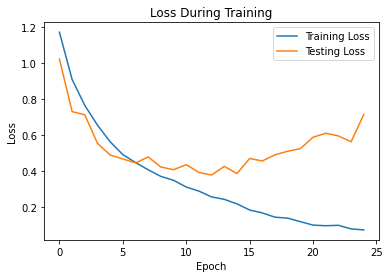

In [10]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

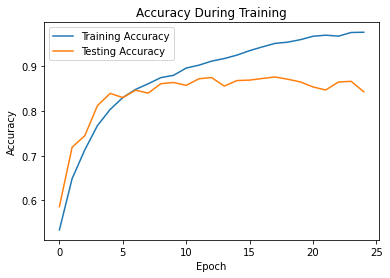

In [11]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [12]:
# === Save for Future Evaluation === #
hypermodel.save( 'No_Preprocess_Results/TUNED_vgg19_intel_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [13]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 11.5712s
Hyperparameter Tuning: 1930.2049s
Training: 2389.4549s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [14]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'No_Preprocess_Results/TUNED_vgg19_intel_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,11.571218
1,Hyperparameter Tuning,1930.204914
2,Training,2389.454864


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [15]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'No_Preprocess_Results/TUNED_vgg19_intel_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.534203,0.586333,1.173298,1.024237
1,2,0.648710,0.719000,0.911189,0.731843
2,3,0.712983,0.744667,0.766523,0.714699
3,4,0.767422,0.812000,0.657153,0.555645
4,5,0.803406,0.839333,0.564333,0.490669
5,6,0.830056,0.830000,0.492789,0.468885
6,7,0.848154,0.846333,0.448931,0.446681
7,8,0.860838,0.840000,0.408668,0.480217
8,9,0.874590,0.861000,0.371628,0.424187
9,10,0.879721,0.863667,0.350207,0.409129
